# Modelling Optimization

Purpose:
* improve the FB Prophet model performance as much as possible by:
    * Tunning Hyper Params
    * Cross Validation
* Check against baseline results 
* Make Predictions with model

Time permitting:
* tune ARIMA model and check against prophet tuned model and baseline models.

In [83]:
# data cleaning 
import pandas as pd
import datetime as dt
from datetime import datetime
import numpy as np

# visualizations
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
# modelling - prophet
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

import itertools
# modelling - other
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
# import statsmodels.API as sm
import warnings; 
warnings.simplefilter('ignore')
#surpress scientific notation
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# import model data log
data_log = pd.read_csv('data/model_data_log.csv')

# import model data in dollars
model_data_grouped = pd.read_csv('data/model_data_grouped.csv')
# model_data_grouped

In [53]:
# Function to get the variable name of a DataFrame
def get_variable_name(dataframe, namespace):
    ''' for documentation, when want to refer to the name of the dataframe, not the dataframe itself
    '''
    for name, obj in namespace.items():
        if obj is dataframe:
            return name
    return None

## Baseline Model 1: Prophet
(from other notebook)

In [3]:
def df_year_filter(df_name, start_year, end_year):
    ''' filters data based on period year for modelling
    '''
    df_name['ds'] = pd.to_datetime(df_name['ds'])
    result = df_name.loc[(df_name['ds'].dt.year >= start_year) & (df_name['ds'].dt.year <= end_year)].reset_index(drop=True)
    return result

In [7]:
# create train data set for years 1988 to 2017, will predict years 2018,2019
train_data = df_year_filter(data_log, start_year=1988, end_year=2017)
# train_data
test_data = df_year_filter(data_log, start_year=2018, end_year=2019)
# test_data

In [6]:
# initialise model, no custom params
m=Prophet()

# initialise model, with best params from earlier gridsearch
# m=Prophet(changepoint_prior_scale = 5,seasonality_prior_scale=0.1,seasonality_mode='multiplicative',yearly_seasonality=True)
# fit train data to model
m.fit(train_data)

12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:43 - cmdstanpy - INFO - Chain [1] done processing


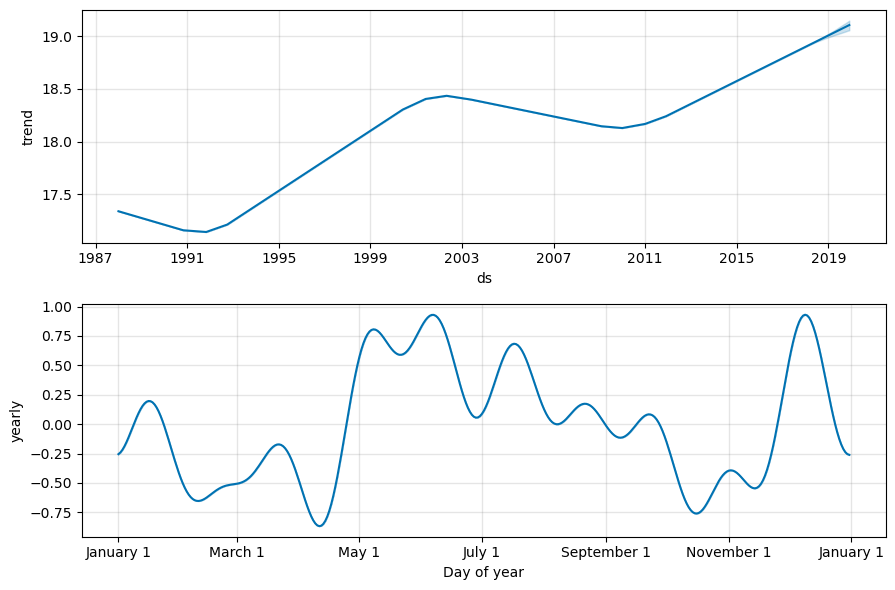

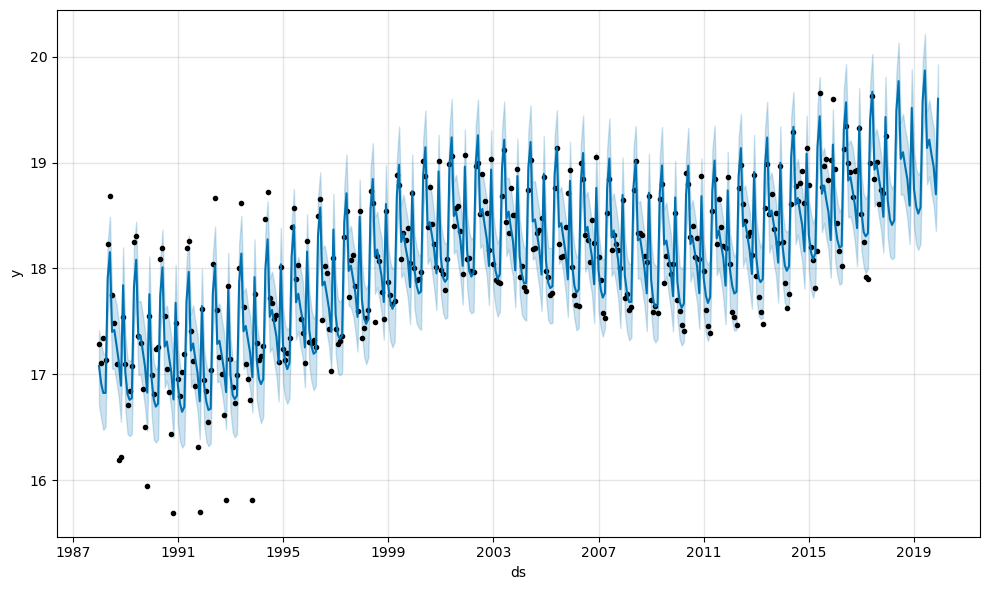

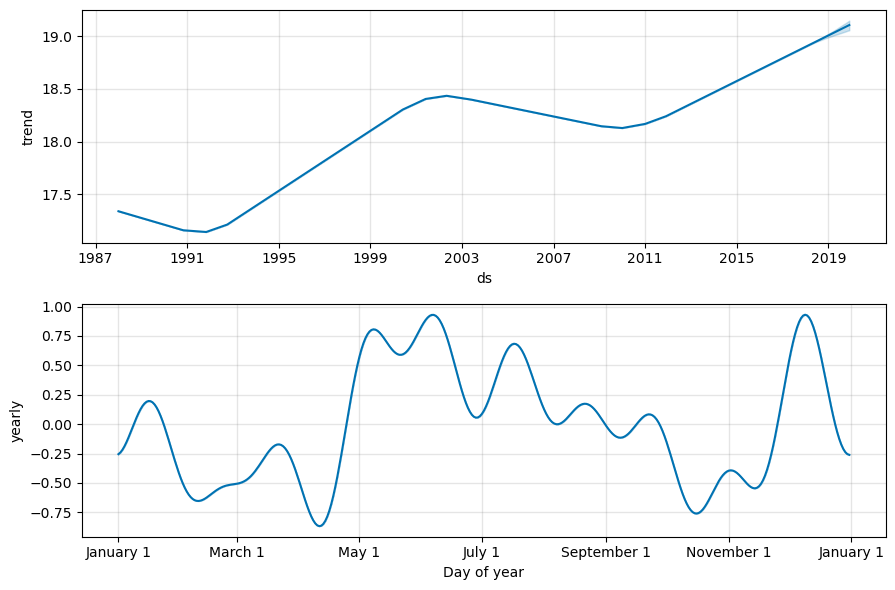

In [7]:
# predict 2018, 2019
future = m.make_future_dataframe(periods = 24, freq="MS")
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

In [8]:
forecast = m.predict(future)
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predictions

,ds,yhat,yhat_lower,yhat_upper
0,1988-01-01,17.08,16.75,17.42
1,1988-02-01,16.91,16.59,17.30
2,1988-03-01,16.82,16.49,17.20
3,1988-04-01,16.82,16.46,17.18
4,1988-05-01,17.91,17.54,18.25
...,...,...,...,...
379,2019-08-01,19.22,18.88,19.59
380,2019-09-01,19.08,18.70,19.42
381,2019-10-01,18.96,18.63,19.33
382,2019-11-01,18.70,18.37,19.07


In [9]:
# get actual values for each period, between 1988 and 2017, values in LOG 
actuals = df_year_filter(data_log, 1988, 2019)
actuals = actuals.rename(columns={'y': 'y-actual'})
actuals

,ds,y-actual
0,1988-01-01,17.28
1,1988-02-01,17.11
2,1988-03-01,17.34
3,1988-04-01,17.13
4,1988-05-01,18.23
...,...,...
379,2019-08-01,19.06
380,2019-09-01,18.96
381,2019-10-01,18.92
382,2019-11-01,18.72


In [10]:
# join actual values and predicted values into one DF
model_eval = predictions.merge(actuals, on='ds', how = 'inner')
model_eval = model_eval.rename(columns={'yhat': 'y-predicted'})
model_eval

,ds,y-predicted,yhat_lower,yhat_upper,y-actual
0,1988-01-01,17.08,16.75,17.42,17.28
1,1988-02-01,16.91,16.59,17.30,17.11
2,1988-03-01,16.82,16.49,17.20,17.34
3,1988-04-01,16.82,16.46,17.18,17.13
4,1988-05-01,17.91,17.54,18.25,18.23
...,...,...,...,...,...
379,2019-08-01,19.22,18.88,19.59,19.06
380,2019-09-01,19.08,18.70,19.42,18.96
381,2019-10-01,18.96,18.63,19.33,18.92
382,2019-11-01,18.70,18.37,19.07,18.72


### Evaluate Model Performance

In [11]:
# return vals to original, take exponent
model_eval_exp = model_eval.copy()
model_eval_exp

,ds,y-predicted,yhat_lower,yhat_upper,y-actual
0,1988-01-01,17.08,16.75,17.42,17.28
1,1988-02-01,16.91,16.59,17.30,17.11
2,1988-03-01,16.82,16.49,17.20,17.34
3,1988-04-01,16.82,16.46,17.18,17.13
4,1988-05-01,17.91,17.54,18.25,18.23
...,...,...,...,...,...
379,2019-08-01,19.22,18.88,19.59,19.06
380,2019-09-01,19.08,18.70,19.42,18.96
381,2019-10-01,18.96,18.63,19.33,18.92
382,2019-11-01,18.70,18.37,19.07,18.72


In [12]:
# return values to original non - log $
model_eval_exp[['y-predicted', 'yhat_lower', 'yhat_upper', 'y-actual']] = np.exp(model_eval_exp[['y-predicted', 'yhat_lower', 'yhat_upper', 'y-actual']])

In [13]:
model_eval_exp

,ds,y-predicted,yhat_lower,yhat_upper,y-actual
0,1988-01-01,"26,125,427.81","18,871,784.76","36,816,955.27","32,094,345.55"
1,1988-02-01,"22,072,594.23","16,094,941.60","32,519,700.91","26,852,319.99"
2,1988-03-01,"20,225,349.91","14,561,587.12","29,506,568.96","34,003,540.09"
3,1988-04-01,"20,240,672.14","14,024,082.27","28,960,239.33","27,637,080.92"
4,1988-05-01,"59,779,802.07","41,601,971.17","84,638,618.19","82,665,791.27"
...,...,...,...,...,...
379,2019-08-01,"221,450,826.28","158,175,008.11","322,881,467.50","190,136,068.39"
380,2019-09-01,"192,477,647.44","132,226,031.87","272,702,489.30","172,289,856.95"
381,2019-10-01,"171,613,607.06","123,115,618.98","249,435,992.03","165,147,457.37"
382,2019-11-01,"132,153,630.87","94,900,069.60","192,079,992.55","135,296,729.64"


#### Visualise Actuals vs Prediction

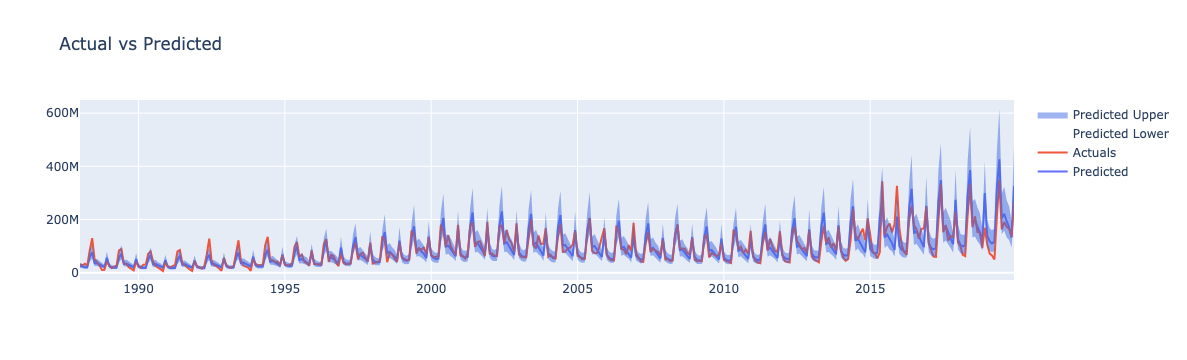

In [18]:
## plot predicted values against actuals, for test range (2018 and 2019 only)
fig = go.Figure()
x_vals1 = df_year_filter(model_eval_exp, 1988, 2019)['ds']


# fig = px.line(preds, title='prediction vs actual', )
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= model_eval_exp['y-predicted'], name = 'Predicted'
))
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= model_eval_exp['y-actual'], name = 'Actuals'
))

fig.update_layout(title='Actual vs Predicted')

fig.add_trace(go.Scatter(x=x_vals1, y=model_eval_exp['yhat_upper'],
    fill=None,
    mode='lines',
    line_color='royalblue',line_width=0, name='Predicted Lower'
    ))
fig.add_trace(go.Scatter(
    x=x_vals1, y=model_eval_exp['yhat_lower'],
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='royalblue', line_width=0, name='Predicted Upper'))

fig.show()

In [19]:
df_compare = model_eval_exp

## Model 2: Prophet Tuned with CV

In [151]:
# us data - not adjusted for inflation
us_data = pd.read_csv('data/data_clean.csv')
us_data = us_data[us_data['Country'].str.contains('United States')].reset_index(drop=True)

# sum sales by period 
us_data = us_data[['Period', 'Value']]
us_data = us_data.groupby('Period').sum().reset_index()
us_data = us_data.rename(columns= {'Period': 'ds', 'Value':'y'})
us_data

,ds,y
0,1988-01-01,14515954
1,1988-02-01,12230446
2,1988-03-01,15530879
3,1988-04-01,12658205
4,1988-05-01,38072540
...,...,...
424,2023-05-01,192319380
425,2023-06-01,321985092
426,2023-07-01,176271374
427,2023-08-01,150469147


### Get Best Params

??? How to use same test train split for comparison?
Train = 1988 to 2017
Test = 2018, 2019

Attempt:
* Use full dataset to get the best params. 
* Re run model with best params, for test, and train seperately, to get seperate scores for easier comparisons

In [152]:
documentation = {}
documentation['description'] = 'Tuned Prophet Model, with CV, using non-indexed values'

In [153]:
# Prophet suggested ranges

changepoint_range = [0.001, 0.101,0.201,0.301,0.401,0.5]

# print('changepoint_range:',changepoint_range)

seasonality_range=[0.01, 1.01, 3.01, 5.0, 7.01, 10]
# print('seasonality_range: ', seasonality_range)

# holidays_range =  np.arange(0.01, 10, 0.5) 
holidays_range=  [0.01, 1.01, 3.01, 5.0, 7.01, 10]
# print('holidays_range: ', holidays_range)

seasonanility_mode = ['additive', 'multiplicative']
yearly_seasonality = [True, False] 

In [154]:

param_grid = {  
    'changepoint_prior_scale': changepoint_range,
    'seasonality_prior_scale': seasonality_range,
    'seasonality_mode':seasonanility_mode, 
    'yearly_seasonality':  yearly_seasonality  
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# all_params
documentation['params_options']= param_grid
documentation

{'description': 'Tuned Prophet Model, with CV, using non-indexed values',
 'params_options': {'changepoint_prior_scale': [0.001,
   0.101,
   0.201,
   0.301,
   0.401,
   0.5],
  'seasonality_prior_scale': [0.01, 1.01, 3.01, 5.0, 7.01, 10],
  'seasonality_mode': ['additive', 'multiplicative'],
  'yearly_seasonality': [True, False]}}

QUESTION: 
* run model for entire data or just training range set given CV?
* default code df_cv value at index 0 meaning? 
* for each loop df_p returns RMSE's for many time horizons how to get one value ?
    * reconclie df_p, vs df_cv meaning
    * take average of all RMSE's in the loop (over different horizons)

In [155]:
# # Use cross-validationa to evaluate all parameters
## takes ~~3 minutes to run

## variables 
cv_cutoffs = pd.to_datetime(['2018-01-01', '2019-01-01']) # manually set dates for new prediction
cv_initial = '10593 days' # number of days from 1988 to 2017
cv_period = '365 days'
cv_horizon = '365 days'
cv_parallel = 'processes'

## Lists to store metrics for each param combo
rmses = []  # Store the RMSEs for each params here
mapes = []# Store the MAPES for each params here
rmses_avg = [] # to compare, the avg rmse for all horizons
mapes_avg = [] # to compare, the avg MAPE for all horizons

# for each unique param combo, run a prophet model 
for params in all_params:
    print(params)
    m = Prophet(**params).fit(us_data)  
    # initial/train from 1988 to 2017 
    # then after 2017, predict one year out every on Jan 1 2018, and Jan 1 2019
    df_cv = cross_validation(m, initial=cv_initial, period=cv_period, horizon = cv_horizon, parallel=cv_parallel, cutoffs=cv_cutoffs)
    print(df_cv)
    # get metrics for overall predictions made using CV, not just on one horizon
    rmse_val = np.sqrt(mean_squared_error(df_cv['y'],df_cv['yhat']))
    mape_val = mean_absolute_percentage_error(df_cv['y'],df_cv['yhat'])
    df_p = performance_metrics(df_cv, rolling_window=1)
    # print(df_p)
    rmses.append(rmse_val)
    mapes.append(mape_val)
    rmses_avg.append(df_p['rmse'].mean())
    mapes_avg.append(df_p['mape'].mean())

documentation[".fit()"] =  get_variable_name(us_data, locals())
documentation['cv_param_cutoffs'] = cv_cutoffs
documentation['cv_param_initial'] = cv_initial
documentation['cv_param_period'] = cv_period
documentation['cv_param_horizon'] = cv_horizon
documentation['cv_param_parallel'] = cv_parallel

# dd/mm/YY H:M:S
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d %H:%M")
documentation["model_prediction_date:"] =  dt_string


14:28:43 - cmdstanpy - INFO - Chain [1] start processing
14:28:43 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True}


14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  83,218,833.83  52,336,582.46 113,183,140.77   80965152   
1  2018-03-01  79,957,769.80  50,251,888.99 110,670,796.06   55383560   
2  2018-04-01  79,288,796.14  48,594,809.01 109,097,022.29   51622955   
3  2018-05-01 124,702,374.24  94,604,571.89 156,389,250.97  176968819   
4  2018-06-01 148,658,592.44 120,715,939.11 178,156,285.50  274311951   
5  2018-07-01 100,850,746.71  70,882,513.80 129,359,456.98  141734086   
6  2018-08-01 105,781,731.64  78,114,044.78 133,132,702.12  175208071   
7  2018-09-01 100,605,736.23  69,967,938.24 133,238,773.80  126732400   
8  2018-10-01 100,111,722.78  71,955,443.61 130,792,332.62  125340703   
9  2018-11-01  96,309,393.36  63,724,411.56 126,091,111.64   76371568   
10 2018-12-01 136,698,071.21 107,050,472.56 166,492,546.16  139650313   
11 2019-01-01  92,440,116.82  62,292,149.57 123,731,677.45   87750515   
12 2019-02-01  87,225,023.90  54,749,204.40 117,792

14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 57,846,499.75 149,281,910.02   80965152   
1  2018-03-01 104,680,595.24 60,914,022.22 150,625,743.17   55383560   
2  2018-04-01 104,919,487.83 58,201,923.49 150,933,782.10   51622955   
3  2018-05-01 105,150,674.21 59,936,244.41 151,468,445.63  176968819   
4  2018-06-01 105,389,566.81 57,224,878.85 150,394,538.60  274311951   
5  2018-07-01 105,620,753.19 58,680,404.68 153,903,384.46  141734086   
6  2018-08-01 105,859,645.78 59,654,362.26 153,410,283.17  175208071   
7  2018-09-01 106,098,538.37 59,614,695.53 150,784,036.35  126732400   
8  2018-10-01 106,329,724.75 55,687,665.35 151,331,551.16  125340703   
9  2018-11-01 106,568,617.35 57,425,908.39 156,224,854.88   76371568   
10 2018-12-01 106,799,803.73 62,682,412.33 152,357,585.18  139650313   
11 2019-01-01 107,038,696.32 59,881,060.12 153,688,256.63   87750515   
12 2019-02-01 108,613,053.39 62,442,568.34 151,589,960.35   5976

14:28:45 - cmdstanpy - INFO - Chain [1] start processing
14:28:45 - cmdstanpy - INFO - Chain [1] start processing
14:28:45 - cmdstanpy - INFO - Chain [1] done processing
14:28:45 - cmdstanpy - INFO - Chain [1] done processing
14:28:45 - cmdstanpy - INFO - Chain [1] start processing
14:28:45 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 101,990,538.29 58,678,750.51 141,096,256.86   80965152   
1  2018-03-01 100,749,418.04 61,829,938.69 141,610,049.78   55383560   
2  2018-04-01 100,073,754.96 56,668,036.76 140,526,489.47   51622955   
3  2018-05-01 109,520,303.94 67,317,878.64 153,185,223.28  176968819   
4  2018-06-01 115,167,831.69 73,783,748.02 158,094,104.51  274311951   
5  2018-07-01 104,501,041.50 62,293,413.31 146,877,504.54  141734086   
6  2018-08-01 105,899,444.63 63,151,057.39 145,714,711.93  175208071   
7  2018-09-01 105,008,053.04 63,330,632.38 148,616,649.45  126732400   
8  2018-10-01 105,801,440.87 60,308,815.18 143,229,548.74  125340703   
9  2018-11-01 105,603,297.33 62,965,741.28 145,005,621.58   76371568   
10 2018-12-01 115,536,621.49 75,360,754.22 158,194,753.00  139650313   
11 2019-01-01 105,832,429.87 63,716,634.65 145,963,906.87   87750515   
12 2019-02-01 107,298,438.97 57,780,679.49 153,630,391.07   5976

14:28:45 - cmdstanpy - INFO - Chain [1] start processing
14:28:45 - cmdstanpy - INFO - Chain [1] start processing
14:28:45 - cmdstanpy - INFO - Chain [1] done processing
14:28:45 - cmdstanpy - INFO - Chain [1] done processing
14:28:45 - cmdstanpy - INFO - Chain [1] start processing
14:28:45 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 57,969,450.99 146,887,937.27   80965152   
1  2018-03-01 104,680,595.24 58,558,253.44 148,430,121.13   55383560   
2  2018-04-01 104,919,487.83 57,319,043.46 149,903,216.79   51622955   
3  2018-05-01 105,150,674.21 62,228,246.76 152,150,311.54  176968819   
4  2018-06-01 105,389,566.81 58,266,997.31 149,923,725.20  274311951   
5  2018-07-01 105,620,753.19 61,821,500.71 153,342,966.49  141734086   
6  2018-08-01 105,859,645.78 57,172,427.34 154,181,736.80  175208071   
7  2018-09-01 106,098,538.37 62,441,469.89 151,180,648.36  126732400   
8  2018-10-01 106,329,724.75 59,847,872.67 152,858,169.62  125340703   
9  2018-11-01 106,568,617.35 59,400,619.82 152,394,014.03   76371568   
10 2018-12-01 106,799,803.73 62,965,020.83 149,979,426.02  139650313   
11 2019-01-01 107,038,696.32 59,202,800.41 152,259,798.04   87750515   
12 2019-02-01 108,613,053.39 57,565,154.92 155,427,038.69   5976

14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,565,076.65  35,776,081.87 113,893,982.12   80965152   
1  2018-03-01  73,157,818.48  36,751,550.60 110,346,942.48   55383560   
2  2018-04-01  75,373,313.04  36,245,114.36 113,706,308.47   51622955   
3  2018-05-01 123,130,515.56  84,822,781.26 160,225,257.20  176968819   
4  2018-06-01 150,207,749.83 109,866,930.00 189,975,521.49  274311951   
5  2018-07-01 102,916,220.62  59,328,649.84 139,527,037.15  141734086   
6  2018-08-01 107,152,187.45  65,980,672.43 143,410,102.67  175208071   
7  2018-09-01 100,570,781.90  62,968,021.98 139,731,638.15  126732400   
8  2018-10-01  98,051,216.38  59,767,190.24 135,919,391.55  125340703   
9  2018-11-01  92,750,209.20  53,971,145.13 132,562,046.63   76371568   
10 2018-12-01 131,792,188.99  92,317,086.15 168,797,095.39  139650313   
11 2019-01-01  84,564,857.07  42,851,351.56 119,660,902.61   87750515   
12 2019-02-01  80,050,104.07  32,433,070.39 126,454

14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 59,884,000.81 149,141,030.31   80965152   
1  2018-03-01 104,680,595.24 57,673,998.67 148,577,191.51   55383560   
2  2018-04-01 104,919,487.83 61,597,388.89 150,103,831.35   51622955   
3  2018-05-01 105,150,674.21 59,426,487.42 150,028,763.29  176968819   
4  2018-06-01 105,389,566.81 64,709,438.05 151,202,382.85  274311951   
5  2018-07-01 105,620,753.19 61,902,312.93 153,429,570.94  141734086   
6  2018-08-01 105,859,645.78 60,839,988.58 153,748,661.55  175208071   
7  2018-09-01 106,098,538.37 60,292,761.71 151,569,248.15  126732400   
8  2018-10-01 106,329,724.75 58,252,408.36 152,363,207.34  125340703   
9  2018-11-01 106,568,617.35 59,717,424.69 152,453,464.49   76371568   
10 2018-12-01 106,799,803.73 61,218,323.24 152,128,983.90  139650313   
11 2019-01-01 107,038,696.32 62,434,870.23 149,360,036.15   87750515   
12 2019-02-01 108,613,053.39 58,450,109.17 156,632,497.86   5976

14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,993,624.49 60,833,259.91 140,934,396.89   80965152   
1  2018-03-01  99,379,975.23 58,426,563.76 140,199,331.94   55383560   
2  2018-04-01  98,472,152.87 57,377,572.68 137,355,152.70   51622955   
3  2018-05-01 110,278,705.72 70,289,149.45 150,150,967.10  176968819   
4  2018-06-01 117,313,047.30 76,576,762.66 159,955,259.69  274311951   
5  2018-07-01 103,854,876.57 60,285,860.46 144,956,599.77  141734086   
6  2018-08-01 105,549,994.32 63,366,148.13 149,449,723.39  175208071   
7  2018-09-01 104,367,208.49 63,911,577.05 144,612,424.11  126732400   
8  2018-10-01 105,304,293.79 60,793,129.80 147,004,667.89  125340703   
9  2018-11-01 104,994,472.61 64,062,653.39 145,313,044.17   76371568   
10 2018-12-01 117,412,746.41 76,440,250.47 157,497,310.37  139650313   
11 2019-01-01 105,162,058.66 61,337,671.20 146,015,895.45   87750515   
12 2019-02-01 105,475,052.98 63,572,631.03 151,647,884.58   5976

14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 59,736,187.77 150,584,526.46   80965152   
1  2018-03-01 104,680,595.24 59,665,732.86 150,681,709.81   55383560   
2  2018-04-01 104,919,487.83 61,296,188.72 152,549,787.91   51622955   
3  2018-05-01 105,150,674.21 55,986,376.31 152,808,415.22  176968819   
4  2018-06-01 105,389,566.81 64,271,521.90 153,152,018.96  274311951   
5  2018-07-01 105,620,753.19 62,130,691.04 151,576,898.53  141734086   
6  2018-08-01 105,859,645.78 58,305,863.37 149,595,267.45  175208071   
7  2018-09-01 106,098,538.37 59,305,321.75 149,935,934.50  126732400   
8  2018-10-01 106,329,724.75 58,143,579.93 150,466,945.54  125340703   
9  2018-11-01 106,568,617.35 60,828,946.77 152,464,329.13   76371568   
10 2018-12-01 106,799,803.73 59,869,144.52 151,505,604.33  139650313   
11 2019-01-01 107,038,696.32 64,533,874.53 152,793,873.67   87750515   
12 2019-02-01 108,613,053.39 58,160,063.09 155,878,437.78   5976

14:28:48 - cmdstanpy - INFO - Chain [1] start processing
14:28:48 - cmdstanpy - INFO - Chain [1] start processing
14:28:48 - cmdstanpy - INFO - Chain [1] done processing
14:28:48 - cmdstanpy - INFO - Chain [1] done processing
14:28:48 - cmdstanpy - INFO - Chain [1] start processing
14:28:48 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,608,641.50  35,799,604.11 114,934,268.61   80965152   
1  2018-03-01  72,919,728.36  35,002,674.89 111,572,529.95   55383560   
2  2018-04-01  74,886,032.17  32,347,249.25 113,361,184.16   51622955   
3  2018-05-01 123,700,337.60  82,529,747.88 161,232,821.55  176968819   
4  2018-06-01 151,209,517.10 112,129,731.29 190,377,709.41  274311951   
5  2018-07-01 102,538,036.32  63,626,556.89 141,676,182.53  141734086   
6  2018-08-01 106,949,430.01  65,737,622.97 147,107,753.99  175208071   
7  2018-09-01 100,319,476.96  61,752,860.92 139,478,640.28  126732400   
8  2018-10-01  97,938,983.27  58,052,545.63 138,497,418.20  125340703   
9  2018-11-01  92,665,496.05  53,523,343.77 130,122,122.31   76371568   
10 2018-12-01 132,940,874.07  95,566,870.27 170,708,232.00  139650313   
11 2019-01-01  84,674,716.45  46,584,705.43 122,254,299.75   87750515   
12 2019-02-01  80,055,847.65  30,166,427.57 129,860

14:28:48 - cmdstanpy - INFO - Chain [1] start processing
14:28:48 - cmdstanpy - INFO - Chain [1] start processing
14:28:48 - cmdstanpy - INFO - Chain [1] done processing
14:28:48 - cmdstanpy - INFO - Chain [1] done processing
14:28:48 - cmdstanpy - INFO - Chain [1] start processing
14:28:48 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 60,211,249.73 146,377,753.37   80965152   
1  2018-03-01 104,680,595.24 61,438,775.07 150,692,574.45   55383560   
2  2018-04-01 104,919,487.83 59,667,901.52 151,284,034.01   51622955   
3  2018-05-01 105,150,674.21 60,078,582.81 149,911,031.63  176968819   
4  2018-06-01 105,389,566.81 56,252,551.47 152,187,960.07  274311951   
5  2018-07-01 105,620,753.19 60,632,625.34 154,178,114.30  141734086   
6  2018-08-01 105,859,645.78 61,035,042.53 150,988,210.24  175208071   
7  2018-09-01 106,098,538.37 60,798,694.37 152,547,161.78  126732400   
8  2018-10-01 106,329,724.75 61,506,331.70 154,306,401.06  125340703   
9  2018-11-01 106,568,617.35 59,065,894.23 154,490,175.12   76371568   
10 2018-12-01 106,799,803.73 60,604,615.74 152,975,967.12  139650313   
11 2019-01-01 107,038,696.32 58,882,912.44 151,330,051.62   87750515   
12 2019-02-01 108,613,053.39 58,597,361.44 156,837,908.11   5976

14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,995,868.79 55,654,489.63 140,818,430.15   80965152   
1  2018-03-01  99,382,456.71 57,856,485.95 141,138,553.04   55383560   
2  2018-04-01  98,474,782.44 58,900,118.00 140,727,478.29   51622955   
3  2018-05-01 110,279,783.56 70,599,763.50 153,016,934.92  176968819   
4  2018-06-01 117,313,200.95 79,505,123.35 156,349,352.13  274311951   
5  2018-07-01 103,856,871.91 63,279,555.87 146,798,823.97  141734086   
6  2018-08-01 105,551,798.66 64,645,900.60 147,157,548.43  175208071   
7  2018-09-01 104,369,194.30 65,096,129.93 144,444,398.76  126732400   
8  2018-10-01 105,306,189.53 65,350,348.27 147,168,404.06  125340703   
9  2018-11-01 104,996,453.79 67,317,208.74 149,492,887.57   76371568   
10 2018-12-01 117,413,115.43 77,795,169.63 160,262,215.90  139650313   
11 2019-01-01 105,164,119.26 59,630,827.42 147,664,686.04   87750515   
12 2019-02-01 105,477,538.23 62,662,172.37 149,642,101.50   5976

14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 62,668,147.35 150,280,712.25   80965152   
1  2018-03-01 104,680,595.24 59,549,287.52 149,930,640.99   55383560   
2  2018-04-01 104,919,487.83 56,845,738.16 150,781,587.21   51622955   
3  2018-05-01 105,150,674.21 59,361,938.79 149,309,070.79  176968819   
4  2018-06-01 105,389,566.81 59,365,297.94 149,956,745.83  274311951   
5  2018-07-01 105,620,753.19 60,040,739.95 150,976,950.07  141734086   
6  2018-08-01 105,859,645.78 59,465,037.51 147,625,545.21  175208071   
7  2018-09-01 106,098,538.37 59,495,824.48 150,656,814.09  126732400   
8  2018-10-01 106,329,724.75 59,814,767.37 149,601,517.77  125340703   
9  2018-11-01 106,568,617.35 62,378,464.23 154,518,461.10   76371568   
10 2018-12-01 106,799,803.73 58,251,829.74 151,800,908.80  139650313   
11 2019-01-01 107,038,696.32 67,198,375.64 153,951,088.25   87750515   
12 2019-02-01 108,613,053.39 60,434,483.64 159,941,915.43   5976

14:28:50 - cmdstanpy - INFO - Chain [1] start processing
14:28:50 - cmdstanpy - INFO - Chain [1] start processing
14:28:50 - cmdstanpy - INFO - Chain [1] done processing
14:28:50 - cmdstanpy - INFO - Chain [1] done processing
14:28:50 - cmdstanpy - INFO - Chain [1] start processing
14:28:50 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,582,517.44  35,435,043.21 110,977,932.22   80965152   
1  2018-03-01  73,307,911.59  35,699,715.79 115,852,487.69   55383560   
2  2018-04-01  75,558,987.65  37,888,718.23 114,804,414.89   51622955   
3  2018-05-01 122,930,174.39  82,741,275.40 160,595,711.31  176968819   
4  2018-06-01 149,875,791.42 110,728,165.43 187,338,318.17  274311951   
5  2018-07-01 103,000,791.93  60,529,993.09 143,953,853.39  141734086   
6  2018-08-01 107,169,409.64  68,629,359.26 144,611,697.73  175208071   
7  2018-09-01 100,611,929.44  63,286,492.61 142,457,491.79  126732400   
8  2018-10-01  98,074,366.80  60,061,283.89 137,695,876.01  125340703   
9  2018-11-01  92,823,869.45  56,908,851.09 131,554,059.67   76371568   
10 2018-12-01 131,515,671.85  95,028,791.34 170,704,411.56  139650313   
11 2019-01-01  84,559,807.86  45,097,555.76 123,072,780.64   87750515   
12 2019-02-01  75,533,210.30  24,910,232.56 123,893

14:28:50 - cmdstanpy - INFO - Chain [1] start processing
14:28:50 - cmdstanpy - INFO - Chain [1] start processing
14:28:50 - cmdstanpy - INFO - Chain [1] done processing
14:28:50 - cmdstanpy - INFO - Chain [1] done processing
14:28:50 - cmdstanpy - INFO - Chain [1] start processing
14:28:50 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 57,689,471.81 148,263,155.59   80965152   
1  2018-03-01 104,680,595.24 59,350,491.72 148,114,120.88   55383560   
2  2018-04-01 104,919,487.83 57,171,929.59 151,932,865.24   51622955   
3  2018-05-01 105,150,674.21 60,329,893.77 151,380,100.52  176968819   
4  2018-06-01 105,389,566.81 60,865,206.87 148,847,793.88  274311951   
5  2018-07-01 105,620,753.19 61,526,564.60 149,753,926.10  141734086   
6  2018-08-01 105,859,645.78 59,751,991.70 149,632,400.87  175208071   
7  2018-09-01 106,098,538.37 59,446,906.13 152,657,083.50  126732400   
8  2018-10-01 106,329,724.75 61,773,997.87 151,599,413.02  125340703   
9  2018-11-01 106,568,617.35 62,496,230.51 149,950,692.12   76371568   
10 2018-12-01 106,799,803.73 61,798,252.41 154,866,825.24  139650313   
11 2019-01-01 107,038,696.32 64,749,669.91 151,681,655.49   87750515   
12 2019-02-01 108,613,053.39 59,240,242.48 154,455,203.80   5976

14:28:51 - cmdstanpy - INFO - Chain [1] start processing
14:28:51 - cmdstanpy - INFO - Chain [1] start processing
14:28:51 - cmdstanpy - INFO - Chain [1] done processing
14:28:51 - cmdstanpy - INFO - Chain [1] done processing
14:28:51 - cmdstanpy - INFO - Chain [1] start processing
14:28:51 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,997,655.19 58,572,012.00 144,036,120.17   80965152   
1  2018-03-01  99,384,465.00 58,089,918.90 140,743,337.20   55383560   
2  2018-04-01  98,476,951.10 58,114,906.20 140,248,578.88   51622955   
3  2018-05-01 110,280,375.41 68,784,195.58 148,565,084.76  176968819   
4  2018-06-01 117,312,876.15 78,910,831.65 159,103,656.17  274311951   
5  2018-07-01 103,858,380.98 61,596,312.02 147,298,038.21  141734086   
6  2018-08-01 105,553,117.30 62,718,667.57 148,387,028.07  175208071   
7  2018-09-01 104,370,692.28 63,262,774.43 144,744,476.52  126732400   
8  2018-10-01 105,307,607.47 65,806,893.91 143,947,900.99  125340703   
9  2018-11-01 104,997,957.38 65,422,509.84 147,757,154.99   76371568   
10 2018-12-01 117,413,002.67 78,306,342.76 158,810,755.48  139650313   
11 2019-01-01 105,165,696.98 65,931,777.15 144,288,150.73   87750515   
12 2019-02-01 105,470,842.28 62,257,998.60 145,294,796.20   5976

14:28:51 - cmdstanpy - INFO - Chain [1] start processing
14:28:51 - cmdstanpy - INFO - Chain [1] start processing
14:28:51 - cmdstanpy - INFO - Chain [1] done processing
14:28:51 - cmdstanpy - INFO - Chain [1] done processing
14:28:51 - cmdstanpy - INFO - Chain [1] start processing
14:28:51 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 57,077,920.42 147,704,022.06   80965152   
1  2018-03-01 104,680,595.24 57,876,506.40 149,214,946.22   55383560   
2  2018-04-01 104,919,487.83 58,759,853.49 147,397,727.53   51622955   
3  2018-05-01 105,150,674.21 62,885,845.74 151,503,280.61  176968819   
4  2018-06-01 105,389,566.81 59,124,584.34 152,823,249.55  274311951   
5  2018-07-01 105,620,753.19 60,370,209.87 146,861,485.32  141734086   
6  2018-08-01 105,859,645.78 62,468,325.48 152,695,506.09  175208071   
7  2018-09-01 106,098,538.37 58,992,461.10 152,256,225.98  126732400   
8  2018-10-01 106,329,724.75 60,847,567.46 152,720,463.09  125340703   
9  2018-11-01 106,568,617.35 58,725,012.95 149,891,795.54   76371568   
10 2018-12-01 106,799,803.73 60,816,466.10 153,360,973.01  139650313   
11 2019-01-01 107,038,696.32 61,726,057.91 153,294,948.42   87750515   
12 2019-02-01 108,613,053.39 65,067,304.79 152,960,516.62   5976

14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,571,209.94  32,318,566.78 112,487,953.76   80965152   
1  2018-03-01  73,237,543.16  32,726,774.76 113,278,799.33   55383560   
2  2018-04-01  75,449,266.27  38,878,066.56 113,533,457.51   51622955   
3  2018-05-01 123,019,107.97  84,284,882.57 163,812,195.75  176968819   
4  2018-06-01 150,040,735.29 110,528,222.59 191,923,720.34  274311951   
5  2018-07-01 102,919,023.75  63,835,677.95 142,408,759.96  141734086   
6  2018-08-01 107,121,471.90  65,962,172.21 146,021,743.77  175208071   
7  2018-09-01 100,554,357.67  64,984,184.62 144,015,041.22  126732400   
8  2018-10-01  98,038,535.90  57,670,126.26 134,873,645.74  125340703   
9  2018-11-01  92,784,128.82  51,717,769.19 131,381,435.50   76371568   
10 2018-12-01 131,692,986.96  88,769,952.65 169,511,735.61  139650313   
11 2019-01-01  84,559,316.48  47,267,914.86 124,574,284.55   87750515   
12 2019-02-01  80,057,130.94  27,652,968.39 125,850

14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 59,961,626.64 149,947,187.73   80965152   
1  2018-03-01 104,680,595.24 58,459,015.52 152,095,320.47   55383560   
2  2018-04-01 104,919,487.83 58,862,291.27 152,783,764.82   51622955   
3  2018-05-01 105,150,674.21 61,786,271.71 149,834,804.98  176968819   
4  2018-06-01 105,389,566.81 58,974,762.38 148,547,974.19  274311951   
5  2018-07-01 105,620,753.19 61,745,829.71 148,327,661.77  141734086   
6  2018-08-01 105,859,645.78 62,003,808.24 151,885,669.83  175208071   
7  2018-09-01 106,098,538.37 60,527,417.78 152,366,313.36  126732400   
8  2018-10-01 106,329,724.75 57,865,284.34 149,374,246.69  125340703   
9  2018-11-01 106,568,617.35 57,586,015.73 150,770,630.22   76371568   
10 2018-12-01 106,799,803.73 59,112,688.40 150,677,916.59  139650313   
11 2019-01-01 107,038,696.32 65,614,308.56 153,615,150.39   87750515   
12 2019-02-01 108,613,053.39 60,062,618.89 155,660,976.14   5976

14:28:53 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing
14:28:53 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,997,252.95 57,611,840.02 142,559,662.17   80965152   
1  2018-03-01  99,384,120.09 57,382,308.31 140,171,274.88   55383560   
2  2018-04-01  98,476,630.17 55,978,055.00 138,600,707.23   51622955   
3  2018-05-01 110,279,691.84 70,709,151.78 152,351,507.90  176968819   
4  2018-06-01 117,311,939.67 77,048,219.71 158,768,959.34  274311951   
5  2018-07-01 103,857,876.50 63,965,111.83 146,003,075.92  141734086   
6  2018-08-01 105,552,581.86 63,630,251.44 146,939,764.72  175208071   
7  2018-09-01 104,370,201.80 63,116,636.58 144,780,620.15  126732400   
8  2018-10-01 105,307,090.07 65,087,221.63 148,839,276.31  125340703   
9  2018-11-01 104,997,475.35 63,804,947.77 146,232,475.21   76371568   
10 2018-12-01 117,412,103.01 72,492,583.06 155,412,093.90  139650313   
11 2019-01-01 105,165,195.51 63,307,477.37 147,456,282.56   87750515   
12 2019-02-01 105,473,521.50 62,652,740.66 150,062,530.02   5976

14:28:53 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing
14:28:53 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 61,469,750.31 148,156,118.45   80965152   
1  2018-03-01 104,680,595.24 57,305,678.18 149,233,849.36   55383560   
2  2018-04-01 104,919,487.83 57,484,988.53 150,054,515.77   51622955   
3  2018-05-01 105,150,674.21 61,607,513.01 152,999,583.66  176968819   
4  2018-06-01 105,389,566.81 58,882,089.53 153,558,711.03  274311951   
5  2018-07-01 105,620,753.19 60,534,104.04 150,965,169.29  141734086   
6  2018-08-01 105,859,645.78 58,881,266.78 151,026,027.66  175208071   
7  2018-09-01 106,098,538.37 62,857,096.77 151,779,393.11  126732400   
8  2018-10-01 106,329,724.75 59,644,575.00 153,872,404.68  125340703   
9  2018-11-01 106,568,617.35 58,007,877.53 148,419,644.73   76371568   
10 2018-12-01 106,799,803.73 60,635,415.01 150,328,466.79  139650313   
11 2019-01-01 107,038,696.32 62,410,516.03 151,131,462.40   87750515   
12 2019-02-01 108,613,053.39 61,316,579.97 159,636,407.64   5976

14:28:54 - cmdstanpy - INFO - Chain [1] start processing
14:28:54 - cmdstanpy - INFO - Chain [1] start processing
14:28:54 - cmdstanpy - INFO - Chain [1] done processing
14:28:54 - cmdstanpy - INFO - Chain [1] done processing
14:28:54 - cmdstanpy - INFO - Chain [1] start processing
14:28:54 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,577,201.79  32,712,613.46 110,268,274.06   80965152   
1  2018-03-01  73,251,768.11  34,473,563.08 109,995,046.87   55383560   
2  2018-04-01  75,467,594.96  39,586,980.86 115,227,201.52   51622955   
3  2018-05-01 123,017,139.41  83,080,322.22 161,170,575.65  176968819   
4  2018-06-01 150,032,512.42 108,220,610.08 189,562,152.93  274311951   
5  2018-07-01 102,935,277.06  65,199,097.59 141,341,569.18  141734086   
6  2018-08-01 107,133,791.99  70,664,395.16 148,761,452.37  175208071   
7  2018-09-01 100,567,269.33  60,243,780.60 139,520,184.48  126732400   
8  2018-10-01  98,049,142.02  57,432,534.69 134,410,844.98  125340703   
9  2018-11-01  92,796,125.02  52,162,323.87 131,410,969.55   76371568   
10 2018-12-01 131,683,733.27  96,057,925.54 171,756,141.79  139650313   
11 2019-01-01  84,565,316.19  42,582,673.23 124,451,097.26   87750515   
12 2019-02-01  80,057,270.23  30,265,763.18 127,162

14:28:54 - cmdstanpy - INFO - Chain [1] start processing
14:28:54 - cmdstanpy - INFO - Chain [1] start processing
14:28:54 - cmdstanpy - INFO - Chain [1] done processing
14:28:54 - cmdstanpy - INFO - Chain [1] done processing
14:28:54 - cmdstanpy - INFO - Chain [1] start processing
14:28:54 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 61,386,807.36 154,461,658.42   80965152   
1  2018-03-01 104,680,595.24 57,122,530.81 145,419,399.87   55383560   
2  2018-04-01 104,919,487.83 58,914,811.99 148,510,150.00   51622955   
3  2018-05-01 105,150,674.21 60,047,965.07 149,884,762.10  176968819   
4  2018-06-01 105,389,566.81 63,609,746.71 152,050,700.89  274311951   
5  2018-07-01 105,620,753.19 60,216,806.16 149,794,005.21  141734086   
6  2018-08-01 105,859,645.78 60,391,061.93 150,058,151.43  175208071   
7  2018-09-01 106,098,538.37 62,584,585.57 154,103,947.70  126732400   
8  2018-10-01 106,329,724.75 60,408,035.72 149,972,110.77  125340703   
9  2018-11-01 106,568,617.35 60,091,980.16 152,349,238.90   76371568   
10 2018-12-01 106,799,803.73 61,063,499.04 155,737,375.62  139650313   
11 2019-01-01 107,038,696.32 64,411,297.50 154,400,825.93   87750515   
12 2019-02-01 108,613,053.39 56,559,346.61 151,411,277.80   5976

14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,997,320.25 61,177,323.37 142,382,103.13   80965152   
1  2018-03-01  99,384,114.86 56,812,780.66 140,579,591.09   55383560   
2  2018-04-01  98,476,540.33 57,127,425.07 138,139,539.43   51622955   
3  2018-05-01 110,280,271.18 70,389,215.55 149,127,623.56  176968819   
4  2018-06-01 117,312,930.70 72,018,257.08 156,298,129.68  274311951   
5  2018-07-01 103,858,097.68 62,776,651.24 143,426,708.60  141734086   
6  2018-08-01 105,552,859.17 64,527,059.18 148,202,238.89  175208071   
7  2018-09-01 104,370,431.54 65,227,436.35 144,323,965.40  126732400   
8  2018-10-01 105,307,338.94 65,875,865.52 142,803,089.70  125340703   
9  2018-11-01 104,997,680.59 64,774,351.82 144,305,120.50   76371568   
10 2018-12-01 117,413,030.91 76,912,434.87 158,609,698.90  139650313   
11 2019-01-01 105,165,420.75 63,379,795.03 148,366,664.12   87750515   
12 2019-02-01 105,475,130.01 62,495,400.68 148,052,483.55   5976

14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 60,680,432.03 150,065,574.44   80965152   
1  2018-03-01 104,680,595.24 60,502,552.72 152,580,097.41   55383560   
2  2018-04-01 104,919,487.83 61,355,501.06 150,644,402.35   51622955   
3  2018-05-01 105,150,674.21 62,282,071.12 150,438,947.36  176968819   
4  2018-06-01 105,389,566.81 58,241,428.69 149,162,087.96  274311951   
5  2018-07-01 105,620,753.19 58,528,409.64 147,571,344.35  141734086   
6  2018-08-01 105,859,645.78 60,157,948.73 148,342,959.11  175208071   
7  2018-09-01 106,098,538.37 59,615,006.10 148,945,468.11  126732400   
8  2018-10-01 106,329,724.75 62,709,855.69 151,110,774.90  125340703   
9  2018-11-01 106,568,617.35 62,135,769.02 154,582,644.33   76371568   
10 2018-12-01 106,799,803.73 64,139,148.43 151,175,711.89  139650313   
11 2019-01-01 107,038,696.32 62,828,350.06 150,886,049.55   87750515   
12 2019-02-01 108,613,053.39 60,434,142.57 155,531,002.80   5976

14:28:56 - cmdstanpy - INFO - Chain [1] start processing
14:28:56 - cmdstanpy - INFO - Chain [1] start processing
14:28:56 - cmdstanpy - INFO - Chain [1] done processing
14:28:56 - cmdstanpy - INFO - Chain [1] done processing
14:28:56 - cmdstanpy - INFO - Chain [1] start processing
14:28:56 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,750,229.58  95,328,913.97 140,272,427.27   80965152   
1  2018-03-01 113,573,571.98  89,042,594.91 135,633,875.86   55383560   
2  2018-04-01 113,638,510.12  89,117,603.31 139,573,495.18   51622955   
3  2018-05-01 161,435,148.98 138,567,517.64 186,652,276.09  176968819   
4  2018-06-01 186,721,609.51 160,563,497.69 209,428,966.69  274311951   
5  2018-07-01 137,831,154.40 114,035,423.89 160,998,586.67  141734086   
6  2018-08-01 143,594,463.00 118,729,541.24 168,115,332.43  175208071   
7  2018-09-01 138,739,060.62 115,608,407.08 162,784,908.28  126732400   
8  2018-10-01 138,636,956.48 114,666,781.46 162,874,292.56  125340703   
9  2018-11-01 134,927,408.20 110,006,220.23 158,264,324.92   76371568   
10 2018-12-01 177,098,426.15 153,801,863.81 199,761,296.82  139650313   
11 2019-01-01 132,318,537.21 107,517,585.64 155,317,424.53   87750515   
12 2019-02-01 120,450,544.77  94,118,366.51 144,858

14:28:56 - cmdstanpy - INFO - Chain [1] start processing
14:28:56 - cmdstanpy - INFO - Chain [1] start processing
14:28:56 - cmdstanpy - INFO - Chain [1] done processing
14:28:56 - cmdstanpy - INFO - Chain [1] done processing
14:28:56 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 87,875,124.81 172,869,013.85   80965152   
1  2018-03-01 128,072,158.84 86,540,355.86 169,478,789.04   55383560   
2  2018-04-01 128,733,186.48 89,222,184.20 170,081,439.08   51622955   
3  2018-05-01 129,372,890.65 87,429,937.01 169,461,847.98  176968819   
4  2018-06-01 130,033,918.30 86,161,462.76 171,775,928.30  274311951   
5  2018-07-01 130,673,622.47 92,571,779.68 171,838,725.27  141734086   
6  2018-08-01 131,334,650.11 94,561,983.21 172,480,553.06  175208071   
7  2018-09-01 131,995,677.75 90,602,244.58 168,614,867.53  126732400   
8  2018-10-01 132,635,381.92 90,861,330.27 177,438,629.26  125340703   
9  2018-11-01 133,296,409.57 91,840,816.70 173,171,539.38   76371568   
10 2018-12-01 133,936,113.74 90,812,890.94 173,938,540.03  139650313   
11 2019-01-01 134,597,141.38 95,734,059.55 176,972,106.59   87750515   
12 2019-02-01 133,546,449.14 88,134,705.58 175,630,430.76   5976

14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 127,991,688.75  92,718,361.23 165,421,983.36   80965152   
1  2018-03-01 125,697,959.70  89,197,413.43 158,553,030.54   55383560   
2  2018-04-01 124,591,362.32  91,010,031.81 159,130,002.93   51622955   
3  2018-05-01 143,394,766.03 105,315,620.41 178,274,707.64  176968819   
4  2018-06-01 155,925,863.88 118,453,763.12 190,828,234.02  274311951   
5  2018-07-01 134,672,830.22 100,242,077.02 170,835,946.12  141734086   
6  2018-08-01 137,719,754.01 104,772,140.33 173,946,341.31  175208071   
7  2018-09-01 136,015,558.64 100,850,625.75 171,990,923.61  126732400   
8  2018-10-01 137,880,942.38 105,907,321.92 175,508,801.21  125340703   
9  2018-11-01 137,664,007.99 100,615,820.87 172,063,582.15   76371568   
10 2018-12-01 158,064,638.04 123,620,604.33 193,917,279.15  139650313   
11 2019-01-01 138,111,407.38 102,481,142.84 173,703,551.42   87750515   
12 2019-02-01 131,797,241.15  95,034,063.57 167,206

14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:58 - cmdstanpy - INFO - Chain [1] start processing
14:28:58 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 85,246,596.21 168,772,150.83   80965152   
1  2018-03-01 128,072,158.84 87,439,594.11 170,149,139.46   55383560   
2  2018-04-01 128,733,186.48 86,833,471.80 166,810,078.01   51622955   
3  2018-05-01 129,372,890.65 86,888,879.84 169,844,821.80  176968819   
4  2018-06-01 130,033,918.30 87,141,646.02 170,353,134.95  274311951   
5  2018-07-01 130,673,622.47 92,995,050.09 170,354,930.65  141734086   
6  2018-08-01 131,334,650.11 90,367,487.72 174,856,546.26  175208071   
7  2018-09-01 131,995,677.75 94,664,183.30 172,419,608.13  126732400   
8  2018-10-01 132,635,381.92 93,723,082.83 170,972,716.02  125340703   
9  2018-11-01 133,296,409.57 93,734,000.37 174,641,227.00   76371568   
10 2018-12-01 133,936,113.74 95,260,470.99 174,337,642.28  139650313   
11 2019-01-01 134,597,141.38 95,518,806.88 176,728,110.52   87750515   
12 2019-02-01 133,546,449.14 91,785,672.35 175,825,831.70   5976

14:28:58 - cmdstanpy - INFO - Chain [1] start processing
14:28:58 - cmdstanpy - INFO - Chain [1] start processing
14:28:58 - cmdstanpy - INFO - Chain [1] done processing
14:28:58 - cmdstanpy - INFO - Chain [1] done processing
14:28:58 - cmdstanpy - INFO - Chain [1] start processing
14:28:58 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,942,258.31  88,063,555.17 136,888,243.75   80965152   
1  2018-03-01 110,027,776.42  87,597,595.40 132,278,248.77   55383560   
2  2018-04-01 111,313,155.74  88,402,223.29 134,213,627.92   51622955   
3  2018-05-01 163,718,026.60 140,279,869.39 188,351,783.62  176968819   
4  2018-06-01 195,727,926.95 172,709,718.64 218,591,572.60  274311951   
5  2018-07-01 139,636,783.23 114,936,666.86 161,871,236.53  141734086   
6  2018-08-01 146,532,685.42 121,311,236.51 168,056,507.19  175208071   
7  2018-09-01 141,083,382.53 118,676,567.18 164,360,809.20  126732400   
8  2018-10-01 138,471,206.86 115,457,660.66 161,823,558.23  125340703   
9  2018-11-01 132,874,230.00 109,398,351.97 156,430,175.33   76371568   
10 2018-12-01 181,289,056.36 157,294,543.88 204,080,903.04  139650313   
11 2019-01-01 130,844,356.77 110,063,311.16 154,686,263.33   87750515   
12 2019-02-01 116,612,917.39  89,975,060.54 139,770

14:28:58 - cmdstanpy - INFO - Chain [1] start processing
14:28:58 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 87,946,484.13 167,717,702.90   80965152   
1  2018-03-01 128,072,158.84 87,224,236.25 163,861,962.98   55383560   
2  2018-04-01 128,733,186.48 88,591,912.95 167,482,055.79   51622955   
3  2018-05-01 129,372,890.65 89,844,576.63 169,040,763.94  176968819   
4  2018-06-01 130,033,918.30 88,434,891.20 170,023,302.29  274311951   
5  2018-07-01 130,673,622.47 92,908,942.79 174,239,726.31  141734086   
6  2018-08-01 131,334,650.11 88,392,760.27 169,651,207.21  175208071   
7  2018-09-01 131,995,677.75 88,732,600.61 172,557,443.16  126732400   
8  2018-10-01 132,635,381.92 93,708,267.85 172,640,518.61  125340703   
9  2018-11-01 133,296,409.57 93,715,726.70 173,884,772.22   76371568   
10 2018-12-01 133,936,113.74 95,621,851.85 174,220,595.89  139650313   
11 2019-01-01 134,597,141.38 94,098,082.02 177,534,964.91   87750515   
12 2019-02-01 133,546,449.14 89,796,087.38 174,341,852.87   5976

14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,638,246.63  61,775,775.49  97,060,322.56   80965152   
1  2018-03-01  67,530,822.99  49,448,133.92  84,263,098.91   55383560   
2  2018-04-01  66,953,650.72  49,869,151.65  82,540,311.67   51622955   
3  2018-05-01 181,576,312.70 163,488,817.39 199,126,064.45  176968819   
4  2018-06-01 277,208,809.82 258,935,920.52 293,568,672.97  274311951   
5  2018-07-01 139,551,595.33 123,160,411.40 157,593,804.80  141734086   
6  2018-08-01 155,882,620.59 138,575,383.22 173,509,813.22  175208071   
7  2018-09-01 141,689,521.84 124,873,574.82 159,369,385.68  126732400   
8  2018-10-01 137,308,526.55 120,981,816.58 155,000,374.34  125340703   
9  2018-11-01 125,956,766.07 109,163,359.74 144,625,012.70   76371568   
10 2018-12-01 242,018,419.06 223,667,011.59 259,231,014.42  139650313   
11 2019-01-01 112,545,832.11  95,763,188.19 130,213,104.86   87750515   
12 2019-02-01  81,677,205.87  62,437,359.32 101,449

14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing
14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61  86,934,317.67 164,242,115.44   80965152   
1  2018-03-01 128,072,158.84  90,161,674.10 170,082,648.96   55383560   
2  2018-04-01 128,733,186.48  89,392,511.58 174,423,232.16   51622955   
3  2018-05-01 129,372,890.65  86,891,938.91 168,380,436.51  176968819   
4  2018-06-01 130,033,918.30  89,214,108.25 169,709,392.38  274311951   
5  2018-07-01 130,673,622.47  90,858,293.77 170,355,832.88  141734086   
6  2018-08-01 131,334,650.11  90,274,321.71 170,880,678.97  175208071   
7  2018-09-01 131,995,677.75  95,459,110.68 169,840,284.06  126732400   
8  2018-10-01 132,635,381.92  93,183,491.38 173,645,709.33  125340703   
9  2018-11-01 133,296,409.57  92,470,724.49 174,065,764.66   76371568   
10 2018-12-01 133,936,113.74  92,689,603.60 174,957,352.95  139650313   
11 2019-01-01 134,597,141.38  90,954,445.53 173,709,923.40   87750515   
12 2019-02-01 133,546,449.14  91,166,764.97 172,711

14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing
14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,672,898.34  90,393,043.08 135,799,541.24   80965152   
1  2018-03-01 109,768,097.06  86,938,272.36 132,735,404.47   55383560   
2  2018-04-01 111,060,718.11  86,747,227.64 135,091,579.39   51622955   
3  2018-05-01 163,387,000.01 141,931,974.07 189,368,343.69  176968819   
4  2018-06-01 195,505,392.84 170,403,799.95 219,121,842.27  274311951   
5  2018-07-01 139,358,343.98 115,877,370.81 163,337,092.71  141734086   
6  2018-08-01 146,286,673.35 122,553,589.68 168,115,162.68  175208071   
7  2018-09-01 140,858,809.24 118,993,687.85 165,158,092.71  126732400   
8  2018-10-01 138,178,419.69 114,421,024.43 160,852,508.85  125340703   
9  2018-11-01 132,552,057.63 107,140,571.41 155,205,811.48   76371568   
10 2018-12-01 181,020,069.73 158,450,413.03 204,993,841.34  139650313   
11 2019-01-01 130,600,472.66 108,042,021.86 153,044,955.07   87750515   
12 2019-02-01 116,649,726.70  91,805,321.05 142,204

14:29:01 - cmdstanpy - INFO - Chain [1] start processing
14:29:01 - cmdstanpy - INFO - Chain [1] start processing
14:29:01 - cmdstanpy - INFO - Chain [1] done processing
14:29:01 - cmdstanpy - INFO - Chain [1] done processing
14:29:01 - cmdstanpy - INFO - Chain [1] start processing
14:29:01 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 88,895,357.18 170,102,463.67   80965152   
1  2018-03-01 128,072,158.84 87,774,591.02 167,849,266.30   55383560   
2  2018-04-01 128,733,186.48 89,253,505.57 169,517,896.94   51622955   
3  2018-05-01 129,372,890.65 86,582,253.97 174,256,898.76  176968819   
4  2018-06-01 130,033,918.30 88,679,379.79 172,221,745.77  274311951   
5  2018-07-01 130,673,622.47 88,185,194.42 171,831,192.02  141734086   
6  2018-08-01 131,334,650.11 91,901,961.33 167,733,912.25  175208071   
7  2018-09-01 131,995,677.75 89,925,711.50 172,368,421.84  126732400   
8  2018-10-01 132,635,381.92 90,028,936.41 173,822,949.31  125340703   
9  2018-11-01 133,296,409.57 91,682,198.38 172,327,253.52   76371568   
10 2018-12-01 133,936,113.74 90,645,443.76 173,864,960.16  139650313   
11 2019-01-01 134,597,141.38 94,730,625.70 173,502,179.52   87750515   
12 2019-02-01 133,546,449.14 91,509,081.27 176,289,547.89   5976

14:29:01 - cmdstanpy - INFO - Chain [1] start processing
14:29:01 - cmdstanpy - INFO - Chain [1] start processing
14:29:01 - cmdstanpy - INFO - Chain [1] done processing
14:29:01 - cmdstanpy - INFO - Chain [1] done processing
14:29:01 - cmdstanpy - INFO - Chain [1] start processing
14:29:01 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,929,246.87  64,144,695.79  97,432,352.27   80965152   
1  2018-03-01  67,832,079.53  49,793,690.69  85,004,261.94   55383560   
2  2018-04-01  67,228,222.44  49,466,536.97  85,943,402.53   51622955   
3  2018-05-01 181,969,931.71 165,785,518.34 198,468,851.26  176968819   
4  2018-06-01 278,022,372.69 260,703,977.92 295,382,821.34  274311951   
5  2018-07-01 139,983,595.30 122,847,452.12 157,969,983.59  141734086   
6  2018-08-01 156,357,450.12 139,350,997.55 174,171,839.25  175208071   
7  2018-09-01 142,129,521.18 124,518,652.71 159,671,412.98  126732400   
8  2018-10-01 137,731,151.34 120,192,940.00 156,237,555.45  125340703   
9  2018-11-01 126,335,297.82 108,574,687.99 143,643,953.82   76371568   
10 2018-12-01 242,668,254.00 225,002,820.78 261,404,151.66  139650313   
11 2019-01-01 112,854,661.91  96,533,542.60 130,546,550.73   87750515   
12 2019-02-01  81,600,543.19  62,538,034.81 100,365

14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61  87,292,189.96 167,783,346.03   80965152   
1  2018-03-01 128,072,158.84  87,180,018.33 169,269,863.94   55383560   
2  2018-04-01 128,733,186.48  90,988,066.19 167,755,483.75   51622955   
3  2018-05-01 129,372,890.65  89,064,448.53 169,074,710.88  176968819   
4  2018-06-01 130,033,918.30  90,657,128.39 169,826,866.50  274311951   
5  2018-07-01 130,673,622.47  89,234,689.46 171,049,731.51  141734086   
6  2018-08-01 131,334,650.11  88,834,610.87 171,690,941.84  175208071   
7  2018-09-01 131,995,677.75  93,239,473.73 170,395,353.46  126732400   
8  2018-10-01 132,635,381.92  92,516,772.48 172,466,470.48  125340703   
9  2018-11-01 133,296,409.57  93,789,843.26 170,635,013.64   76371568   
10 2018-12-01 133,936,113.74  95,214,094.88 175,554,666.67  139650313   
11 2019-01-01 134,597,141.38  94,618,392.47 174,104,679.27   87750515   
12 2019-02-01 133,546,449.14  90,793,370.91 174,461

14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,400,598.92  88,772,924.29 134,113,447.25   80965152   
1  2018-03-01 109,477,536.11  85,091,998.37 133,395,519.85   55383560   
2  2018-04-01 110,753,365.61  86,185,437.94 132,941,787.01   51622955   
3  2018-05-01 163,188,625.09 140,435,735.41 186,407,146.08  176968819   
4  2018-06-01 195,142,133.10 170,319,056.05 218,622,224.97  274311951   
5  2018-07-01 139,058,866.71 115,804,164.37 162,881,093.09  141734086   
6  2018-08-01 145,942,675.21 122,985,756.87 167,782,348.43  175208071   
7  2018-09-01 140,479,154.84 118,095,227.65 164,219,007.28  126732400   
8  2018-10-01 137,874,521.45 113,962,246.25 162,529,215.52  125340703   
9  2018-11-01 132,278,807.71 108,354,645.29 155,764,852.93   76371568   
10 2018-12-01 180,657,598.12 159,296,944.40 205,960,055.43  139650313   
11 2019-01-01 130,212,340.93 108,267,629.48 154,978,908.99   87750515   
12 2019-02-01 116,572,019.29  90,060,768.71 141,820

14:29:03 - cmdstanpy - INFO - Chain [1] start processing
14:29:03 - cmdstanpy - INFO - Chain [1] start processing
14:29:03 - cmdstanpy - INFO - Chain [1] done processing
14:29:03 - cmdstanpy - INFO - Chain [1] done processing
14:29:03 - cmdstanpy - INFO - Chain [1] start processing
14:29:03 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61  90,062,596.94 163,737,747.81   80965152   
1  2018-03-01 128,072,158.84  90,080,920.82 169,205,996.42   55383560   
2  2018-04-01 128,733,186.48  89,976,187.16 170,250,659.68   51622955   
3  2018-05-01 129,372,890.65  88,110,830.39 171,695,137.60  176968819   
4  2018-06-01 130,033,918.30  89,253,812.31 169,525,924.41  274311951   
5  2018-07-01 130,673,622.47  87,475,694.73 173,908,101.42  141734086   
6  2018-08-01 131,334,650.11  92,333,769.64 170,251,187.94  175208071   
7  2018-09-01 131,995,677.75  91,705,084.89 174,601,908.87  126732400   
8  2018-10-01 132,635,381.92  91,890,799.87 171,661,106.30  125340703   
9  2018-11-01 133,296,409.57  92,225,583.89 172,455,997.35   76371568   
10 2018-12-01 133,936,113.74  94,448,931.93 175,376,164.26  139650313   
11 2019-01-01 134,597,141.38  95,335,556.83 175,665,576.44   87750515   
12 2019-02-01 133,546,449.14  89,169,551.53 176,748

14:29:03 - cmdstanpy - INFO - Chain [1] start processing
14:29:03 - cmdstanpy - INFO - Chain [1] start processing
14:29:03 - cmdstanpy - INFO - Chain [1] done processing
14:29:03 - cmdstanpy - INFO - Chain [1] done processing
14:29:03 - cmdstanpy - INFO - Chain [1] start processing
14:29:03 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,885,314.63  63,290,551.14  97,446,211.69   80965152   
1  2018-03-01  67,778,741.54  50,401,944.02  85,312,010.96   55383560   
2  2018-04-01  67,167,535.71  49,929,053.49  84,636,694.17   51622955   
3  2018-05-01 182,135,392.22 165,560,399.23 201,520,428.13  176968819   
4  2018-06-01 277,769,131.25 260,980,416.11 295,301,770.87  274311951   
5  2018-07-01 139,928,887.27 122,521,160.78 157,411,005.18  141734086   
6  2018-08-01 156,288,847.00 138,142,003.21 174,385,359.85  175208071   
7  2018-09-01 142,039,723.79 125,177,685.40 159,868,598.83  126732400   
8  2018-10-01 137,794,932.37 120,785,375.36 155,059,513.75  125340703   
9  2018-11-01 126,424,170.61 108,930,674.26 144,221,514.63   76371568   
10 2018-12-01 242,698,305.60 225,903,649.95 259,900,332.59  139650313   
11 2019-01-01 112,743,618.90  95,523,114.92 130,832,396.32   87750515   
12 2019-02-01  81,577,621.05  62,799,769.23 100,442

14:29:04 - cmdstanpy - INFO - Chain [1] start processing
14:29:04 - cmdstanpy - INFO - Chain [1] start processing
14:29:04 - cmdstanpy - INFO - Chain [1] done processing
14:29:04 - cmdstanpy - INFO - Chain [1] done processing
14:29:04 - cmdstanpy - INFO - Chain [1] start processing
14:29:04 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61  86,468,276.66 166,471,793.44   80965152   
1  2018-03-01 128,072,158.84  85,118,137.43 167,002,152.79   55383560   
2  2018-04-01 128,733,186.48  87,271,347.27 167,901,146.40   51622955   
3  2018-05-01 129,372,890.65  87,100,433.38 166,349,939.94  176968819   
4  2018-06-01 130,033,918.30  86,531,113.13 170,017,684.08  274311951   
5  2018-07-01 130,673,622.47  89,045,412.48 172,247,946.84  141734086   
6  2018-08-01 131,334,650.11  88,276,389.95 177,233,256.19  175208071   
7  2018-09-01 131,995,677.75  93,438,320.01 172,683,944.88  126732400   
8  2018-10-01 132,635,381.92  91,713,549.21 173,809,903.99  125340703   
9  2018-11-01 133,296,409.57  91,835,524.42 175,611,269.81   76371568   
10 2018-12-01 133,936,113.74  91,815,459.72 172,930,479.90  139650313   
11 2019-01-01 134,597,141.38  90,898,763.39 173,155,868.61   87750515   
12 2019-02-01 133,546,449.14  87,896,713.54 175,944

14:29:04 - cmdstanpy - INFO - Chain [1] start processing
14:29:04 - cmdstanpy - INFO - Chain [1] start processing
14:29:04 - cmdstanpy - INFO - Chain [1] done processing
14:29:04 - cmdstanpy - INFO - Chain [1] done processing
14:29:04 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,532,167.49  88,401,538.89 134,616,419.05   80965152   
1  2018-03-01 109,612,282.82  85,070,233.00 131,748,937.07   55383560   
2  2018-04-01 110,880,470.04  87,388,829.35 134,590,466.34   51622955   
3  2018-05-01 163,310,657.97 141,478,727.30 185,203,509.95  176968819   
4  2018-06-01 195,286,366.97 170,698,887.14 218,793,597.86  274311951   
5  2018-07-01 139,189,488.24 116,236,164.98 163,532,039.73  141734086   
6  2018-08-01 146,089,924.51 122,222,939.10 169,909,706.34  175208071   
7  2018-09-01 140,638,690.75 116,737,452.01 162,641,802.49  126732400   
8  2018-10-01 138,020,803.34 114,184,501.39 162,658,117.04  125340703   
9  2018-11-01 132,403,761.29 108,438,588.95 156,981,174.57   76371568   
10 2018-12-01 180,798,500.76 156,745,669.44 203,917,073.33  139650313   
11 2019-01-01 130,366,832.36 106,331,709.43 154,376,481.77   87750515   
12 2019-02-01 116,259,937.37  90,962,361.74 141,605

14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 86,283,241.81 169,838,041.63   80965152   
1  2018-03-01 128,072,158.84 84,263,505.33 168,365,362.97   55383560   
2  2018-04-01 128,733,186.48 87,024,406.78 173,147,677.97   51622955   
3  2018-05-01 129,372,890.65 87,445,851.84 171,782,528.99  176968819   
4  2018-06-01 130,033,918.30 87,502,263.58 166,256,103.85  274311951   
5  2018-07-01 130,673,622.47 88,674,530.51 173,578,918.93  141734086   
6  2018-08-01 131,334,650.11 92,137,349.28 174,382,733.65  175208071   
7  2018-09-01 131,995,677.75 92,513,751.35 172,668,614.67  126732400   
8  2018-10-01 132,635,381.92 92,923,521.55 171,560,218.90  125340703   
9  2018-11-01 133,296,409.57 94,672,456.55 172,817,862.24   76371568   
10 2018-12-01 133,936,113.74 94,012,384.88 174,500,261.38  139650313   
11 2019-01-01 134,597,141.38 96,911,715.76 174,781,132.61   87750515   
12 2019-02-01 133,546,449.14 89,162,876.70 176,125,234.81   5976

14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:06 - cmdstanpy - INFO - Chain [1] done processing
14:29:06 - cmdstanpy - INFO - Chain [1] start processing
14:29:06 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,905,314.23  63,545,976.58  97,855,521.32   80965152   
1  2018-03-01  67,826,870.43  49,294,368.01  85,614,346.12   55383560   
2  2018-04-01  67,242,547.82  49,442,627.63  85,203,578.31   51622955   
3  2018-05-01 181,898,270.59 164,633,366.23 200,184,218.61  176968819   
4  2018-06-01 278,315,325.60 261,164,382.88 295,168,798.62  274311951   
5  2018-07-01 139,914,573.05 122,244,597.90 157,905,137.67  141734086   
6  2018-08-01 156,372,483.93 138,893,224.72 173,079,634.29  175208071   
7  2018-09-01 142,239,512.69 124,665,803.39 159,789,916.84  126732400   
8  2018-10-01 137,620,841.10 120,054,216.69 156,215,325.11  125340703   
9  2018-11-01 126,234,087.40 108,462,427.94 144,422,562.07   76371568   
10 2018-12-01 242,926,684.34 225,917,201.71 260,854,538.49  139650313   
11 2019-01-01 112,889,851.37  97,198,184.40 130,486,252.67   87750515   
12 2019-02-01  81,495,482.30  63,879,539.35 100,862

14:29:06 - cmdstanpy - INFO - Chain [1] start processing
14:29:06 - cmdstanpy - INFO - Chain [1] done processing
14:29:06 - cmdstanpy - INFO - Chain [1] start processing
14:29:06 - cmdstanpy - INFO - Chain [1] done processing
14:29:06 - cmdstanpy - INFO - Chain [1] start processing
14:29:06 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 86,487,350.80 166,297,981.90   80965152   
1  2018-03-01 128,072,158.84 88,436,887.22 165,706,953.64   55383560   
2  2018-04-01 128,733,186.48 85,832,579.17 171,965,058.54   51622955   
3  2018-05-01 129,372,890.65 91,101,658.49 168,799,064.14  176968819   
4  2018-06-01 130,033,918.30 91,058,041.00 171,134,930.02  274311951   
5  2018-07-01 130,673,622.47 88,991,006.04 171,585,222.80  141734086   
6  2018-08-01 131,334,650.11 89,372,408.57 172,547,500.91  175208071   
7  2018-09-01 131,995,677.75 89,346,638.06 170,806,982.74  126732400   
8  2018-10-01 132,635,381.92 92,525,565.97 173,569,660.25  125340703   
9  2018-11-01 133,296,409.57 93,332,454.11 174,112,330.11   76371568   
10 2018-12-01 133,936,113.74 92,228,268.40 173,462,907.93  139650313   
11 2019-01-01 134,597,141.38 94,391,993.75 176,142,926.39   87750515   
12 2019-02-01 133,546,449.14 91,672,253.35 175,657,607.45   5976

14:29:07 - cmdstanpy - INFO - Chain [1] start processing
14:29:07 - cmdstanpy - INFO - Chain [1] start processing
14:29:07 - cmdstanpy - INFO - Chain [1] done processing
14:29:07 - cmdstanpy - INFO - Chain [1] done processing
14:29:07 - cmdstanpy - INFO - Chain [1] start processing
14:29:07 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,679,943.78  89,708,698.25 135,765,208.47   80965152   
1  2018-03-01 109,803,227.75  88,262,232.09 133,125,749.82   55383560   
2  2018-04-01 111,095,051.46  87,631,906.38 134,848,259.44   51622955   
3  2018-05-01 163,397,300.02 138,390,739.62 186,809,573.96  176968819   
4  2018-06-01 195,513,845.12 170,761,873.23 218,281,853.19  274311951   
5  2018-07-01 139,377,657.01 114,997,364.36 163,441,235.36  141734086   
6  2018-08-01 146,308,378.31 124,769,375.71 169,774,236.64  175208071   
7  2018-09-01 140,883,288.23 118,414,661.51 163,192,970.55  126732400   
8  2018-10-01 138,190,898.99 115,511,835.36 161,756,408.34  125340703   
9  2018-11-01 132,561,413.69 109,249,436.76 156,947,259.28   76371568   
10 2018-12-01 181,018,933.87 159,509,858.13 203,842,061.99  139650313   
11 2019-01-01 130,615,650.53 107,524,127.68 153,448,142.45   87750515   
12 2019-02-01 116,387,065.98  91,810,789.34 141,905

14:29:07 - cmdstanpy - INFO - Chain [1] start processing
14:29:07 - cmdstanpy - INFO - Chain [1] start processing
14:29:07 - cmdstanpy - INFO - Chain [1] done processing
14:29:07 - cmdstanpy - INFO - Chain [1] done processing
14:29:07 - cmdstanpy - INFO - Chain [1] start processing
14:29:07 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 87,346,661.37 167,526,075.10   80965152   
1  2018-03-01 128,072,158.84 90,352,599.84 166,503,487.56   55383560   
2  2018-04-01 128,733,186.48 88,543,897.10 167,184,739.46   51622955   
3  2018-05-01 129,372,890.65 90,021,247.97 169,769,134.67  176968819   
4  2018-06-01 130,033,918.30 88,564,673.32 171,093,783.86  274311951   
5  2018-07-01 130,673,622.47 90,048,545.98 172,169,827.23  141734086   
6  2018-08-01 131,334,650.11 88,267,245.82 172,784,591.97  175208071   
7  2018-09-01 131,995,677.75 91,041,712.75 172,438,430.28  126732400   
8  2018-10-01 132,635,381.92 95,671,510.43 174,655,984.05  125340703   
9  2018-11-01 133,296,409.57 94,491,404.29 172,743,764.72   76371568   
10 2018-12-01 133,936,113.74 93,970,148.93 174,385,149.13  139650313   
11 2019-01-01 134,597,141.38 93,900,582.93 176,001,672.55   87750515   
12 2019-02-01 133,546,449.14 92,270,196.06 174,758,769.52   5976

14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,051,579.04  63,039,264.05  96,657,252.37   80965152   
1  2018-03-01  67,937,176.64  50,151,500.20  85,547,093.77   55383560   
2  2018-04-01  67,277,884.32  48,608,840.40  84,968,962.60   51622955   
3  2018-05-01 181,504,321.24 165,168,524.81 198,638,104.78  176968819   
4  2018-06-01 278,907,193.04 262,029,241.73 298,544,606.16  274311951   
5  2018-07-01 139,898,207.10 122,985,051.58 157,545,278.60  141734086   
6  2018-08-01 156,504,148.03 139,813,643.33 173,610,621.41  175208071   
7  2018-09-01 142,526,080.10 124,873,718.67 159,819,532.03  126732400   
8  2018-10-01 137,630,478.25 120,574,793.09 155,635,777.09  125340703   
9  2018-11-01 126,197,690.66 108,699,674.65 144,023,906.41   76371568   
10 2018-12-01 243,296,710.69 225,624,547.29 261,142,364.39  139650313   
11 2019-01-01 113,165,977.08  95,670,915.42 131,352,141.55   87750515   
12 2019-02-01  81,579,649.71  62,197,215.80 100,658

14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 87,713,732.60 170,452,868.14   80965152   
1  2018-03-01 128,072,158.84 89,433,355.46 171,054,898.20   55383560   
2  2018-04-01 128,733,186.48 87,566,186.98 168,081,053.48   51622955   
3  2018-05-01 129,372,890.65 87,741,886.42 169,841,458.52  176968819   
4  2018-06-01 130,033,918.30 91,158,971.79 171,355,227.36  274311951   
5  2018-07-01 130,673,622.47 92,244,964.85 170,271,466.55  141734086   
6  2018-08-01 131,334,650.11 89,637,463.67 172,616,313.04  175208071   
7  2018-09-01 131,995,677.75 89,229,525.83 173,384,183.69  126732400   
8  2018-10-01 132,635,381.92 91,476,449.39 172,296,378.15  125340703   
9  2018-11-01 133,296,409.57 93,875,901.23 174,648,083.00   76371568   
10 2018-12-01 133,936,113.74 91,566,603.03 173,527,288.66  139650313   
11 2019-01-01 134,597,141.38 94,360,545.21 174,425,828.70   87750515   
12 2019-02-01 133,546,449.14 92,926,270.93 176,550,000.09   5976

14:29:09 - cmdstanpy - INFO - Chain [1] start processing
14:29:09 - cmdstanpy - INFO - Chain [1] start processing
14:29:09 - cmdstanpy - INFO - Chain [1] done processing
14:29:09 - cmdstanpy - INFO - Chain [1] done processing
14:29:09 - cmdstanpy - INFO - Chain [1] start processing
14:29:09 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 119,543,482.43  96,674,378.00 143,771,801.39   80965152   
1  2018-03-01 116,423,751.65  90,590,311.13 139,748,515.19   55383560   
2  2018-04-01 116,581,274.87  93,144,277.31 139,538,337.15   51622955   
3  2018-05-01 164,596,198.54 139,833,729.53 188,869,629.27  176968819   
4  2018-06-01 190,042,361.04 165,324,388.92 213,519,009.20  274311951   
5  2018-07-01 141,091,176.61 117,307,821.87 164,317,663.97  141734086   
6  2018-08-01 146,942,570.33 124,717,512.35 171,266,234.52  175208071   
7  2018-09-01 142,138,265.26 120,045,990.00 167,010,330.93  126732400   
8  2018-10-01 142,092,492.39 119,539,084.41 165,881,477.00  125340703   
9  2018-11-01 138,433,010.31 114,741,245.55 164,187,262.11   76371568   
10 2018-12-01 180,782,846.67 159,319,431.71 204,524,759.91  139650313   
11 2019-01-01 135,854,604.97 112,359,161.61 160,349,441.61   87750515   
12 2019-02-01 121,947,599.71  96,363,394.18 147,879

14:29:09 - cmdstanpy - INFO - Chain [1] start processing
14:29:09 - cmdstanpy - INFO - Chain [1] start processing
14:29:09 - cmdstanpy - INFO - Chain [1] done processing
14:29:09 - cmdstanpy - INFO - Chain [1] done processing
14:29:09 - cmdstanpy - INFO - Chain [1] start processing
14:29:09 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  95,198,710.27 175,906,531.18   80965152   
1  2018-03-01 136,627,935.78  96,003,181.38 174,586,135.86   55383560   
2  2018-04-01 137,488,690.13  99,071,608.17 177,861,228.85   51622955   
3  2018-05-01 138,321,678.22  98,370,736.18 178,386,708.54  176968819   
4  2018-06-01 139,182,432.57  98,823,259.32 179,244,632.36  274311951   
5  2018-07-01 140,015,420.65 100,935,834.60 178,967,453.09  141734086   
6  2018-08-01 140,876,175.00 102,191,822.23 180,507,224.30  175208071   
7  2018-09-01 141,736,929.36 104,293,169.40 179,596,331.79  126732400   
8  2018-10-01 142,569,917.44 101,162,603.07 182,912,331.11  125340703   
9  2018-11-01 143,430,671.79 105,509,134.52 183,075,680.96   76371568   
10 2018-12-01 144,263,659.87 104,101,650.13 184,246,034.37  139650313   
11 2019-01-01 145,124,414.22 105,104,650.16 186,988,990.71   87750515   
12 2019-02-01 139,507,457.78  98,532,822.22 178,465

14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 133,276,049.93 101,785,119.26 168,441,312.09   80965152   
1  2018-03-01 130,796,112.95  95,795,765.09 166,971,763.31   55383560   
2  2018-04-01 129,638,432.06  93,201,263.62 161,793,384.86   51622955   
3  2018-05-01 150,292,130.35 115,695,851.79 184,644,227.37  176968819   
4  2018-06-01 164,191,368.75 128,038,170.83 200,193,794.60  274311951   
5  2018-07-01 140,877,092.31 105,998,216.82 175,446,288.73  141734086   
6  2018-08-01 144,292,062.15 107,875,518.28 177,616,706.42  175208071   
7  2018-09-01 142,501,474.25 106,046,523.24 177,517,075.85  126732400   
8  2018-10-01 144,603,870.11 111,702,997.78 182,344,643.20  125340703   
9  2018-11-01 144,435,626.03 111,571,879.26 179,761,987.79   76371568   
10 2018-12-01 166,982,653.96 131,270,600.51 202,993,933.90  139650313   
11 2019-01-01 144,920,310.34 110,483,113.70 180,386,818.73   87750515   
12 2019-02-01 137,805,900.34 101,089,275.25 175,430

14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  99,890,360.01 172,088,733.87   80965152   
1  2018-03-01 136,627,935.78  96,281,694.84 175,638,654.09   55383560   
2  2018-04-01 137,488,690.13  97,120,959.48 177,809,084.86   51622955   
3  2018-05-01 138,321,678.22 100,387,113.09 174,443,243.58  176968819   
4  2018-06-01 139,182,432.57  99,084,699.73 175,051,509.02  274311951   
5  2018-07-01 140,015,420.65 100,088,604.12 176,003,265.87  141734086   
6  2018-08-01 140,876,175.00 100,960,544.66 180,821,438.22  175208071   
7  2018-09-01 141,736,929.36  98,643,956.61 182,881,425.63  126732400   
8  2018-10-01 142,569,917.44 105,540,259.49 184,639,129.12  125340703   
9  2018-11-01 143,430,671.79 104,708,338.95 180,372,075.67   76371568   
10 2018-12-01 144,263,659.87 107,196,113.36 184,970,745.93  139650313   
11 2019-01-01 145,124,414.22 106,940,509.97 184,923,609.92   87750515   
12 2019-02-01 139,507,457.78  95,424,223.16 181,248

14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,346,448.12  92,261,811.02 138,432,133.19   80965152   
1  2018-03-01 112,490,601.54  90,925,981.37 136,651,695.78   55383560   
2  2018-04-01 113,856,489.88  90,234,234.78 138,492,285.78   51622955   
3  2018-05-01 166,178,967.56 144,270,572.14 188,660,646.14  176968819   
4  2018-06-01 198,446,444.85 174,113,108.87 221,128,442.58  274311951   
5  2018-07-01 142,323,782.05 118,278,408.39 165,666,517.12  141734086   
6  2018-08-01 149,342,472.58 126,292,580.89 173,467,081.41  175208071   
7  2018-09-01 143,995,317.08 120,647,651.42 168,772,961.79  126732400   
8  2018-10-01 141,351,045.34 117,701,023.47 164,589,544.04  125340703   
9  2018-11-01 135,788,084.06 112,688,840.21 158,563,637.50   76371568   
10 2018-12-01 184,377,677.60 160,968,074.46 207,473,784.04  139650313   
11 2019-01-01 133,895,756.44 109,348,108.10 156,927,445.89   87750515   
12 2019-02-01 117,570,330.70  94,660,960.83 143,446

14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  96,326,414.23 176,309,153.27   80965152   
1  2018-03-01 136,627,935.78  96,398,479.91 175,886,858.79   55383560   
2  2018-04-01 137,488,690.13  98,135,102.38 173,462,896.86   51622955   
3  2018-05-01 138,321,678.22  95,720,737.83 177,780,963.23  176968819   
4  2018-06-01 139,182,432.57  99,481,498.67 178,783,008.19  274311951   
5  2018-07-01 140,015,420.65 101,639,469.38 178,362,110.26  141734086   
6  2018-08-01 140,876,175.00 101,446,381.43 181,531,584.79  175208071   
7  2018-09-01 141,736,929.36  99,943,768.41 180,640,009.76  126732400   
8  2018-10-01 142,569,917.44 102,754,297.68 183,421,204.96  125340703   
9  2018-11-01 143,430,671.79 106,189,927.59 184,854,527.14   76371568   
10 2018-12-01 144,263,659.87 105,590,548.18 183,801,186.72  139650313   
11 2019-01-01 145,124,414.22 106,479,412.33 185,209,302.32   87750515   
12 2019-02-01 139,507,457.78  97,717,794.33 182,600

14:29:12 - cmdstanpy - INFO - Chain [1] start processing
14:29:12 - cmdstanpy - INFO - Chain [1] start processing
14:29:12 - cmdstanpy - INFO - Chain [1] done processing
14:29:12 - cmdstanpy - INFO - Chain [1] done processing
14:29:12 - cmdstanpy - INFO - Chain [1] start processing
14:29:12 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,278,941.05  62,684,336.77  97,387,108.01   80965152   
1  2018-03-01  68,056,794.59  51,044,340.12  85,336,000.69   55383560   
2  2018-04-01  67,762,741.34  51,298,850.05  85,531,651.92   51622955   
3  2018-05-01 182,232,987.41 165,671,437.47 199,653,034.23  176968819   
4  2018-06-01 280,188,943.33 263,143,642.22 296,747,753.64  274311951   
5  2018-07-01 140,580,137.43 123,060,332.37 159,686,114.16  141734086   
6  2018-08-01 157,268,284.04 140,622,660.73 174,942,532.74  175208071   
7  2018-09-01 143,324,625.91 125,494,229.86 158,956,800.97  126732400   
8  2018-10-01 138,286,855.44 121,452,112.44 154,217,558.82  125340703   
9  2018-11-01 126,988,618.50 109,067,685.30 144,398,868.59   76371568   
10 2018-12-01 244,221,962.58 228,686,145.95 261,104,416.26  139650313   
11 2019-01-01 113,795,393.17  97,436,706.48 130,507,775.04   87750515   
12 2019-02-01  82,777,835.59  64,616,519.03 101,606

14:29:12 - cmdstanpy - INFO - Chain [1] start processing
14:29:12 - cmdstanpy - INFO - Chain [1] start processing
14:29:12 - cmdstanpy - INFO - Chain [1] done processing
14:29:12 - cmdstanpy - INFO - Chain [1] done processing
14:29:12 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  94,631,267.57 174,961,774.50   80965152   
1  2018-03-01 136,627,935.78  96,250,990.09 175,333,066.65   55383560   
2  2018-04-01 137,488,690.13  95,338,208.74 177,158,378.40   51622955   
3  2018-05-01 138,321,678.22 101,387,332.52 177,047,554.55  176968819   
4  2018-06-01 139,182,432.57  98,625,971.60 179,967,144.16  274311951   
5  2018-07-01 140,015,420.65 101,535,408.59 180,051,323.38  141734086   
6  2018-08-01 140,876,175.00  99,657,966.84 179,259,502.52  175208071   
7  2018-09-01 141,736,929.36 104,038,849.29 182,900,008.55  126732400   
8  2018-10-01 142,569,917.44 102,108,070.80 183,399,302.46  125340703   
9  2018-11-01 143,430,671.79 101,496,894.02 186,743,950.85   76371568   
10 2018-12-01 144,263,659.87 105,964,172.06 185,398,262.72  139650313   
11 2019-01-01 145,124,414.22 105,674,042.57 183,926,422.04   87750515   
12 2019-02-01 139,507,457.78  95,845,814.31 184,592

14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing
14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,338,620.89  91,514,542.33 137,488,069.80   80965152   
1  2018-03-01 112,467,392.49  89,549,029.39 134,031,534.70   55383560   
2  2018-04-01 113,792,624.56  90,749,515.17 135,340,867.19   51622955   
3  2018-05-01 166,361,215.77 143,287,664.31 188,887,531.34  176968819   
4  2018-06-01 198,301,415.91 174,558,073.38 219,420,324.09  274311951   
5  2018-07-01 142,318,430.63 120,048,238.97 165,887,863.65  141734086   
6  2018-08-01 149,250,128.06 125,499,057.89 171,490,767.40  175208071   
7  2018-09-01 143,837,180.37 121,086,805.07 168,727,228.36  126732400   
8  2018-10-01 141,377,846.84 116,559,752.47 163,531,396.54  125340703   
9  2018-11-01 135,883,681.62 111,617,939.67 160,694,739.96   76371568   
10 2018-12-01 184,282,596.84 162,296,552.37 208,405,503.59  139650313   
11 2019-01-01 133,752,208.34 110,396,332.08 157,073,604.04   87750515   
12 2019-02-01 117,581,838.52  93,708,508.80 142,167

14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing
14:29:14 - cmdstanpy - INFO - Chain [1] start processing
14:29:14 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  98,965,714.38 177,525,717.22   80965152   
1  2018-03-01 136,627,935.78  98,814,885.07 174,273,935.88   55383560   
2  2018-04-01 137,488,690.13  96,981,172.16 175,676,630.25   51622955   
3  2018-05-01 138,321,678.22  99,708,573.19 178,558,551.37  176968819   
4  2018-06-01 139,182,432.57  97,772,745.26 178,897,425.31  274311951   
5  2018-07-01 140,015,420.65 101,601,583.73 180,090,833.11  141734086   
6  2018-08-01 140,876,175.00  99,352,383.23 181,029,445.84  175208071   
7  2018-09-01 141,736,929.36 102,951,399.96 183,099,295.90  126732400   
8  2018-10-01 142,569,917.44 102,801,615.62 181,567,037.88  125340703   
9  2018-11-01 143,430,671.79 104,830,853.53 182,207,382.80   76371568   
10 2018-12-01 144,263,659.87 106,728,904.81 185,600,109.83  139650313   
11 2019-01-01 145,124,414.22 105,592,922.25 185,475,701.27   87750515   
12 2019-02-01 139,507,457.78  95,361,144.78 180,568

14:29:14 - cmdstanpy - INFO - Chain [1] start processing
14:29:14 - cmdstanpy - INFO - Chain [1] start processing
14:29:14 - cmdstanpy - INFO - Chain [1] done processing
14:29:14 - cmdstanpy - INFO - Chain [1] done processing
14:29:14 - cmdstanpy - INFO - Chain [1] start processing
14:29:14 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,277,529.23  63,646,118.27  97,847,540.20   80965152   
1  2018-03-01  68,063,251.77  51,601,201.24  85,464,297.44   55383560   
2  2018-04-01  67,782,244.03  50,573,054.48  84,671,706.85   51622955   
3  2018-05-01 181,926,175.72 164,990,436.10 199,225,723.81  176968819   
4  2018-06-01 280,845,484.59 264,466,806.15 299,513,878.32  274311951   
5  2018-07-01 140,519,304.44 123,797,718.76 157,762,100.76  141734086   
6  2018-08-01 157,386,131.03 138,893,093.82 175,260,395.25  175208071   
7  2018-09-01 143,608,230.45 125,838,156.69 160,804,811.71  126732400   
8  2018-10-01 138,066,266.19 121,908,247.21 155,752,396.03  125340703   
9  2018-11-01 126,756,739.36 109,779,022.96 145,304,701.80   76371568   
10 2018-12-01 244,489,417.10 226,445,479.74 261,356,963.47  139650313   
11 2019-01-01 114,005,372.65  96,065,377.50 131,460,318.34   87750515   
12 2019-02-01  82,558,450.58  64,280,402.08 101,820

14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  96,920,430.21 174,160,015.25   80965152   
1  2018-03-01 136,627,935.78  96,964,384.52 175,791,824.13   55383560   
2  2018-04-01 137,488,690.13  98,602,486.42 179,038,984.14   51622955   
3  2018-05-01 138,321,678.22  97,054,243.62 176,964,899.03  176968819   
4  2018-06-01 139,182,432.57  98,287,829.23 179,135,963.18  274311951   
5  2018-07-01 140,015,420.65 101,791,883.45 179,947,611.57  141734086   
6  2018-08-01 140,876,175.00  99,662,971.23 179,314,853.95  175208071   
7  2018-09-01 141,736,929.36 103,756,947.87 181,118,938.23  126732400   
8  2018-10-01 142,569,917.44  99,858,092.12 181,684,552.40  125340703   
9  2018-11-01 143,430,671.79 102,719,353.90 183,837,807.75   76371568   
10 2018-12-01 144,263,659.87 104,085,664.79 182,967,332.95  139650313   
11 2019-01-01 145,124,414.22 106,988,071.25 184,092,790.51   87750515   
12 2019-02-01 139,507,457.78  97,027,687.61 177,535

14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,176,035.54  93,271,678.30 139,823,327.27   80965152   
1  2018-03-01 112,312,709.87  88,444,089.96 133,528,678.29   55383560   
2  2018-04-01 113,640,574.11  89,310,441.34 137,113,275.32   51622955   
3  2018-05-01 166,084,620.02 143,302,964.42 186,824,743.70  176968819   
4  2018-06-01 198,176,985.10 173,790,584.84 222,247,951.40  274311951   
5  2018-07-01 142,117,936.94 119,209,513.05 165,036,727.20  141734086   
6  2018-08-01 149,090,563.42 127,833,860.38 171,715,892.87  175208071   
7  2018-09-01 143,708,182.40 120,488,087.60 167,493,336.24  126732400   
8  2018-10-01 141,163,612.35 118,178,407.93 163,318,882.48  125340703   
9  2018-11-01 135,627,516.41 112,199,530.49 157,334,846.98   76371568   
10 2018-12-01 184,110,062.83 161,937,418.05 207,188,981.25  139650313   
11 2019-01-01 133,604,429.36 110,840,236.45 156,806,527.83   87750515   
12 2019-02-01 117,375,599.00  93,663,885.36 141,380

14:29:16 - cmdstanpy - INFO - Chain [1] start processing
14:29:16 - cmdstanpy - INFO - Chain [1] start processing
14:29:16 - cmdstanpy - INFO - Chain [1] done processing
14:29:16 - cmdstanpy - INFO - Chain [1] done processing
14:29:16 - cmdstanpy - INFO - Chain [1] start processing
14:29:16 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  96,437,628.01 173,957,153.02   80965152   
1  2018-03-01 136,627,935.78  96,716,362.92 175,128,127.82   55383560   
2  2018-04-01 137,488,690.13  97,903,083.96 177,171,172.96   51622955   
3  2018-05-01 138,321,678.22  99,980,977.27 176,765,607.57  176968819   
4  2018-06-01 139,182,432.57 100,199,430.04 178,630,775.00  274311951   
5  2018-07-01 140,015,420.65 100,561,634.35 181,495,566.51  141734086   
6  2018-08-01 140,876,175.00  99,907,254.81 181,915,206.83  175208071   
7  2018-09-01 141,736,929.36 100,593,840.50 182,242,396.29  126732400   
8  2018-10-01 142,569,917.44 102,305,994.90 181,794,246.67  125340703   
9  2018-11-01 143,430,671.79 103,925,273.53 183,069,070.83   76371568   
10 2018-12-01 144,263,659.87 101,246,877.94 182,479,309.75  139650313   
11 2019-01-01 145,124,414.22 104,112,663.05 183,304,151.32   87750515   
12 2019-02-01 139,507,457.78  98,071,128.73 182,597

14:29:16 - cmdstanpy - INFO - Chain [1] start processing
14:29:16 - cmdstanpy - INFO - Chain [1] start processing
14:29:16 - cmdstanpy - INFO - Chain [1] done processing
14:29:16 - cmdstanpy - INFO - Chain [1] done processing
14:29:16 - cmdstanpy - INFO - Chain [1] start processing
14:29:16 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,337,882.78  63,325,865.33  97,915,131.32   80965152   
1  2018-03-01  68,111,812.38  51,321,223.45  85,965,525.61   55383560   
2  2018-04-01  67,834,489.85  51,317,871.95  85,894,697.86   51622955   
3  2018-05-01 182,523,051.69 165,273,457.73 200,518,010.97  176968819   
4  2018-06-01 280,580,784.32 262,593,806.61 296,731,077.16  274311951   
5  2018-07-01 140,752,849.65 124,425,948.21 158,677,400.93  141734086   
6  2018-08-01 157,487,760.43 140,531,238.10 174,889,690.45  175208071   
7  2018-09-01 143,555,654.94 126,872,281.24 160,339,929.77  126732400   
8  2018-10-01 138,403,316.84 121,671,373.86 154,546,739.97  125340703   
9  2018-11-01 127,079,314.57 109,398,850.66 144,751,486.01   76371568   
10 2018-12-01 244,582,320.54 227,970,001.10 262,152,124.68  139650313   
11 2019-01-01 113,925,475.52  96,383,129.05 131,446,362.62   87750515   
12 2019-02-01  82,782,606.49  63,201,626.75 101,851

14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  94,759,863.64 173,343,940.61   80965152   
1  2018-03-01 136,627,935.78  95,107,290.48 173,574,946.64   55383560   
2  2018-04-01 137,488,690.13  98,819,749.94 174,725,494.43   51622955   
3  2018-05-01 138,321,678.22  98,430,040.95 176,625,292.85  176968819   
4  2018-06-01 139,182,432.57  99,443,397.73 177,496,821.56  274311951   
5  2018-07-01 140,015,420.65  98,208,917.60 182,366,559.18  141734086   
6  2018-08-01 140,876,175.00 102,875,433.69 179,624,096.27  175208071   
7  2018-09-01 141,736,929.36  97,496,155.92 181,385,195.63  126732400   
8  2018-10-01 142,569,917.44 103,507,752.37 181,847,833.79  125340703   
9  2018-11-01 143,430,671.79 105,803,791.36 182,634,865.33   76371568   
10 2018-12-01 144,263,659.87 104,282,428.87 183,591,467.17  139650313   
11 2019-01-01 145,124,414.22 103,472,303.71 184,419,010.30   87750515   
12 2019-02-01 139,507,457.78  99,694,541.31 182,203

14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,268,037.15  91,948,224.03 139,154,009.63   80965152   
1  2018-03-01 112,408,494.30  89,614,485.39 135,922,275.63   55383560   
2  2018-04-01 113,741,278.24  91,143,801.72 138,115,885.68   51622955   
3  2018-05-01 166,183,684.05 142,825,094.58 189,063,233.38  176968819   
4  2018-06-01 198,282,898.32 174,675,179.21 221,491,753.84  274311951   
5  2018-07-01 142,222,837.14 119,923,369.76 164,344,893.42  141734086   
6  2018-08-01 149,196,363.90 125,767,374.44 171,914,699.29  175208071   
7  2018-09-01 143,815,256.78 120,866,771.43 166,587,286.22  126732400   
8  2018-10-01 141,271,394.12 118,267,991.27 163,445,042.97  125340703   
9  2018-11-01 135,740,634.78 111,803,937.81 159,105,932.70   76371568   
10 2018-12-01 184,231,246.97 161,093,936.78 208,673,760.27  139650313   
11 2019-01-01 133,725,037.24 111,644,678.62 156,644,223.50   87750515   
12 2019-02-01 117,624,433.58  91,425,759.21 142,281

14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  97,145,873.59 177,051,804.19   80965152   
1  2018-03-01 136,627,935.78  94,468,523.21 175,823,611.21   55383560   
2  2018-04-01 137,488,690.13  99,257,079.50 175,841,700.00   51622955   
3  2018-05-01 138,321,678.22  97,697,594.19 178,236,844.68  176968819   
4  2018-06-01 139,182,432.57 102,690,167.73 175,251,894.72  274311951   
5  2018-07-01 140,015,420.65  99,330,103.03 182,251,008.50  141734086   
6  2018-08-01 140,876,175.00 101,774,819.75 181,389,301.83  175208071   
7  2018-09-01 141,736,929.36 103,211,595.69 180,905,507.27  126732400   
8  2018-10-01 142,569,917.44 104,598,752.07 183,404,156.91  125340703   
9  2018-11-01 143,430,671.79 105,159,653.45 183,274,905.77   76371568   
10 2018-12-01 144,263,659.87 105,413,668.13 184,028,256.70  139650313   
11 2019-01-01 145,124,414.22 109,651,637.07 185,957,642.06   87750515   
12 2019-02-01 139,507,457.78  99,128,763.29 181,515

14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,403,233.02  62,436,724.33  97,305,403.67   80965152   
1  2018-03-01  68,186,046.36  51,265,934.02  86,683,133.70   55383560   
2  2018-04-01  67,911,664.93  51,866,243.36  84,197,653.52   51622955   
3  2018-05-01 182,072,072.47 164,791,957.54 199,376,664.08  176968819   
4  2018-06-01 281,393,878.84 264,180,418.30 298,612,313.59  274311951   
5  2018-07-01 140,712,938.94 124,444,061.73 159,238,862.62  141734086   
6  2018-08-01 157,677,136.63 139,801,171.37 174,086,688.32  175208071   
7  2018-09-01 143,979,474.87 127,719,414.38 162,370,366.92  126732400   
8  2018-10-01 138,143,992.41 120,975,274.88 154,719,418.38  125340703   
9  2018-11-01 126,730,302.43 109,145,253.05 143,630,056.92   76371568   
10 2018-12-01 245,060,281.77 228,146,987.27 261,903,148.55  139650313   
11 2019-01-01 114,268,252.03  96,698,519.70 132,010,434.94   87750515   
12 2019-02-01  82,578,705.32  63,394,682.48 101,145

14:29:19 - cmdstanpy - INFO - Chain [1] start processing
14:29:19 - cmdstanpy - INFO - Chain [1] start processing
14:29:19 - cmdstanpy - INFO - Chain [1] done processing
14:29:19 - cmdstanpy - INFO - Chain [1] done processing
14:29:19 - cmdstanpy - INFO - Chain [1] start processing
14:29:19 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  93,203,953.72 173,394,263.33   80965152   
1  2018-03-01 136,627,935.78  94,912,623.81 174,470,615.72   55383560   
2  2018-04-01 137,488,690.13  98,980,655.63 174,984,774.09   51622955   
3  2018-05-01 138,321,678.22 101,317,417.75 178,885,006.16  176968819   
4  2018-06-01 139,182,432.57  98,024,026.04 180,108,643.01  274311951   
5  2018-07-01 140,015,420.65 103,228,606.37 181,190,862.98  141734086   
6  2018-08-01 140,876,175.00 101,445,609.68 180,245,987.35  175208071   
7  2018-09-01 141,736,929.36 100,808,531.97 181,993,436.42  126732400   
8  2018-10-01 142,569,917.44 101,987,198.40 181,706,187.70  125340703   
9  2018-11-01 143,430,671.79 102,923,077.41 182,438,003.08   76371568   
10 2018-12-01 144,263,659.87 104,879,039.08 186,533,467.48  139650313   
11 2019-01-01 145,124,414.22 104,373,970.53 188,046,247.68   87750515   
12 2019-02-01 139,507,457.78 101,425,150.82 181,938

14:29:19 - cmdstanpy - INFO - Chain [1] start processing
14:29:19 - cmdstanpy - INFO - Chain [1] start processing
14:29:19 - cmdstanpy - INFO - Chain [1] done processing
14:29:19 - cmdstanpy - INFO - Chain [1] done processing
14:29:19 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,309,899.99  92,727,723.27 138,757,663.80   80965152   
1  2018-03-01 112,447,276.57  87,988,461.92 135,117,718.18   55383560   
2  2018-04-01 113,772,545.12  90,339,000.33 138,082,652.18   51622955   
3  2018-05-01 166,225,007.79 143,689,055.15 190,294,062.65  176968819   
4  2018-06-01 198,302,611.25 174,301,970.85 223,088,804.81  274311951   
5  2018-07-01 142,249,810.62 118,353,682.11 163,425,522.39  141734086   
6  2018-08-01 149,220,323.87 126,174,813.90 172,149,079.74  175208071   
7  2018-09-01 143,838,065.71 122,064,195.65 167,903,987.31  126732400   
8  2018-10-01 141,305,827.26 119,168,831.20 164,515,620.90  125340703   
9  2018-11-01 135,781,181.19 111,565,206.66 160,602,018.36   76371568   
10 2018-12-01 184,261,541.79 161,399,016.78 207,209,087.92  139650313   
11 2019-01-01 133,739,170.79 110,333,590.51 156,523,647.34   87750515   
12 2019-02-01 117,712,843.31  92,086,552.49 141,327

14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  94,493,851.69 176,421,955.98   80965152   
1  2018-03-01 136,627,935.78  96,855,754.31 177,766,721.65   55383560   
2  2018-04-01 137,488,690.13  97,883,354.71 178,244,654.44   51622955   
3  2018-05-01 138,321,678.22  97,611,234.89 182,444,285.80  176968819   
4  2018-06-01 139,182,432.57 100,650,857.45 179,777,637.67  274311951   
5  2018-07-01 140,015,420.65 103,114,671.19 181,010,067.08  141734086   
6  2018-08-01 140,876,175.00 101,996,008.78 179,468,573.60  175208071   
7  2018-09-01 141,736,929.36 101,950,309.47 179,726,658.57  126732400   
8  2018-10-01 142,569,917.44 102,299,176.95 183,031,582.37  125340703   
9  2018-11-01 143,430,671.79 101,228,605.26 181,924,630.06   76371568   
10 2018-12-01 144,263,659.87 104,749,279.88 184,402,982.33  139650313   
11 2019-01-01 145,124,414.22 107,670,602.32 185,517,861.78   87750515   
12 2019-02-01 139,507,457.78  97,870,309.14 181,292

14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:21 - cmdstanpy - INFO - Chain [1] start processing
14:29:21 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,308,597.70  62,599,099.18  97,858,344.07   80965152   
1  2018-03-01  68,080,139.92  52,253,956.44  85,179,226.58   55383560   
2  2018-04-01  67,808,935.92  51,232,418.92  84,151,894.72   51622955   
3  2018-05-01 182,032,302.61 164,306,651.72 198,990,837.26  176968819   
4  2018-06-01 280,722,967.21 263,997,549.01 297,348,870.01  274311951   
5  2018-07-01 140,580,743.42 122,546,555.03 158,893,431.35  141734086   
6  2018-08-01 157,383,917.91 139,675,771.26 174,616,549.15  175208071   
7  2018-09-01 143,558,977.06 126,102,577.31 160,855,577.13  126732400   
8  2018-10-01 138,142,710.75 122,347,445.87 155,466,004.77  125340703   
9  2018-11-01 126,782,926.82 109,658,378.14 143,973,508.11   76371568   
10 2018-12-01 244,499,347.51 227,303,963.87 261,663,401.24  139650313   
11 2019-01-01 113,960,085.11  96,142,285.06 131,158,971.74   87750515   
12 2019-02-01  82,725,872.74  64,194,339.01 101,982

14:29:21 - cmdstanpy - INFO - Chain [1] start processing
14:29:21 - cmdstanpy - INFO - Chain [1] done processing
14:29:21 - cmdstanpy - INFO - Chain [1] start processing
14:29:21 - cmdstanpy - INFO - Chain [1] done processing
14:29:21 - cmdstanpy - INFO - Chain [1] start processing
14:29:21 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  97,276,092.01 174,523,545.54   80965152   
1  2018-03-01 136,627,935.78  96,966,199.04 176,119,086.81   55383560   
2  2018-04-01 137,488,690.13  95,762,046.74 177,476,808.42   51622955   
3  2018-05-01 138,321,678.22  97,987,349.06 179,037,161.19  176968819   
4  2018-06-01 139,182,432.57  99,907,985.70 180,104,358.01  274311951   
5  2018-07-01 140,015,420.65 100,561,925.74 178,760,486.40  141734086   
6  2018-08-01 140,876,175.00  99,497,768.97 179,830,958.34  175208071   
7  2018-09-01 141,736,929.36 103,650,669.85 183,633,444.31  126732400   
8  2018-10-01 142,569,917.44 104,019,891.90 183,606,498.19  125340703   
9  2018-11-01 143,430,671.79 104,059,787.04 182,172,412.36   76371568   
10 2018-12-01 144,263,659.87 105,351,518.83 185,075,586.40  139650313   
11 2019-01-01 145,124,414.22 105,566,115.70 182,939,601.41   87750515   
12 2019-02-01 139,507,457.78  96,297,452.58 176,546

14:29:22 - cmdstanpy - INFO - Chain [1] start processing
14:29:22 - cmdstanpy - INFO - Chain [1] start processing
14:29:22 - cmdstanpy - INFO - Chain [1] done processing
14:29:22 - cmdstanpy - INFO - Chain [1] done processing
14:29:22 - cmdstanpy - INFO - Chain [1] start processing
14:29:22 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 120,525,766.75  97,271,894.10 143,260,624.93   80965152   
1  2018-03-01 117,430,193.32  94,777,669.55 141,814,736.98   55383560   
2  2018-04-01 117,618,891.84  94,343,565.03 140,234,855.36   51622955   
3  2018-05-01 165,716,271.30 142,993,325.56 189,246,944.03  176968819   
4  2018-06-01 191,223,708.09 166,284,406.70 212,972,419.73  274311951   
5  2018-07-01 142,245,957.51 119,332,936.17 167,302,254.98  141734086   
6  2018-08-01 148,131,152.82 125,206,219.32 171,879,932.42  175208071   
7  2018-09-01 143,343,977.56 120,811,496.34 166,928,380.08  126732400   
8  2018-10-01 143,319,111.32 119,486,467.49 166,488,611.55  125340703   
9  2018-11-01 139,677,375.51 114,420,663.84 161,875,663.49   76371568   
10 2018-12-01 182,096,232.14 157,404,694.60 204,795,401.48  139650313   
11 2019-01-01 137,100,094.02 113,918,840.58 160,216,946.28   87750515   
12 2019-02-01 122,672,916.85  96,917,739.05 145,792

14:29:22 - cmdstanpy - INFO - Chain [1] start processing
14:29:22 - cmdstanpy - INFO - Chain [1] start processing
14:29:22 - cmdstanpy - INFO - Chain [1] done processing
14:29:22 - cmdstanpy - INFO - Chain [1] done processing
14:29:22 - cmdstanpy - INFO - Chain [1] start processing
14:29:22 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  95,746,802.99 175,136,778.90   80965152   
1  2018-03-01 138,596,707.36  97,053,156.29 179,242,126.75   55383560   
2  2018-04-01 139,503,476.06  98,554,511.43 179,314,768.80   51622955   
3  2018-05-01 140,380,994.15  99,284,719.70 180,428,575.72  176968819   
4  2018-06-01 141,287,762.85 102,988,654.31 180,858,143.06  274311951   
5  2018-07-01 142,165,280.95 100,912,696.71 183,274,914.41  141734086   
6  2018-08-01 143,072,049.64 104,405,027.30 181,227,082.22  175208071   
7  2018-09-01 143,978,818.34 105,281,317.37 185,333,901.10  126732400   
8  2018-10-01 144,856,336.43 104,855,181.90 184,350,500.21  125340703   
9  2018-11-01 145,763,105.13 106,268,912.01 186,048,853.45   76371568   
10 2018-12-01 146,640,623.22 109,663,138.00 186,621,726.24  139650313   
11 2019-01-01 147,547,391.92 109,549,543.82 186,943,275.28   87750515   
12 2019-02-01 141,658,654.33  98,597,986.28 182,489

14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,274,542.41  98,903,462.51 168,660,736.68   80965152   
1  2018-03-01 132,747,176.25  99,606,919.76 168,652,893.80   55383560   
2  2018-04-01 131,585,988.53  96,933,948.38 166,220,082.21   51622955   
3  2018-05-01 152,779,826.78 117,922,164.29 185,728,121.56  176968819   
4  2018-06-01 167,130,409.05 134,447,728.71 203,371,130.73  274311951   
5  2018-07-01 143,212,375.23 107,574,324.71 176,706,567.29  141734086   
6  2018-08-01 146,745,598.02 110,806,764.69 182,892,914.42  175208071   
7  2018-09-01 144,931,498.10 112,693,797.92 180,554,506.47  126732400   
8  2018-10-01 147,124,425.93 113,761,670.72 178,290,239.00  125340703   
9  2018-11-01 146,988,428.56 114,548,071.18 184,096,644.21   76371568   
10 2018-12-01 170,194,439.32 138,547,006.21 203,806,698.75  139650313   
11 2019-01-01 147,476,548.77 112,987,182.37 182,024,870.30   87750515   
12 2019-02-01 139,067,698.65 101,339,148.84 175,984

14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  98,082,112.10 179,647,973.21   80965152   
1  2018-03-01 138,596,707.36  99,300,380.16 179,634,601.73   55383560   
2  2018-04-01 139,503,476.06 100,166,840.28 178,971,212.79   51622955   
3  2018-05-01 140,380,994.15 101,917,990.11 180,490,230.88  176968819   
4  2018-06-01 141,287,762.85  98,212,463.70 180,321,712.37  274311951   
5  2018-07-01 142,165,280.95 101,654,636.64 181,576,199.23  141734086   
6  2018-08-01 143,072,049.64 104,701,134.77 182,184,667.63  175208071   
7  2018-09-01 143,978,818.34 103,552,786.25 182,173,604.41  126732400   
8  2018-10-01 144,856,336.43 105,576,927.63 183,847,981.58  125340703   
9  2018-11-01 145,763,105.13 106,966,061.91 184,553,950.76   76371568   
10 2018-12-01 146,640,623.22 108,240,474.64 188,292,184.35  139650313   
11 2019-01-01 147,547,391.92 106,261,875.26 184,600,686.79   87750515   
12 2019-02-01 141,658,654.33  99,778,013.44 180,966

14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,185,351.35  94,272,307.47 139,705,072.04   80965152   
1  2018-03-01 113,341,435.57  91,732,777.78 136,141,662.67   55383560   
2  2018-04-01 114,694,203.20  90,888,775.24 137,702,920.05   51622955   
3  2018-05-01 167,166,727.88 142,519,757.41 192,489,236.54  176968819   
4  2018-06-01 199,276,736.24 177,182,026.26 220,388,479.87  274311951   
5  2018-07-01 143,244,858.72 120,657,387.56 165,115,054.53  141734086   
6  2018-08-01 150,243,389.94 127,356,185.68 172,456,843.64  175208071   
7  2018-09-01 144,883,524.96 121,705,431.18 168,503,963.88  126732400   
8  2018-10-01 142,378,879.83 117,866,529.93 165,753,085.88  125340703   
9  2018-11-01 136,879,603.84 114,192,442.89 160,760,974.77   76371568   
10 2018-12-01 185,385,997.99 163,514,048.76 208,086,421.78  139650313   
11 2019-01-01 134,835,056.84 109,034,987.01 156,852,585.14   87750515   
12 2019-02-01 118,326,287.90  94,793,522.51 143,061

14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  99,397,783.24 177,345,681.29   80965152   
1  2018-03-01 138,596,707.36 100,934,109.66 179,098,830.53   55383560   
2  2018-04-01 139,503,476.06  96,871,274.32 179,966,402.27   51622955   
3  2018-05-01 140,380,994.15 101,055,823.72 179,450,716.13  176968819   
4  2018-06-01 141,287,762.85 103,764,843.58 179,277,483.11  274311951   
5  2018-07-01 142,165,280.95 100,144,344.45 181,240,110.79  141734086   
6  2018-08-01 143,072,049.64 102,366,898.10 182,598,791.48  175208071   
7  2018-09-01 143,978,818.34 105,720,408.38 185,135,701.00  126732400   
8  2018-10-01 144,856,336.43 106,207,648.36 183,227,901.23  125340703   
9  2018-11-01 145,763,105.13 107,440,570.22 182,507,322.65   76371568   
10 2018-12-01 146,640,623.22 108,458,480.06 186,696,379.15  139650313   
11 2019-01-01 147,547,391.92 107,370,469.36 187,405,608.68   87750515   
12 2019-02-01 141,658,654.33 100,858,573.81 184,784

14:29:25 - cmdstanpy - INFO - Chain [1] start processing
14:29:25 - cmdstanpy - INFO - Chain [1] start processing
14:29:25 - cmdstanpy - INFO - Chain [1] done processing
14:29:25 - cmdstanpy - INFO - Chain [1] done processing
14:29:25 - cmdstanpy - INFO - Chain [1] start processing
14:29:25 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,449,919.67  63,608,828.37  97,614,486.31   80965152   
1  2018-03-01  68,273,063.75  50,969,457.60  85,168,274.42   55383560   
2  2018-04-01  68,012,765.65  51,393,414.40  86,316,541.68   51622955   
3  2018-05-01 182,336,639.19 164,383,998.82 199,489,093.09  176968819   
4  2018-06-01 281,282,425.38 264,441,519.61 297,890,786.34  274311951   
5  2018-07-01 140,904,923.62 123,469,270.30 158,496,242.86  141734086   
6  2018-08-01 157,667,019.15 140,368,673.14 173,677,708.47  175208071   
7  2018-09-01 143,730,050.08 127,634,489.98 161,202,820.88  126732400   
8  2018-10-01 138,521,822.18 121,087,385.12 156,454,838.11  125340703   
9  2018-11-01 127,228,417.32 109,211,882.15 144,424,665.04   76371568   
10 2018-12-01 244,817,102.40 226,832,431.12 263,102,288.02  139650313   
11 2019-01-01 114,107,816.93  96,823,309.98 131,838,167.42   87750515   
12 2019-02-01  83,104,611.52  64,355,668.21 101,994

14:29:25 - cmdstanpy - INFO - Chain [1] start processing
14:29:25 - cmdstanpy - INFO - Chain [1] start processing
14:29:25 - cmdstanpy - INFO - Chain [1] done processing
14:29:25 - cmdstanpy - INFO - Chain [1] done processing
14:29:25 - cmdstanpy - INFO - Chain [1] start processing
14:29:25 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  96,763,078.76 176,595,939.29   80965152   
1  2018-03-01 138,596,707.36  97,284,520.75 178,627,023.42   55383560   
2  2018-04-01 139,503,476.06 100,551,261.41 178,147,490.81   51622955   
3  2018-05-01 140,380,994.15 100,876,178.06 179,210,714.52  176968819   
4  2018-06-01 141,287,762.85  98,378,215.17 177,268,875.51  274311951   
5  2018-07-01 142,165,280.95 106,503,235.20 181,406,915.64  141734086   
6  2018-08-01 143,072,049.64 106,110,728.24 181,113,037.58  175208071   
7  2018-09-01 143,978,818.34 107,809,840.36 181,753,136.75  126732400   
8  2018-10-01 144,856,336.43 103,401,717.78 184,292,422.89  125340703   
9  2018-11-01 145,763,105.13 105,572,282.49 183,659,134.47   76371568   
10 2018-12-01 146,640,623.22 107,450,000.00 187,377,499.93  139650313   
11 2019-01-01 147,547,391.92 111,170,526.39 187,129,000.08   87750515   
12 2019-02-01 141,658,654.33  99,563,413.21 182,244

14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,212,281.96  92,817,664.37 139,071,726.66   80965152   
1  2018-03-01 113,356,132.53  90,856,887.83 136,453,128.37   55383560   
2  2018-04-01 114,728,433.44  92,556,482.97 137,993,352.39   51622955   
3  2018-05-01 167,166,207.77 145,024,994.97 191,484,309.98  176968819   
4  2018-06-01 199,320,662.49 177,593,704.50 222,552,095.49  274311951   
5  2018-07-01 143,278,181.29 119,783,253.20 165,489,341.12  141734086   
6  2018-08-01 150,281,215.60 126,943,455.07 172,436,310.14  175208071   
7  2018-09-01 144,925,503.66 119,518,600.33 167,384,889.39  126732400   
8  2018-10-01 142,390,576.76 119,096,281.35 163,760,803.89  125340703   
9  2018-11-01 136,887,800.02 114,295,428.75 160,657,694.13   76371568   
10 2018-12-01 185,417,720.13 162,702,827.71 210,186,651.65  139650313   
11 2019-01-01 134,883,362.21 114,239,769.64 157,899,258.11   87750515   
12 2019-02-01 118,428,049.48  94,910,684.02 141,548

14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:27 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  95,498,559.14 175,378,735.35   80965152   
1  2018-03-01 138,596,707.36 100,520,733.05 176,990,910.98   55383560   
2  2018-04-01 139,503,476.06 102,801,758.03 181,012,178.86   51622955   
3  2018-05-01 140,380,994.15  98,304,440.32 180,134,051.53  176968819   
4  2018-06-01 141,287,762.85  98,688,082.01 180,807,984.68  274311951   
5  2018-07-01 142,165,280.95 100,194,983.92 183,946,032.51  141734086   
6  2018-08-01 143,072,049.64 102,247,842.00 183,242,767.43  175208071   
7  2018-09-01 143,978,818.34 101,774,272.29 182,009,518.24  126732400   
8  2018-10-01 144,856,336.43 108,866,087.79 187,027,621.44  125340703   
9  2018-11-01 145,763,105.13 106,460,429.74 185,574,709.69   76371568   
10 2018-12-01 146,640,623.22 106,627,132.44 187,004,359.41  139650313   
11 2019-01-01 147,547,391.92 107,590,309.03 185,868,878.08   87750515   
12 2019-02-01 141,658,654.33  99,379,162.36 184,674

14:29:27 - cmdstanpy - INFO - Chain [1] start processing
14:29:27 - cmdstanpy - INFO - Chain [1] start processing
14:29:27 - cmdstanpy - INFO - Chain [1] done processing
14:29:27 - cmdstanpy - INFO - Chain [1] done processing
14:29:27 - cmdstanpy - INFO - Chain [1] start processing
14:29:27 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,596,144.33  62,908,329.24  97,843,271.64   80965152   
1  2018-03-01  68,386,983.97  51,014,904.67  85,631,167.03   55383560   
2  2018-04-01  68,059,933.70  52,508,541.93  84,205,020.38   51622955   
3  2018-05-01 181,673,321.11 164,577,172.42 198,799,789.26  176968819   
4  2018-06-01 282,395,021.46 265,530,787.91 300,300,226.20  274311951   
5  2018-07-01 140,888,808.30 123,324,074.82 157,272,835.61  141734086   
6  2018-08-01 157,799,320.87 140,737,978.14 174,929,735.41  175208071   
7  2018-09-01 144,076,844.12 127,706,995.91 160,513,428.92  126732400   
8  2018-10-01 138,351,054.68 121,211,798.85 156,521,273.69  125340703   
9  2018-11-01 126,994,345.06 110,178,618.16 144,407,337.97   76371568   
10 2018-12-01 245,370,954.23 229,138,992.20 263,496,992.64  139650313   
11 2019-01-01 114,467,735.86  96,929,420.22 130,883,688.53   87750515   
12 2019-02-01  82,919,080.34  64,090,096.70 101,742

14:29:27 - cmdstanpy - INFO - Chain [1] start processing
14:29:27 - cmdstanpy - INFO - Chain [1] start processing
14:29:27 - cmdstanpy - INFO - Chain [1] done processing
14:29:28 - cmdstanpy - INFO - Chain [1] done processing
14:29:28 - cmdstanpy - INFO - Chain [1] start processing
14:29:28 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  97,799,020.55 180,162,358.45   80965152   
1  2018-03-01 138,596,707.36  96,407,958.45 177,172,340.80   55383560   
2  2018-04-01 139,503,476.06  98,170,542.69 176,150,519.46   51622955   
3  2018-05-01 140,380,994.15  99,210,488.32 181,084,662.40  176968819   
4  2018-06-01 141,287,762.85  97,238,610.83 181,870,183.40  274311951   
5  2018-07-01 142,165,280.95 105,033,018.65 182,233,940.38  141734086   
6  2018-08-01 143,072,049.64 103,147,169.56 181,588,263.09  175208071   
7  2018-09-01 143,978,818.34 102,775,684.29 181,995,787.39  126732400   
8  2018-10-01 144,856,336.43 106,602,204.28 181,716,593.24  125340703   
9  2018-11-01 145,763,105.13 107,771,550.08 184,992,703.12   76371568   
10 2018-12-01 146,640,623.22 103,205,795.77 188,600,594.35  139650313   
11 2019-01-01 147,547,391.92 107,430,961.49 187,079,345.98   87750515   
12 2019-02-01 141,658,654.33  98,475,722.25 182,734

14:29:28 - cmdstanpy - INFO - Chain [1] start processing
14:29:28 - cmdstanpy - INFO - Chain [1] start processing
14:29:28 - cmdstanpy - INFO - Chain [1] done processing
14:29:28 - cmdstanpy - INFO - Chain [1] done processing
14:29:28 - cmdstanpy - INFO - Chain [1] start processing
14:29:28 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,079,588.92  93,819,413.93 139,648,984.78   80965152   
1  2018-03-01 113,231,667.70  91,205,476.51 135,721,221.97   55383560   
2  2018-04-01 114,587,375.51  91,545,495.23 136,319,335.44   51622955   
3  2018-05-01 167,043,435.04 144,324,678.56 189,037,592.89  176968819   
4  2018-06-01 199,170,413.81 175,641,904.19 222,654,353.03  274311951   
5  2018-07-01 143,128,759.53 119,646,551.57 166,371,140.34  141734086   
6  2018-08-01 150,128,905.18 125,990,020.83 171,471,765.23  175208071   
7  2018-09-01 144,770,660.91 122,215,164.95 167,168,052.91  126732400   
8  2018-10-01 142,248,237.36 119,009,898.88 164,602,178.25  125340703   
9  2018-11-01 136,744,676.23 116,031,366.30 161,154,977.55   76371568   
10 2018-12-01 185,263,505.85 162,502,860.08 208,859,562.40  139650313   
11 2019-01-01 134,706,366.35 110,876,618.65 159,531,994.02   87750515   
12 2019-02-01 118,116,128.41  92,865,665.52 142,923

14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] done processing
14:29:29 - cmdstanpy - INFO - Chain [1] done processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  97,816,487.00 174,577,797.78   80965152   
1  2018-03-01 138,596,707.36  98,020,360.17 178,322,788.44   55383560   
2  2018-04-01 139,503,476.06  99,004,229.54 177,617,659.23   51622955   
3  2018-05-01 140,380,994.15 100,703,810.63 179,358,410.78  176968819   
4  2018-06-01 141,287,762.85 102,335,378.99 180,479,324.41  274311951   
5  2018-07-01 142,165,280.95 103,807,588.20 183,170,056.19  141734086   
6  2018-08-01 143,072,049.64 103,435,704.37 183,973,858.46  175208071   
7  2018-09-01 143,978,818.34 105,135,460.98 182,165,060.92  126732400   
8  2018-10-01 144,856,336.43 103,779,629.37 184,579,978.59  125340703   
9  2018-11-01 145,763,105.13 104,920,023.84 186,935,278.62   76371568   
10 2018-12-01 146,640,623.22 104,966,710.05 185,310,805.99  139650313   
11 2019-01-01 147,547,391.92 111,001,571.19 188,575,375.04   87750515   
12 2019-02-01 141,658,654.33 100,418,193.23 182,696

14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] done processing
14:29:29 - cmdstanpy - INFO - Chain [1] done processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,418,138.87  62,413,284.55  98,299,226.63   80965152   
1  2018-03-01  68,159,698.75  51,692,612.95  85,610,149.92   55383560   
2  2018-04-01  68,003,631.21  51,522,801.08  84,858,141.24   51622955   
3  2018-05-01 181,805,276.47 165,650,483.25 198,525,623.50  176968819   
4  2018-06-01 281,834,718.84 265,026,748.73 299,958,643.63  274311951   
5  2018-07-01 140,734,530.63 124,229,658.31 157,201,632.50  141734086   
6  2018-08-01 157,726,245.27 140,830,151.49 173,887,768.14  175208071   
7  2018-09-01 144,101,372.71 126,501,705.77 161,709,282.91  126732400   
8  2018-10-01 138,204,498.94 120,968,988.28 155,020,461.30  125340703   
9  2018-11-01 126,846,114.66 109,866,871.50 144,429,329.15   76371568   
10 2018-12-01 245,143,473.68 227,716,459.41 262,149,124.18  139650313   
11 2019-01-01 114,365,606.54  96,354,533.29 130,906,549.98   87750515   
12 2019-02-01  82,833,045.20  65,038,553.84  99,911

14:29:30 - cmdstanpy - INFO - Chain [1] start processing
14:29:30 - cmdstanpy - INFO - Chain [1] start processing
14:29:30 - cmdstanpy - INFO - Chain [1] done processing
14:29:30 - cmdstanpy - INFO - Chain [1] done processing
14:29:30 - cmdstanpy - INFO - Chain [1] start processing
14:29:30 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  99,024,168.26 177,933,812.14   80965152   
1  2018-03-01 138,596,707.36 101,849,002.70 180,079,949.94   55383560   
2  2018-04-01 139,503,476.06 100,035,710.42 177,502,703.85   51622955   
3  2018-05-01 140,380,994.15 102,183,737.89 179,307,783.99  176968819   
4  2018-06-01 141,287,762.85 105,085,133.53 181,568,645.37  274311951   
5  2018-07-01 142,165,280.95 102,731,210.23 181,169,788.45  141734086   
6  2018-08-01 143,072,049.64 104,430,185.68 183,603,987.67  175208071   
7  2018-09-01 143,978,818.34 103,415,840.20 185,672,767.62  126732400   
8  2018-10-01 144,856,336.43 105,949,090.74 186,065,632.09  125340703   
9  2018-11-01 145,763,105.13 107,170,593.40 187,287,162.07   76371568   
10 2018-12-01 146,640,623.22 105,574,453.39 188,598,428.74  139650313   
11 2019-01-01 147,547,391.92 109,094,564.00 188,306,281.06   87750515   
12 2019-02-01 141,658,654.33 100,319,516.15 185,961

14:29:30 - cmdstanpy - INFO - Chain [1] start processing
14:29:30 - cmdstanpy - INFO - Chain [1] start processing
14:29:30 - cmdstanpy - INFO - Chain [1] done processing
14:29:30 - cmdstanpy - INFO - Chain [1] done processing
14:29:30 - cmdstanpy - INFO - Chain [1] start processing
14:29:30 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,180,331.63  92,310,799.99 140,150,817.72   80965152   
1  2018-03-01 113,335,050.80  90,996,831.84 136,018,404.76   55383560   
2  2018-04-01 114,696,491.79  90,463,289.88 138,851,417.98   51622955   
3  2018-05-01 167,165,631.45 145,020,243.62 189,783,700.55  176968819   
4  2018-06-01 199,291,463.37 176,766,631.87 220,965,905.85  274311951   
5  2018-07-01 143,260,151.11 119,546,348.11 166,340,247.50  141734086   
6  2018-08-01 150,262,267.04 126,859,191.92 171,271,163.84  175208071   
7  2018-09-01 144,904,676.88 121,516,023.80 166,321,056.77  126732400   
8  2018-10-01 142,386,251.81 119,812,586.59 167,099,593.51  125340703   
9  2018-11-01 136,881,388.99 112,651,234.67 161,331,347.94   76371568   
10 2018-12-01 185,391,699.73 162,374,203.63 208,495,842.07  139650313   
11 2019-01-01 134,831,964.65 111,062,334.95 156,645,842.11   87750515   
12 2019-02-01 118,211,328.78  94,735,023.35 142,276

14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  96,024,203.72 175,526,200.47   80965152   
1  2018-03-01 138,596,707.36 100,397,445.86 175,518,363.54   55383560   
2  2018-04-01 139,503,476.06  99,534,226.56 179,172,640.21   51622955   
3  2018-05-01 140,380,994.15 101,032,663.24 180,453,767.96  176968819   
4  2018-06-01 141,287,762.85 103,188,407.48 182,239,272.71  274311951   
5  2018-07-01 142,165,280.95 103,573,003.40 183,183,258.09  141734086   
6  2018-08-01 143,072,049.64 103,332,755.36 186,973,007.72  175208071   
7  2018-09-01 143,978,818.34 104,994,065.44 181,348,663.54  126732400   
8  2018-10-01 144,856,336.43 106,185,032.72 184,823,350.62  125340703   
9  2018-11-01 145,763,105.13 105,780,391.65 184,748,870.46   76371568   
10 2018-12-01 146,640,623.22 107,670,519.88 183,660,001.92  139650313   
11 2019-01-01 147,547,391.92 106,601,223.09 188,394,720.79   87750515   
12 2019-02-01 141,658,654.33 100,451,692.29 182,033

14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,521,032.03  63,196,876.31  96,350,724.76   80965152   
1  2018-03-01  68,333,623.27  51,409,357.85  85,498,369.91   55383560   
2  2018-04-01  67,983,878.01  50,648,947.84  84,778,246.92   51622955   
3  2018-05-01 181,614,056.93 164,045,379.10 200,802,558.54  176968819   
4  2018-06-01 282,095,736.42 265,602,243.07 299,470,469.99  274311951   
5  2018-07-01 140,762,296.67 124,087,184.69 158,329,558.68  141734086   
6  2018-08-01 157,701,599.60 140,248,848.79 175,929,322.58  175208071   
7  2018-09-01 144,001,927.39 127,825,005.92 161,405,346.70  126732400   
8  2018-10-01 138,259,761.70 121,343,291.82 153,816,277.94  125340703   
9  2018-11-01 126,879,922.43 110,053,907.03 143,926,302.87   76371568   
10 2018-12-01 245,232,400.10 227,952,271.12 263,763,070.77  139650313   
11 2019-01-01 114,407,323.25  97,870,905.93 131,796,664.63   87750515   
12 2019-02-01  82,879,947.52  66,040,499.98 101,737

14:29:32 - cmdstanpy - INFO - Chain [1] start processing
14:29:32 - cmdstanpy - INFO - Chain [1] start processing
14:29:32 - cmdstanpy - INFO - Chain [1] done processing
14:29:32 - cmdstanpy - INFO - Chain [1] done processing
14:29:32 - cmdstanpy - INFO - Chain [1] start processing
14:29:32 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  98,579,565.93 177,059,661.73   80965152   
1  2018-03-01 138,596,707.36 100,548,459.34 178,123,954.19   55383560   
2  2018-04-01 139,503,476.06  95,431,343.99 178,379,927.60   51622955   
3  2018-05-01 140,380,994.15 101,555,476.71 179,874,382.30  176968819   
4  2018-06-01 141,287,762.85 102,143,422.58 180,293,307.79  274311951   
5  2018-07-01 142,165,280.95 101,688,351.57 178,961,432.30  141734086   
6  2018-08-01 143,072,049.64 105,002,273.29 184,163,436.80  175208071   
7  2018-09-01 143,978,818.34 105,757,219.68 184,501,191.94  126732400   
8  2018-10-01 144,856,336.43 105,639,633.52 182,025,937.69  125340703   
9  2018-11-01 145,763,105.13 105,650,374.65 184,046,043.89   76371568   
10 2018-12-01 146,640,623.22 110,460,959.97 184,346,817.15  139650313   
11 2019-01-01 147,547,391.92 108,628,163.32 184,615,588.13   87750515   
12 2019-02-01 141,658,654.33 101,009,481.22 183,667

14:29:32 - cmdstanpy - INFO - Chain [1] start processing
14:29:32 - cmdstanpy - INFO - Chain [1] start processing
14:29:32 - cmdstanpy - INFO - Chain [1] done processing
14:29:32 - cmdstanpy - INFO - Chain [1] done processing
14:29:32 - cmdstanpy - INFO - Chain [1] start processing
14:29:32 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,031,969.49  92,340,176.40 139,365,035.97   80965152   
1  2018-03-01 113,185,691.02  91,373,464.81 136,949,532.64   55383560   
2  2018-04-01 114,538,648.10  90,736,305.54 137,700,748.25   51622955   
3  2018-05-01 166,998,847.87 144,370,549.02 190,204,604.79  176968819   
4  2018-06-01 199,117,847.69 172,649,965.32 222,534,790.51  274311951   
5  2018-07-01 143,079,436.77 119,915,923.36 166,801,104.12  141734086   
6  2018-08-01 150,077,265.59 127,541,718.37 172,502,662.30  175208071   
7  2018-09-01 144,716,660.42 122,597,638.68 166,562,654.37  126732400   
8  2018-10-01 142,198,388.11 118,475,272.49 164,067,854.81  125340703   
9  2018-11-01 136,693,715.69 113,424,532.20 159,765,315.74   76371568   
10 2018-12-01 185,206,905.39 163,511,432.95 208,254,056.07  139650313   
11 2019-01-01 134,649,128.46 113,219,904.63 156,878,285.78   87750515   
12 2019-02-01 118,394,117.34  93,731,459.96 142,634

14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  99,113,749.88 177,807,700.17   80965152   
1  2018-03-01 138,596,707.36 102,118,882.63 176,420,672.00   55383560   
2  2018-04-01 139,503,476.06  98,633,188.28 179,984,260.33   51622955   
3  2018-05-01 140,380,994.15 101,485,460.06 180,897,079.80  176968819   
4  2018-06-01 141,287,762.85 100,369,569.72 175,817,922.94  274311951   
5  2018-07-01 142,165,280.95 104,431,802.37 184,822,223.29  141734086   
6  2018-08-01 143,072,049.64 102,931,070.74 180,326,796.52  175208071   
7  2018-09-01 143,978,818.34 103,466,117.63 179,418,580.63  126732400   
8  2018-10-01 144,856,336.43 104,824,344.80 183,950,886.34  125340703   
9  2018-11-01 145,763,105.13 106,950,988.11 186,319,672.86   76371568   
10 2018-12-01 146,640,623.22 106,104,036.42 185,744,895.22  139650313   
11 2019-01-01 147,547,391.92 106,111,497.31 186,094,073.17   87750515   
12 2019-02-01 141,658,654.33  98,169,449.84 182,785

14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:34 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,454,774.29  62,857,005.49  98,701,686.51   80965152   
1  2018-03-01  68,182,859.84  51,561,311.47  84,439,000.97   55383560   
2  2018-04-01  68,005,860.55  50,941,741.31  83,698,985.52   51622955   
3  2018-05-01 182,260,036.99 165,166,549.13 199,673,905.27  176968819   
4  2018-06-01 281,522,494.49 264,444,278.65 299,004,001.77  274311951   
5  2018-07-01 140,882,039.22 123,920,159.33 158,600,225.44  141734086   
6  2018-08-01 157,767,917.53 139,862,066.28 175,095,080.78  175208071   
7  2018-09-01 143,995,929.12 126,994,987.39 161,442,829.56  126732400   
8  2018-10-01 138,444,313.88 120,251,127.61 156,530,488.04  125340703   
9  2018-11-01 127,126,070.81 110,967,894.74 145,590,559.04   76371568   
10 2018-12-01 245,070,756.86 227,994,734.64 262,158,826.06  139650313   
11 2019-01-01 114,265,812.85  96,655,551.20 130,697,011.38   87750515   
12 2019-02-01  82,982,766.89  65,487,223.37 102,475

14:29:34 - cmdstanpy - INFO - Chain [1] start processing
14:29:34 - cmdstanpy - INFO - Chain [1] start processing
14:29:34 - cmdstanpy - INFO - Chain [1] done processing
14:29:34 - cmdstanpy - INFO - Chain [1] done processing
14:29:34 - cmdstanpy - INFO - Chain [1] start processing
14:29:34 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  98,673,770.66 175,296,566.54   80965152   
1  2018-03-01 138,596,707.36 101,949,841.41 177,398,929.15   55383560   
2  2018-04-01 139,503,476.06 102,221,515.40 176,254,089.27   51622955   
3  2018-05-01 140,380,994.15 101,785,284.03 179,124,468.69  176968819   
4  2018-06-01 141,287,762.85 103,404,286.06 180,337,409.37  274311951   
5  2018-07-01 142,165,280.95 103,699,536.09 183,583,981.28  141734086   
6  2018-08-01 143,072,049.64 102,304,682.13 178,469,080.10  175208071   
7  2018-09-01 143,978,818.34 100,708,936.26 185,383,803.80  126732400   
8  2018-10-01 144,856,336.43 102,614,924.10 187,416,318.77  125340703   
9  2018-11-01 145,763,105.13 103,662,399.49 183,403,858.11   76371568   
10 2018-12-01 146,640,623.22 107,535,268.14 188,917,925.46  139650313   
11 2019-01-01 147,547,391.92 111,349,613.38 187,579,808.09   87750515   
12 2019-02-01 141,658,654.33  99,926,482.88 182,648

14:29:34 - cmdstanpy - INFO - Chain [1] start processing
14:29:34 - cmdstanpy - INFO - Chain [1] start processing
14:29:34 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 120,911,989.08  97,532,715.46 143,868,744.87   80965152   
1  2018-03-01 117,834,433.77  95,160,533.49 141,567,472.65   55383560   
2  2018-04-01 118,027,803.52  94,257,564.91 141,287,018.95   51622955   
3  2018-05-01 166,151,052.70 142,237,193.99 189,827,096.40  176968819   
4  2018-06-01 191,679,969.17 170,222,416.67 212,773,481.79  274311951   
5  2018-07-01 142,701,087.76 118,345,173.79 168,408,430.07  141734086   
6  2018-08-01 148,599,338.93 125,133,708.94 169,602,626.01  175208071   
7  2018-09-01 143,822,780.98 120,546,699.18 168,298,146.79  126732400   
8  2018-10-01 143,809,091.99 117,884,960.20 167,297,691.69  125340703   
9  2018-11-01 140,173,552.43 116,021,156.13 163,437,229.33   76371568   
10 2018-12-01 182,611,444.10 159,584,379.31 204,604,225.41  139650313   
11 2019-01-01 137,584,289.74 115,061,532.28 162,588,940.75   87750515   
12 2019-02-01 122,646,725.26  98,579,982.48 146,287

14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 101,604,656.38 178,366,967.45   80965152   
1  2018-03-01 139,928,302.40 102,159,083.48 180,390,954.65   55383560   
2  2018-04-01 140,870,727.36  97,672,551.80 178,787,139.57   51622955   
3  2018-05-01 141,782,751.50  99,834,235.01 181,546,240.57  176968819   
4  2018-06-01 142,725,176.46 104,703,739.92 183,261,652.80  274311951   
5  2018-07-01 143,637,200.61 107,026,449.18 186,791,130.35  141734086   
6  2018-08-01 144,579,625.56 104,455,881.92 183,968,542.73  175208071   
7  2018-09-01 145,522,050.51 108,163,576.32 183,426,940.90  126732400   
8  2018-10-01 146,434,074.66 107,832,565.82 186,600,595.71  125340703   
9  2018-11-01 147,376,499.62 108,123,161.31 187,243,427.95   76371568   
10 2018-12-01 148,288,523.76 107,210,752.63 186,092,147.11  139650313   
11 2019-01-01 149,230,948.72 109,936,943.73 188,861,687.93   87750515   
12 2019-02-01 142,824,730.42 102,399,088.13 183,659

14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 136,013,494.67 105,925,462.47 171,486,345.78   80965152   
1  2018-03-01 133,469,308.50  98,972,055.86 169,867,713.28   55383560   
2  2018-04-01 132,307,237.01  99,266,208.90 167,660,556.49   51622955   
3  2018-05-01 153,684,232.16 119,260,006.00 186,335,799.59  176968819   
4  2018-06-01 168,185,960.16 133,469,887.19 202,454,296.52  274311951   
5  2018-07-01 144,065,886.52 108,957,131.58 177,644,014.67  141734086   
6  2018-08-01 147,637,641.62 113,998,854.76 181,974,521.68  175208071   
7  2018-09-01 145,818,858.59 113,874,771.55 179,521,293.11  126732400   
8  2018-10-01 148,042,531.31 113,791,540.30 181,637,252.52  125340703   
9  2018-11-01 147,917,699.40 112,979,918.12 180,958,444.72   76371568   
10 2018-12-01 171,348,267.11 137,414,069.53 206,308,469.35  139650313   
11 2019-01-01 148,408,619.06 112,863,618.19 183,176,679.42   87750515   
12 2019-02-01 139,078,459.53 101,144,200.31 177,994

14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  99,593,805.84 178,537,212.03   80965152   
1  2018-03-01 139,928,302.40 101,686,145.87 177,884,345.33   55383560   
2  2018-04-01 140,870,727.36 101,366,140.21 176,534,712.01   51622955   
3  2018-05-01 141,782,751.50 100,789,834.77 181,201,696.10  176968819   
4  2018-06-01 142,725,176.46 102,968,279.72 181,083,982.66  274311951   
5  2018-07-01 143,637,200.61 106,223,316.33 183,350,104.90  141734086   
6  2018-08-01 144,579,625.56 101,760,734.72 181,863,197.27  175208071   
7  2018-09-01 145,522,050.51 103,945,935.53 182,333,837.40  126732400   
8  2018-10-01 146,434,074.66 108,277,497.45 185,912,747.53  125340703   
9  2018-11-01 147,376,499.62 106,143,533.81 187,128,369.60   76371568   
10 2018-12-01 148,288,523.76 110,155,522.72 186,546,606.30  139650313   
11 2019-01-01 149,230,948.72 108,494,507.66 188,458,755.36   87750515   
12 2019-02-01 142,824,730.42 101,651,382.84 184,340

14:29:37 - cmdstanpy - INFO - Chain [1] start processing
14:29:37 - cmdstanpy - INFO - Chain [1] start processing
14:29:37 - cmdstanpy - INFO - Chain [1] done processing
14:29:37 - cmdstanpy - INFO - Chain [1] done processing
14:29:37 - cmdstanpy - INFO - Chain [1] start processing
14:29:37 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,423,963.11  93,051,938.37 139,780,882.80   80965152   
1  2018-03-01 113,579,007.33  88,412,966.49 136,230,888.55   55383560   
2  2018-04-01 114,935,930.49  91,790,311.65 139,091,087.74   51622955   
3  2018-05-01 167,433,991.97 143,953,547.10 191,166,706.13  176968819   
4  2018-06-01 199,516,085.66 176,986,942.31 222,383,777.31  274311951   
5  2018-07-01 143,507,204.11 120,554,686.60 166,087,993.97  141734086   
6  2018-08-01 150,506,432.90 126,085,458.46 174,448,535.26  175208071   
7  2018-09-01 145,149,421.17 122,385,977.30 168,384,185.49  126732400   
8  2018-10-01 142,667,292.23 120,386,603.76 165,123,641.72  125340703   
9  2018-11-01 137,188,548.36 115,207,624.13 159,559,730.88   76371568   
10 2018-12-01 185,690,957.26 163,213,332.79 208,253,634.73  139650313   
11 2019-01-01 135,092,220.59 112,428,932.79 158,862,146.25   87750515   
12 2019-02-01 118,676,837.65  93,672,242.06 144,257

14:29:37 - cmdstanpy - INFO - Chain [1] start processing
14:29:37 - cmdstanpy - INFO - Chain [1] start processing
14:29:37 - cmdstanpy - INFO - Chain [1] done processing
14:29:37 - cmdstanpy - INFO - Chain [1] done processing
14:29:37 - cmdstanpy - INFO - Chain [1] start processing
14:29:37 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  99,303,632.44 178,091,565.81   80965152   
1  2018-03-01 139,928,302.40 101,236,247.96 176,777,090.58   55383560   
2  2018-04-01 140,870,727.36  99,412,871.76 180,794,341.35   51622955   
3  2018-05-01 141,782,751.50 101,251,039.94 182,420,638.59  176968819   
4  2018-06-01 142,725,176.46  97,948,387.90 181,171,430.66  274311951   
5  2018-07-01 143,637,200.61 103,889,729.01 181,592,767.12  141734086   
6  2018-08-01 144,579,625.56 103,833,419.41 184,769,505.96  175208071   
7  2018-09-01 145,522,050.51 108,099,066.89 185,349,405.54  126732400   
8  2018-10-01 146,434,074.66 108,949,750.85 187,680,774.57  125340703   
9  2018-11-01 147,376,499.62 109,067,600.48 187,367,413.36   76371568   
10 2018-12-01 148,288,523.76 107,896,253.35 189,559,470.59  139650313   
11 2019-01-01 149,230,948.72 108,598,969.19 189,763,787.96   87750515   
12 2019-02-01 142,824,730.42 101,357,505.87 185,184

14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,502,636.73  63,777,900.59  98,351,521.53   80965152   
1  2018-03-01  68,263,588.43  51,322,119.25  84,831,724.30   55383560   
2  2018-04-01  68,088,952.93  51,764,127.27  84,337,876.54   51622955   
3  2018-05-01 182,804,758.32 165,082,712.34 201,118,223.23  176968819   
4  2018-06-01 281,382,807.93 265,894,743.44 299,933,038.66  274311951   
5  2018-07-01 141,143,714.51 122,440,678.86 157,799,694.73  141734086   
6  2018-08-01 157,903,747.91 140,346,093.85 175,334,234.16  175208071   
7  2018-09-01 143,940,292.90 126,408,472.87 160,925,851.93  126732400   
8  2018-10-01 138,821,928.17 120,178,023.68 154,924,774.99  125340703   
9  2018-11-01 127,578,835.46 110,495,289.69 144,305,174.02   76371568   
10 2018-12-01 245,093,098.22 229,115,899.76 262,513,519.43  139650313   
11 2019-01-01 114,206,969.20  95,144,400.13 131,004,615.85   87750515   
12 2019-02-01  83,167,143.84  63,920,956.81 101,471

14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:39 - cmdstanpy - INFO - Chain [1] start processing
14:29:39 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  98,575,662.55 178,175,025.04   80965152   
1  2018-03-01 139,928,302.40 100,388,407.54 182,335,893.01   55383560   
2  2018-04-01 140,870,727.36 102,094,024.41 180,933,332.49   51622955   
3  2018-05-01 141,782,751.50 102,722,255.84 183,698,892.99  176968819   
4  2018-06-01 142,725,176.46 105,273,073.24 186,774,628.32  274311951   
5  2018-07-01 143,637,200.61 102,803,893.44 182,914,719.97  141734086   
6  2018-08-01 144,579,625.56 104,919,670.97 181,058,990.31  175208071   
7  2018-09-01 145,522,050.51 102,745,257.91 183,952,971.62  126732400   
8  2018-10-01 146,434,074.66 107,029,479.77 185,381,778.85  125340703   
9  2018-11-01 147,376,499.62 105,700,814.05 190,141,900.03   76371568   
10 2018-12-01 148,288,523.76 108,648,149.86 191,480,028.34  139650313   
11 2019-01-01 149,230,948.72 106,272,427.79 191,338,374.85   87750515   
12 2019-02-01 142,824,730.42 102,231,610.90 182,759

14:29:39 - cmdstanpy - INFO - Chain [1] start processing
14:29:39 - cmdstanpy - INFO - Chain [1] start processing
14:29:39 - cmdstanpy - INFO - Chain [1] done processing
14:29:39 - cmdstanpy - INFO - Chain [1] done processing
14:29:39 - cmdstanpy - INFO - Chain [1] start processing
14:29:39 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,467,203.62  93,462,205.81 138,605,215.62   80965152   
1  2018-03-01 113,627,616.82  89,763,161.79 137,760,845.68   55383560   
2  2018-04-01 114,991,963.72  93,619,010.30 138,043,100.86   51622955   
3  2018-05-01 167,464,307.38 143,447,979.46 191,775,055.05  176968819   
4  2018-06-01 199,591,948.71 175,615,044.47 222,660,730.62  274311951   
5  2018-07-01 143,565,664.65 121,392,380.06 167,383,112.26  141734086   
6  2018-08-01 150,577,387.80 127,102,216.31 172,822,487.14  175208071   
7  2018-09-01 145,229,082.75 122,871,532.86 168,110,394.31  126732400   
8  2018-10-01 142,731,099.80 120,385,975.46 165,031,221.06  125340703   
9  2018-11-01 137,248,699.14 114,792,071.06 160,505,904.01   76371568   
10 2018-12-01 185,776,500.43 163,984,264.70 209,243,854.49  139650313   
11 2019-01-01 135,170,019.30 113,483,583.11 157,614,939.15   87750515   
12 2019-02-01 118,439,108.17  91,780,282.57 144,902

14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 101,508,053.86 177,796,789.69   80965152   
1  2018-03-01 139,928,302.40 100,903,581.98 179,365,287.92   55383560   
2  2018-04-01 140,870,727.36 105,984,095.46 180,678,813.89   51622955   
3  2018-05-01 141,782,751.50 102,686,509.36 178,955,776.62  176968819   
4  2018-06-01 142,725,176.46 100,145,492.05 179,950,670.81  274311951   
5  2018-07-01 143,637,200.61 104,255,330.37 184,378,223.25  141734086   
6  2018-08-01 144,579,625.56 106,976,855.12 183,481,883.55  175208071   
7  2018-09-01 145,522,050.51 104,188,966.53 181,108,302.60  126732400   
8  2018-10-01 146,434,074.66 106,866,771.14 186,210,014.14  125340703   
9  2018-11-01 147,376,499.62 110,275,296.76 188,582,295.86   76371568   
10 2018-12-01 148,288,523.76 107,860,459.76 188,446,882.74  139650313   
11 2019-01-01 149,230,948.72 111,196,303.58 189,897,263.75   87750515   
12 2019-02-01 142,824,730.42 102,064,168.49 182,925

14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,509,427.33  63,125,557.03  99,138,196.50   80965152   
1  2018-03-01  68,254,543.92  50,674,286.20  84,559,270.57   55383560   
2  2018-04-01  68,074,633.90  51,306,765.09  85,809,875.46   51622955   
3  2018-05-01 181,897,461.52 164,714,121.21 197,924,945.57  176968819   
4  2018-06-01 282,122,222.79 265,325,667.97 299,072,426.27  274311951   
5  2018-07-01 140,882,935.76 123,338,341.99 158,844,654.21  141734086   
6  2018-08-01 157,858,239.18 141,615,480.05 175,261,374.76  175208071   
7  2018-09-01 144,197,264.08 126,301,186.28 163,235,684.44  126732400   
8  2018-10-01 138,377,639.74 120,895,568.84 156,472,911.79  125340703   
9  2018-11-01 127,046,208.04 109,860,458.98 143,799,649.36   76371568   
10 2018-12-01 245,329,915.38 228,519,111.51 263,685,462.49  139650313   
11 2019-01-01 114,460,284.60  98,749,636.82 131,570,928.33   87750515   
12 2019-02-01  83,217,546.11  65,038,954.10 101,851

14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 100,104,691.45 177,880,058.29   80965152   
1  2018-03-01 139,928,302.40  99,705,606.51 178,677,659.49   55383560   
2  2018-04-01 140,870,727.36 101,432,754.14 181,007,241.43   51622955   
3  2018-05-01 141,782,751.50 104,183,615.86 181,438,895.05  176968819   
4  2018-06-01 142,725,176.46 104,893,985.30 183,538,816.99  274311951   
5  2018-07-01 143,637,200.61 105,752,187.98 184,929,888.98  141734086   
6  2018-08-01 144,579,625.56 104,320,295.22 182,438,537.02  175208071   
7  2018-09-01 145,522,050.51 107,890,935.89 187,492,939.30  126732400   
8  2018-10-01 146,434,074.66 107,811,438.05 186,112,570.45  125340703   
9  2018-11-01 147,376,499.62 109,490,414.36 186,502,635.72   76371568   
10 2018-12-01 148,288,523.76 108,926,164.89 186,082,581.47  139650313   
11 2019-01-01 149,230,948.72 111,838,315.15 190,711,586.21   87750515   
12 2019-02-01 142,824,730.42 104,847,842.39 188,396

14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,464,542.69  93,942,216.64 139,569,583.71   80965152   
1  2018-03-01 113,615,828.69  91,401,523.44 135,682,922.10   55383560   
2  2018-04-01 114,985,381.03  92,057,632.99 138,109,860.65   51622955   
3  2018-05-01 167,460,349.97 142,709,872.98 189,976,921.36  176968819   
4  2018-06-01 199,563,393.44 176,701,370.20 222,578,422.37  274311951   
5  2018-07-01 143,548,539.47 120,024,532.22 166,873,784.24  141734086   
6  2018-08-01 150,558,497.02 127,161,522.18 174,831,328.40  175208071   
7  2018-09-01 145,210,042.21 121,771,170.44 167,902,039.55  126732400   
8  2018-10-01 142,700,084.15 120,292,131.60 166,902,822.58  125340703   
9  2018-11-01 137,223,894.46 113,833,558.97 159,073,276.60   76371568   
10 2018-12-01 185,756,474.46 161,200,378.31 207,173,658.55  139650313   
11 2019-01-01 135,146,461.67 111,655,798.23 157,345,435.84   87750515   
12 2019-02-01 118,502,853.30  94,684,829.79 142,072

14:29:42 - cmdstanpy - INFO - Chain [1] start processing
14:29:42 - cmdstanpy - INFO - Chain [1] start processing
14:29:42 - cmdstanpy - INFO - Chain [1] done processing
14:29:42 - cmdstanpy - INFO - Chain [1] done processing
14:29:42 - cmdstanpy - INFO - Chain [1] start processing
14:29:42 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 102,226,892.30 180,097,433.95   80965152   
1  2018-03-01 139,928,302.40 101,077,878.29 181,394,884.11   55383560   
2  2018-04-01 140,870,727.36  98,638,226.17 182,825,535.26   51622955   
3  2018-05-01 141,782,751.50 103,792,460.78 184,340,102.98  176968819   
4  2018-06-01 142,725,176.46 102,144,195.11 182,630,670.95  274311951   
5  2018-07-01 143,637,200.61 103,924,544.73 183,594,887.63  141734086   
6  2018-08-01 144,579,625.56 104,091,524.61 183,639,996.59  175208071   
7  2018-09-01 145,522,050.51 105,080,092.40 185,132,094.25  126732400   
8  2018-10-01 146,434,074.66 107,435,000.54 183,766,790.04  125340703   
9  2018-11-01 147,376,499.62 109,560,333.09 189,119,415.08   76371568   
10 2018-12-01 148,288,523.76 109,582,459.44 189,623,988.82  139650313   
11 2019-01-01 149,230,948.72 111,069,508.48 188,006,648.04   87750515   
12 2019-02-01 142,824,730.42 101,194,649.20 185,758

14:29:42 - cmdstanpy - INFO - Chain [1] start processing
14:29:42 - cmdstanpy - INFO - Chain [1] start processing
14:29:42 - cmdstanpy - INFO - Chain [1] done processing
14:29:42 - cmdstanpy - INFO - Chain [1] done processing
14:29:42 - cmdstanpy - INFO - Chain [1] start processing
14:29:42 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,616,044.12  64,271,651.69  98,773,447.55   80965152   
1  2018-03-01  68,375,065.63  52,262,606.61  85,281,355.15   55383560   
2  2018-04-01  68,140,528.47  51,171,350.21  85,267,413.70   51622955   
3  2018-05-01 181,954,129.26 164,538,947.72 197,494,361.49  176968819   
4  2018-06-01 282,529,792.31 265,261,195.41 300,726,142.18  274311951   
5  2018-07-01 141,026,687.61 123,418,773.62 158,402,128.62  141734086   
6  2018-08-01 158,011,195.25 140,825,448.50 175,140,243.49  175208071   
7  2018-09-01 144,331,659.59 126,815,043.83 161,913,934.26  126732400   
8  2018-10-01 138,513,317.68 120,851,314.60 155,273,134.64  125340703   
9  2018-11-01 127,166,027.84 109,696,019.99 143,421,422.72   76371568   
10 2018-12-01 245,628,463.70 228,926,948.25 262,641,160.83  139650313   
11 2019-01-01 114,595,016.17  96,697,676.54 131,988,786.63   87750515   
12 2019-02-01  83,192,042.73  63,948,782.00 100,841

14:29:43 - cmdstanpy - INFO - Chain [1] start processing
14:29:43 - cmdstanpy - INFO - Chain [1] start processing
14:29:43 - cmdstanpy - INFO - Chain [1] done processing
14:29:43 - cmdstanpy - INFO - Chain [1] done processing
14:29:43 - cmdstanpy - INFO - Chain [1] start processing
14:29:43 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 100,813,291.18 180,673,231.03   80965152   
1  2018-03-01 139,928,302.40 104,186,127.63 179,606,742.66   55383560   
2  2018-04-01 140,870,727.36 100,781,058.55 178,439,795.14   51622955   
3  2018-05-01 141,782,751.50 102,943,253.96 180,180,943.19  176968819   
4  2018-06-01 142,725,176.46 102,581,481.39 181,597,733.24  274311951   
5  2018-07-01 143,637,200.61 105,157,335.52 183,669,302.78  141734086   
6  2018-08-01 144,579,625.56 103,412,425.77 182,546,233.45  175208071   
7  2018-09-01 145,522,050.51 109,436,460.73 184,476,176.63  126732400   
8  2018-10-01 146,434,074.66 107,456,346.10 183,541,463.03  125340703   
9  2018-11-01 147,376,499.62 103,940,663.82 185,378,542.44   76371568   
10 2018-12-01 148,288,523.76 107,132,550.18 188,155,156.96  139650313   
11 2019-01-01 149,230,948.72 110,536,962.01 187,676,851.00   87750515   
12 2019-02-01 142,824,730.42 103,111,181.73 182,189

14:29:43 - cmdstanpy - INFO - Chain [1] start processing
14:29:43 - cmdstanpy - INFO - Chain [1] start processing
14:29:43 - cmdstanpy - INFO - Chain [1] done processing
14:29:43 - cmdstanpy - INFO - Chain [1] done processing
14:29:43 - cmdstanpy - INFO - Chain [1] start processing
14:29:43 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,470,625.51  94,387,694.84 138,243,095.79   80965152   
1  2018-03-01 113,636,769.65  90,861,741.03 136,669,096.75   55383560   
2  2018-04-01 114,994,799.43  90,805,172.58 137,440,932.04   51622955   
3  2018-05-01 167,457,164.78 142,333,178.03 190,849,815.64  176968819   
4  2018-06-01 199,599,635.56 178,309,338.31 225,400,702.28  274311951   
5  2018-07-01 143,563,722.05 121,028,245.92 168,689,428.60  141734086   
6  2018-08-01 150,574,787.88 127,507,387.12 171,611,803.35  175208071   
7  2018-09-01 145,226,677.23 122,839,208.29 167,734,683.94  126732400   
8  2018-10-01 142,727,666.22 120,215,323.21 165,735,879.53  125340703   
9  2018-11-01 137,239,030.59 113,230,496.90 160,674,084.54   76371568   
10 2018-12-01 185,766,401.85 162,546,079.18 209,830,390.39  139650313   
11 2019-01-01 135,171,486.06 112,622,195.34 159,394,422.33   87750515   
12 2019-02-01 118,618,420.58  93,966,235.56 144,833

14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing
14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  99,037,295.60 181,910,154.43   80965152   
1  2018-03-01 139,928,302.40  99,087,769.94 178,751,036.85   55383560   
2  2018-04-01 140,870,727.36  98,224,208.01 176,955,099.13   51622955   
3  2018-05-01 141,782,751.50 102,853,621.30 181,056,874.04  176968819   
4  2018-06-01 142,725,176.46 103,859,247.68 182,820,922.95  274311951   
5  2018-07-01 143,637,200.61 103,059,091.06 183,181,415.71  141734086   
6  2018-08-01 144,579,625.56 104,579,165.18 181,278,463.60  175208071   
7  2018-09-01 145,522,050.51 105,773,274.71 186,833,546.46  126732400   
8  2018-10-01 146,434,074.66 106,325,639.26 184,711,638.53  125340703   
9  2018-11-01 147,376,499.62 105,883,556.09 185,080,553.65   76371568   
10 2018-12-01 148,288,523.76 109,107,669.17 186,528,065.79  139650313   
11 2019-01-01 149,230,948.72 111,997,149.80 184,829,055.82   87750515   
12 2019-02-01 142,824,730.42  99,952,100.84 186,707

14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing
14:29:45 - cmdstanpy - INFO - Chain [1] done processing
14:29:45 - cmdstanpy - INFO - Chain [1] start processing
14:29:45 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,618,320.78  62,273,470.78  98,550,652.83   80965152   
1  2018-03-01  68,380,208.08  52,529,305.18  86,742,894.50   55383560   
2  2018-04-01  68,135,143.63  51,847,892.39  85,406,830.50   51622955   
3  2018-05-01 181,922,186.21 165,179,221.10 200,100,453.81  176968819   
4  2018-06-01 282,593,168.85 265,802,956.37 300,734,242.30  274311951   
5  2018-07-01 141,030,454.83 123,796,810.40 157,322,896.37  141734086   
6  2018-08-01 158,013,072.54 140,784,495.46 175,369,000.08  175208071   
7  2018-09-01 144,330,247.83 127,593,337.84 161,843,115.89  126732400   
8  2018-10-01 138,503,428.43 122,007,751.70 155,355,334.83  125340703   
9  2018-11-01 127,156,617.52 110,042,275.99 145,109,725.68   76371568   
10 2018-12-01 245,655,254.32 228,834,736.78 263,477,702.71  139650313   
11 2019-01-01 114,601,917.01  96,565,655.44 131,501,044.40   87750515   
12 2019-02-01  83,106,357.31  62,937,487.11 101,527

14:29:45 - cmdstanpy - INFO - Chain [1] start processing
14:29:45 - cmdstanpy - INFO - Chain [1] start processing
14:29:45 - cmdstanpy - INFO - Chain [1] done processing
14:29:45 - cmdstanpy - INFO - Chain [1] done processing
14:29:45 - cmdstanpy - INFO - Chain [1] start processing
14:29:45 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  98,274,917.99 178,082,478.34   80965152   
1  2018-03-01 139,928,302.40 100,094,998.25 179,934,776.52   55383560   
2  2018-04-01 140,870,727.36  99,796,216.14 180,250,513.37   51622955   
3  2018-05-01 141,782,751.50 102,126,796.08 179,445,031.50  176968819   
4  2018-06-01 142,725,176.46 101,504,021.52 180,475,812.30  274311951   
5  2018-07-01 143,637,200.61 103,251,313.29 179,009,845.60  141734086   
6  2018-08-01 144,579,625.56 108,062,014.37 184,883,736.96  175208071   
7  2018-09-01 145,522,050.51 105,024,785.61 185,473,796.21  126732400   
8  2018-10-01 146,434,074.66 106,162,085.93 186,355,690.07  125340703   
9  2018-11-01 147,376,499.62 106,788,317.37 184,004,599.72   76371568   
10 2018-12-01 148,288,523.76 110,379,806.75 186,572,063.02  139650313   
11 2019-01-01 149,230,948.72 105,517,247.67 188,309,526.14   87750515   
12 2019-02-01 142,824,730.42 100,409,367.00 183,393

14:29:46 - cmdstanpy - INFO - Chain [1] start processing
14:29:46 - cmdstanpy - INFO - Chain [1] start processing
14:29:46 - cmdstanpy - INFO - Chain [1] done processing
14:29:46 - cmdstanpy - INFO - Chain [1] done processing
14:29:46 - cmdstanpy - INFO - Chain [1] start processing
14:29:46 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,546,468.62  93,760,817.00 137,915,392.67   80965152   
1  2018-03-01 113,718,661.04  89,371,633.61 137,053,345.57   55383560   
2  2018-04-01 115,068,820.69  92,713,112.29 140,279,089.19   51622955   
3  2018-05-01 167,579,778.72 146,141,562.88 190,875,663.20  176968819   
4  2018-06-01 199,677,480.50 177,349,711.48 223,571,588.14  274311951   
5  2018-07-01 143,667,832.58 119,253,531.47 165,168,373.34  141734086   
6  2018-08-01 150,666,847.65 126,262,540.63 175,099,514.16  175208071   
7  2018-09-01 145,310,088.98 124,142,343.67 168,288,560.02  126732400   
8  2018-10-01 142,850,609.47 120,647,386.31 166,025,101.88  125340703   
9  2018-11-01 137,370,891.37 114,368,825.94 160,295,592.44   76371568   
10 2018-12-01 185,863,290.91 161,720,917.07 207,251,088.30  139650313   
11 2019-01-01 135,262,657.91 110,546,154.58 157,238,469.40   87750515   
12 2019-02-01 118,631,153.09  93,332,311.09 143,831

14:29:46 - cmdstanpy - INFO - Chain [1] start processing
14:29:46 - cmdstanpy - INFO - Chain [1] start processing
14:29:46 - cmdstanpy - INFO - Chain [1] done processing
14:29:46 - cmdstanpy - INFO - Chain [1] done processing
14:29:46 - cmdstanpy - INFO - Chain [1] start processing
14:29:46 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  97,640,092.87 177,341,334.50   80965152   
1  2018-03-01 139,928,302.40 100,485,460.22 180,886,692.79   55383560   
2  2018-04-01 140,870,727.36 101,215,062.40 182,378,569.18   51622955   
3  2018-05-01 141,782,751.50 102,642,897.84 179,363,040.34  176968819   
4  2018-06-01 142,725,176.46 101,622,546.16 180,036,317.07  274311951   
5  2018-07-01 143,637,200.61 105,608,751.57 184,345,060.76  141734086   
6  2018-08-01 144,579,625.56 104,494,860.44 182,299,507.80  175208071   
7  2018-09-01 145,522,050.51 107,800,610.09 187,531,006.96  126732400   
8  2018-10-01 146,434,074.66 107,931,648.96 183,162,346.59  125340703   
9  2018-11-01 147,376,499.62 108,220,307.25 186,878,178.58   76371568   
10 2018-12-01 148,288,523.76 109,024,745.82 187,528,078.26  139650313   
11 2019-01-01 149,230,948.72 107,587,792.44 187,464,632.29   87750515   
12 2019-02-01 142,824,730.42 100,927,361.50 184,200

14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,536,983.43  62,670,658.03  97,566,889.61   80965152   
1  2018-03-01  68,281,807.59  50,176,327.50  84,516,028.52   55383560   
2  2018-04-01  68,104,615.84  50,426,423.05  85,032,725.78   51622955   
3  2018-05-01 181,924,986.54 165,648,946.94 199,912,407.26  176968819   
4  2018-06-01 282,329,188.83 264,423,784.97 299,578,045.45  274311951   
5  2018-07-01 140,954,687.61 122,913,098.55 158,085,036.36  141734086   
6  2018-08-01 157,939,759.19 140,838,135.44 175,148,322.41  175208071   
7  2018-09-01 144,282,918.94 126,511,433.67 160,878,931.14  126732400   
8  2018-10-01 138,435,553.77 121,309,981.61 155,570,774.35  125340703   
9  2018-11-01 127,094,647.64 109,668,930.83 145,152,758.30   76371568   
10 2018-12-01 245,453,324.20 228,737,283.88 262,877,921.15  139650313   
11 2019-01-01 114,509,916.62  97,182,079.27 131,966,721.19   87750515   
12 2019-02-01  83,216,258.70  65,199,789.88 102,257

14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  99,138,262.53 178,837,849.14   80965152   
1  2018-03-01 139,928,302.40  99,947,239.91 178,107,517.03   55383560   
2  2018-04-01 140,870,727.36 103,990,368.56 179,115,770.30   51622955   
3  2018-05-01 141,782,751.50 103,725,017.58 183,622,019.91  176968819   
4  2018-06-01 142,725,176.46 105,516,749.89 184,855,678.45  274311951   
5  2018-07-01 143,637,200.61 105,586,751.76 183,156,381.61  141734086   
6  2018-08-01 144,579,625.56 103,655,216.55 184,106,056.36  175208071   
7  2018-09-01 145,522,050.51 106,963,919.22 185,449,997.41  126732400   
8  2018-10-01 146,434,074.66 109,410,735.87 186,767,685.85  125340703   
9  2018-11-01 147,376,499.62 104,949,165.37 188,913,426.19   76371568   
10 2018-12-01 148,288,523.76 109,016,846.13 186,554,148.70  139650313   
11 2019-01-01 149,230,948.72 108,934,014.37 189,182,134.75   87750515   
12 2019-02-01 142,824,730.42 105,325,333.11 187,496

14:29:48 - cmdstanpy - INFO - Chain [1] start processing
14:29:48 - cmdstanpy - INFO - Chain [1] start processing
14:29:48 - cmdstanpy - INFO - Chain [1] done processing
14:29:48 - cmdstanpy - INFO - Chain [1] done processing
14:29:48 - cmdstanpy - INFO - Chain [1] start processing
14:29:48 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 121,050,987.65  98,099,202.07 143,328,429.27   80965152   
1  2018-03-01 117,973,252.27  94,056,382.04 141,215,328.65   55383560   
2  2018-04-01 118,183,955.09  94,068,438.04 142,029,798.09   51622955   
3  2018-05-01 166,323,756.08 143,584,212.75 191,081,761.31  176968819   
4  2018-06-01 191,861,621.83 167,343,440.62 215,195,170.67  274311951   
5  2018-07-01 142,876,362.94 119,001,094.92 167,794,286.69  141734086   
6  2018-08-01 148,780,187.02 125,725,148.43 170,752,120.51  175208071   
7  2018-09-01 144,002,696.04 120,302,549.40 165,790,129.33  126732400   
8  2018-10-01 143,991,735.87 119,611,944.21 166,997,829.18  125340703   
9  2018-11-01 140,365,881.00 116,325,516.17 164,640,005.45   76371568   
10 2018-12-01 182,820,182.76 159,738,651.56 207,238,725.92  139650313   
11 2019-01-01 137,765,605.73 115,560,892.13 160,585,306.07   87750515   
12 2019-02-01 122,918,271.70  99,484,300.31 147,273

14:29:48 - cmdstanpy - INFO - Chain [1] start processing
14:29:48 - cmdstanpy - INFO - Chain [1] start processing
14:29:48 - cmdstanpy - INFO - Chain [1] done processing
14:29:48 - cmdstanpy - INFO - Chain [1] done processing
14:29:48 - cmdstanpy - INFO - Chain [1] start processing
14:29:48 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 101,141,059.99 178,390,173.23   80965152   
1  2018-03-01 140,688,180.46 103,719,224.88 181,139,614.39   55383560   
2  2018-04-01 141,649,392.52  99,120,027.76 181,614,670.65   51622955   
3  2018-05-01 142,579,597.73 101,771,059.04 178,376,387.60  176968819   
4  2018-06-01 143,540,809.78 102,404,116.12 184,790,275.96  274311951   
5  2018-07-01 144,471,014.99 105,381,498.19 185,301,763.52  141734086   
6  2018-08-01 145,432,227.04 105,766,213.02 185,468,294.23  175208071   
7  2018-09-01 146,393,439.10 105,553,804.95 186,204,269.00  126732400   
8  2018-10-01 147,323,644.31 106,577,572.97 188,031,686.41  125340703   
9  2018-11-01 148,284,856.36 111,022,280.00 187,989,321.66   76371568   
10 2018-12-01 149,215,061.57 110,863,436.67 189,925,808.56  139650313   
11 2019-01-01 150,176,273.62 109,946,347.71 189,454,955.37   87750515   
12 2019-02-01 143,248,583.57 102,117,786.94 182,573

14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:49 - cmdstanpy - INFO - Chain [1] done processing
14:29:49 - cmdstanpy - INFO - Chain [1] done processing
14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:49 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 136,487,439.60 102,340,338.51 167,641,063.41   80965152   
1  2018-03-01 133,934,579.30  98,762,371.28 168,702,677.41   55383560   
2  2018-04-01 132,772,825.94  97,311,079.09 167,512,447.89   51622955   
3  2018-05-01 154,251,032.10 119,501,040.30 188,907,920.17  176968819   
4  2018-06-01 168,843,750.10 135,506,167.18 201,490,036.17  274311951   
5  2018-07-01 144,611,362.39 109,532,251.91 178,461,275.42  141734086   
6  2018-08-01 148,204,855.69 112,086,339.67 182,140,192.29  175208071   
7  2018-09-01 146,382,964.30 113,595,688.23 180,109,540.74  126732400   
8  2018-10-01 148,626,616.65 114,175,638.03 181,809,016.33  125340703   
9  2018-11-01 148,509,132.62 116,885,413.89 182,479,055.66   76371568   
10 2018-12-01 172,068,190.73 135,856,690.46 205,602,756.02  139650313   
11 2019-01-01 149,002,212.36 110,949,943.78 183,522,572.09   87750515   
12 2019-02-01 139,022,278.63 103,499,462.58 174,060

14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:49 - cmdstanpy - INFO - Chain [1] done processing
14:29:49 - cmdstanpy - INFO - Chain [1] done processing
14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:49 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 100,352,307.82 179,703,571.09   80965152   
1  2018-03-01 140,688,180.46 104,314,915.31 179,991,493.54   55383560   
2  2018-04-01 141,649,392.52  99,685,894.86 179,156,294.70   51622955   
3  2018-05-01 142,579,597.73 103,982,179.56 182,027,070.32  176968819   
4  2018-06-01 143,540,809.78 102,284,767.26 183,121,293.26  274311951   
5  2018-07-01 144,471,014.99 102,977,869.23 186,421,251.96  141734086   
6  2018-08-01 145,432,227.04 105,356,117.11 182,620,895.69  175208071   
7  2018-09-01 146,393,439.10 107,734,055.14 185,961,239.04  126732400   
8  2018-10-01 147,323,644.31 107,938,643.72 189,147,149.65  125340703   
9  2018-11-01 148,284,856.36 108,559,308.08 187,263,440.61   76371568   
10 2018-12-01 149,215,061.57 109,735,181.60 189,049,342.95  139650313   
11 2019-01-01 150,176,273.62 111,810,718.71 190,499,609.29   87750515   
12 2019-02-01 143,248,583.57  99,227,351.06 187,040

14:29:50 - cmdstanpy - INFO - Chain [1] start processing
14:29:50 - cmdstanpy - INFO - Chain [1] start processing
14:29:50 - cmdstanpy - INFO - Chain [1] done processing
14:29:50 - cmdstanpy - INFO - Chain [1] done processing
14:29:50 - cmdstanpy - INFO - Chain [1] start processing
14:29:50 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,733,416.68  94,072,079.31 140,152,103.77   80965152   
1  2018-03-01 113,900,018.31  91,736,528.59 135,530,237.80   55383560   
2  2018-04-01 115,278,421.94  92,387,098.65 137,380,598.79   51622955   
3  2018-05-01 167,737,802.87 145,141,655.40 189,244,391.43  176968819   
4  2018-06-01 199,866,773.60 176,896,868.83 223,196,881.52  274311951   
5  2018-07-01 143,852,201.00 121,232,262.19 166,968,469.43  141734086   
6  2018-08-01 150,880,418.51 127,794,267.45 173,617,401.92  175208071   
7  2018-09-01 145,543,976.72 122,950,422.03 168,622,086.42  126732400   
8  2018-10-01 143,030,442.37 121,616,995.95 165,278,522.66  125340703   
9  2018-11-01 137,560,749.76 114,665,920.68 161,450,325.35   76371568   
10 2018-12-01 186,119,355.41 164,241,592.66 210,166,316.68  139650313   
11 2019-01-01 135,487,401.80 112,096,194.64 157,546,470.32   87750515   
12 2019-02-01 118,700,040.37  94,853,279.38 143,033

14:29:50 - cmdstanpy - INFO - Chain [1] start processing
14:29:50 - cmdstanpy - INFO - Chain [1] start processing
14:29:50 - cmdstanpy - INFO - Chain [1] done processing
14:29:50 - cmdstanpy - INFO - Chain [1] done processing
14:29:51 - cmdstanpy - INFO - Chain [1] start processing
14:29:51 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93  98,378,177.86 177,661,182.03   80965152   
1  2018-03-01 140,688,180.46 101,210,206.43 178,338,062.25   55383560   
2  2018-04-01 141,649,392.52 102,408,477.16 180,238,412.48   51622955   
3  2018-05-01 142,579,597.73 102,353,016.66 179,060,849.97  176968819   
4  2018-06-01 143,540,809.78 106,822,138.31 184,168,387.93  274311951   
5  2018-07-01 144,471,014.99 103,396,592.70 182,010,179.00  141734086   
6  2018-08-01 145,432,227.04 103,739,559.25 185,005,106.32  175208071   
7  2018-09-01 146,393,439.10 106,869,890.89 183,774,473.32  126732400   
8  2018-10-01 147,323,644.31 110,618,061.85 187,567,776.10  125340703   
9  2018-11-01 148,284,856.36 109,668,201.07 189,648,531.91   76371568   
10 2018-12-01 149,215,061.57 110,359,275.46 189,634,313.75  139650313   
11 2019-01-01 150,176,273.62 110,261,683.66 190,924,408.42   87750515   
12 2019-02-01 143,248,583.57 101,243,538.90 185,382

14:29:51 - cmdstanpy - INFO - Chain [1] start processing
14:29:51 - cmdstanpy - INFO - Chain [1] start processing
14:29:51 - cmdstanpy - INFO - Chain [1] done processing
14:29:51 - cmdstanpy - INFO - Chain [1] done processing
14:29:51 - cmdstanpy - INFO - Chain [1] start processing
14:29:51 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,574,866.98  63,245,359.40  96,973,269.09   80965152   
1  2018-03-01  68,348,567.91  51,254,278.77  86,055,574.17   55383560   
2  2018-04-01  68,134,286.89  50,949,261.96  85,433,595.34   51622955   
3  2018-05-01 182,784,603.44 166,626,273.65 199,789,089.82  176968819   
4  2018-06-01 281,707,166.25 263,369,590.10 298,561,683.33  274311951   
5  2018-07-01 141,245,655.47 123,718,209.05 158,431,068.05  141734086   
6  2018-08-01 158,001,686.81 140,428,367.24 175,030,617.60  175208071   
7  2018-09-01 144,002,119.33 126,050,616.19 162,021,138.36  126732400   
8  2018-10-01 138,920,287.97 121,914,981.06 156,141,765.21  125340703   
9  2018-11-01 127,687,311.20 111,233,447.03 145,244,184.63   76371568   
10 2018-12-01 245,314,414.93 227,291,906.61 262,073,214.76  139650313   
11 2019-01-01 114,304,470.60  97,610,410.12 131,919,638.73   87750515   
12 2019-02-01  83,301,431.22  63,949,245.00 100,578

14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing
14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 101,920,613.06 180,624,756.58   80965152   
1  2018-03-01 140,688,180.46 100,947,956.89 179,962,862.63   55383560   
2  2018-04-01 141,649,392.52 104,867,803.65 180,655,154.59   51622955   
3  2018-05-01 142,579,597.73 107,964,435.07 184,623,986.99  176968819   
4  2018-06-01 143,540,809.78 104,482,109.82 182,613,820.71  274311951   
5  2018-07-01 144,471,014.99 106,647,621.43 183,898,923.89  141734086   
6  2018-08-01 145,432,227.04 104,557,889.04 184,174,634.63  175208071   
7  2018-09-01 146,393,439.10 105,687,614.57 184,140,414.30  126732400   
8  2018-10-01 147,323,644.31 108,724,409.64 188,558,781.79  125340703   
9  2018-11-01 148,284,856.36 106,033,189.61 186,803,013.20   76371568   
10 2018-12-01 149,215,061.57 112,048,949.67 189,501,727.87  139650313   
11 2019-01-01 150,176,273.62 112,931,795.53 191,438,094.25   87750515   
12 2019-02-01 143,248,583.57 103,506,627.57 185,775

14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing
14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,717,666.75  92,816,866.41 140,616,907.53   80965152   
1  2018-03-01 113,886,897.14  91,613,888.27 137,867,258.87   55383560   
2  2018-04-01 115,255,936.79  92,671,373.75 138,235,846.71   51622955   
3  2018-05-01 167,724,557.34 145,298,093.38 189,578,780.91  176968819   
4  2018-06-01 199,853,836.07 175,383,922.03 220,842,780.87  274311951   
5  2018-07-01 143,839,437.24 119,482,495.30 165,910,772.22  141734086   
6  2018-08-01 150,855,653.26 129,279,963.74 173,869,842.83  175208071   
7  2018-09-01 145,512,125.95 122,070,387.32 170,229,974.21  126732400   
8  2018-10-01 143,022,603.57 122,608,143.40 166,639,810.30  125340703   
9  2018-11-01 137,550,176.72 114,424,137.68 160,522,689.17   76371568   
10 2018-12-01 186,080,413.89 161,354,408.82 208,699,905.77  139650313   
11 2019-01-01 135,462,249.31 113,304,121.57 157,681,387.56   87750515   
12 2019-02-01 118,724,405.62  95,402,572.37 144,468

14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 101,331,725.45 180,110,354.66   80965152   
1  2018-03-01 140,688,180.46 100,008,271.62 179,725,291.24   55383560   
2  2018-04-01 141,649,392.52 100,846,016.64 178,921,509.54   51622955   
3  2018-05-01 142,579,597.73 103,687,593.45 180,923,315.68  176968819   
4  2018-06-01 143,540,809.78  99,781,022.33 183,700,816.39  274311951   
5  2018-07-01 144,471,014.99 105,542,261.84 182,099,255.78  141734086   
6  2018-08-01 145,432,227.04 106,327,367.52 183,818,516.19  175208071   
7  2018-09-01 146,393,439.10 108,474,499.22 185,764,759.04  126732400   
8  2018-10-01 147,323,644.31 107,852,192.19 186,918,062.62  125340703   
9  2018-11-01 148,284,856.36 109,831,464.21 186,044,324.42   76371568   
10 2018-12-01 149,215,061.57 109,954,915.25 189,756,016.03  139650313   
11 2019-01-01 150,176,273.62 110,119,370.98 189,898,447.82   87750515   
12 2019-02-01 143,248,583.57 103,110,777.94 185,325

14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,585,981.88  62,439,225.51  98,541,323.15   80965152   
1  2018-03-01  68,343,862.96  51,048,702.44  85,559,565.08   55383560   
2  2018-04-01  68,128,824.83  50,646,209.56  85,153,607.73   51622955   
3  2018-05-01 181,982,952.13 164,197,777.87 199,614,014.23  176968819   
4  2018-06-01 282,550,877.91 266,599,610.96 300,005,532.36  274311951   
5  2018-07-01 141,051,937.80 123,904,394.19 158,571,988.89  141734086   
6  2018-08-01 158,016,803.56 141,462,725.37 175,715,112.09  175208071   
7  2018-09-01 144,308,638.96 127,909,804.94 160,653,578.00  126732400   
8  2018-10-01 138,535,315.59 122,368,930.95 156,282,056.85  125340703   
9  2018-11-01 127,222,772.66 109,794,694.15 144,643,414.53   76371568   
10 2018-12-01 245,635,597.96 228,984,942.78 263,366,090.62  139650313   
11 2019-01-01 114,576,872.42  96,981,354.85 131,833,771.85   87750515   
12 2019-02-01  83,088,917.61  65,246,086.99 102,436

14:29:54 - cmdstanpy - INFO - Chain [1] start processing
14:29:54 - cmdstanpy - INFO - Chain [1] start processing
14:29:54 - cmdstanpy - INFO - Chain [1] done processing
14:29:54 - cmdstanpy - INFO - Chain [1] done processing
14:29:54 - cmdstanpy - INFO - Chain [1] start processing
14:29:54 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93  99,182,168.08 178,217,324.30   80965152   
1  2018-03-01 140,688,180.46  99,162,552.59 181,667,381.44   55383560   
2  2018-04-01 141,649,392.52 102,537,171.97 177,581,914.48   51622955   
3  2018-05-01 142,579,597.73 103,191,051.38 182,252,739.78  176968819   
4  2018-06-01 143,540,809.78 101,430,653.23 183,644,492.88  274311951   
5  2018-07-01 144,471,014.99 106,201,825.78 182,949,968.26  141734086   
6  2018-08-01 145,432,227.04 108,522,175.80 185,353,581.50  175208071   
7  2018-09-01 146,393,439.10 105,092,142.65 186,678,818.73  126732400   
8  2018-10-01 147,323,644.31 111,690,008.34 186,424,659.18  125340703   
9  2018-11-01 148,284,856.36 109,137,019.30 188,144,164.06   76371568   
10 2018-12-01 149,215,061.57 108,811,155.80 188,303,815.80  139650313   
11 2019-01-01 150,176,273.62 108,975,221.68 188,892,705.20   87750515   
12 2019-02-01 143,248,583.57 105,573,894.59 185,374

14:29:54 - cmdstanpy - INFO - Chain [1] start processing
14:29:54 - cmdstanpy - INFO - Chain [1] start processing
14:29:54 - cmdstanpy - INFO - Chain [1] done processing
14:29:54 - cmdstanpy - INFO - Chain [1] done processing
14:29:54 - cmdstanpy - INFO - Chain [1] start processing
14:29:54 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,774,337.57  92,628,700.08 138,222,598.09   80965152   
1  2018-03-01 113,938,377.65  91,750,253.24 137,290,998.11   55383560   
2  2018-04-01 115,318,785.46  93,086,357.77 137,927,760.39   51622955   
3  2018-05-01 167,776,915.09 143,149,333.55 190,571,088.85  176968819   
4  2018-06-01 199,935,666.46 176,662,040.97 222,745,138.12  274311951   
5  2018-07-01 143,904,616.22 121,135,030.72 166,547,345.98  141734086   
6  2018-08-01 150,933,685.90 128,031,617.42 173,467,996.45  175208071   
7  2018-09-01 145,598,761.68 122,023,954.94 168,359,157.47  126732400   
8  2018-10-01 143,094,896.79 120,335,812.33 165,627,539.52  125340703   
9  2018-11-01 137,620,035.60 113,957,095.31 159,249,759.86   76371568   
10 2018-12-01 186,173,475.29 162,496,538.67 209,553,942.13  139650313   
11 2019-01-01 135,543,200.39 112,507,788.53 157,890,471.13   87750515   
12 2019-02-01 118,845,815.48  95,157,921.43 143,671

14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93  98,699,922.39 177,161,248.66   80965152   
1  2018-03-01 140,688,180.46 102,263,706.95 176,723,385.78   55383560   
2  2018-04-01 141,649,392.52 102,581,492.04 178,886,040.24   51622955   
3  2018-05-01 142,579,597.73 103,524,480.98 180,320,950.07  176968819   
4  2018-06-01 143,540,809.78 102,325,853.49 181,576,457.84  274311951   
5  2018-07-01 144,471,014.99 102,990,393.66 183,662,307.56  141734086   
6  2018-08-01 145,432,227.04 106,909,512.76 186,615,854.73  175208071   
7  2018-09-01 146,393,439.10 105,114,228.90 185,370,974.32  126732400   
8  2018-10-01 147,323,644.31 107,694,969.80 187,622,237.37  125340703   
9  2018-11-01 148,284,856.36 107,717,513.73 186,373,215.00   76371568   
10 2018-12-01 149,215,061.57 108,816,817.04 188,002,261.02  139650313   
11 2019-01-01 150,176,273.62 110,410,634.43 190,528,163.12   87750515   
12 2019-02-01 143,248,583.57 101,892,468.78 189,700

14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,629,560.46  64,762,394.05  98,333,584.27   80965152   
1  2018-03-01  68,371,860.59  51,219,754.44  84,492,485.80   55383560   
2  2018-04-01  68,165,101.31  49,945,450.30  83,485,046.42   51622955   
3  2018-05-01 181,897,980.64 165,663,426.40 199,608,423.39  176968819   
4  2018-06-01 282,821,652.44 266,714,835.86 299,498,212.41  274311951   
5  2018-07-01 141,056,955.84 124,892,620.58 157,935,399.91  141734086   
6  2018-08-01 158,069,559.30 139,709,550.27 174,684,753.46  175208071   
7  2018-09-01 144,420,379.15 126,248,402.13 161,972,125.82  126732400   
8  2018-10-01 138,525,921.70 121,318,997.68 155,634,215.42  125340703   
9  2018-11-01 127,198,654.22 109,575,608.70 144,010,583.15   76371568   
10 2018-12-01 245,809,234.15 227,600,282.87 260,736,980.09  139650313   
11 2019-01-01 114,682,198.40  97,999,675.41 131,687,803.17   87750515   
12 2019-02-01  83,297,121.50  64,395,060.41 101,694

14:29:56 - cmdstanpy - INFO - Chain [1] start processing
14:29:56 - cmdstanpy - INFO - Chain [1] start processing
14:29:56 - cmdstanpy - INFO - Chain [1] done processing
14:29:56 - cmdstanpy - INFO - Chain [1] done processing
14:29:56 - cmdstanpy - INFO - Chain [1] start processing
14:29:56 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93  96,348,601.70 179,791,801.38   80965152   
1  2018-03-01 140,688,180.46 103,213,708.59 181,823,860.79   55383560   
2  2018-04-01 141,649,392.52 103,193,069.28 181,906,751.61   51622955   
3  2018-05-01 142,579,597.73 103,055,160.89 181,574,474.84  176968819   
4  2018-06-01 143,540,809.78 103,567,705.67 185,119,039.12  274311951   
5  2018-07-01 144,471,014.99 107,028,156.19 184,270,339.08  141734086   
6  2018-08-01 145,432,227.04 108,041,561.25 185,115,527.55  175208071   
7  2018-09-01 146,393,439.10 107,206,248.15 184,521,363.53  126732400   
8  2018-10-01 147,323,644.31 105,738,900.77 186,979,922.66  125340703   
9  2018-11-01 148,284,856.36 109,660,812.18 189,442,535.86   76371568   
10 2018-12-01 149,215,061.57 113,531,165.11 188,482,387.25  139650313   
11 2019-01-01 150,176,273.62 110,008,430.25 188,789,612.74   87750515   
12 2019-02-01 143,248,583.57 101,454,638.22 185,246

14:29:56 - cmdstanpy - INFO - Chain [1] start processing
14:29:56 - cmdstanpy - INFO - Chain [1] start processing
14:29:56 - cmdstanpy - INFO - Chain [1] done processing
14:29:56 - cmdstanpy - INFO - Chain [1] done processing
14:29:56 - cmdstanpy - INFO - Chain [1] start processing
14:29:57 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,803,343.15  96,094,313.26 139,924,370.15   80965152   
1  2018-03-01 113,970,329.03  91,642,800.10 138,122,719.31   55383560   
2  2018-04-01 115,340,470.12  90,880,195.51 138,144,528.56   51622955   
3  2018-05-01 167,818,194.59 144,240,407.33 191,087,364.46  176968819   
4  2018-06-01 199,953,219.95 177,472,070.57 223,196,738.20  274311951   
5  2018-07-01 143,933,123.14 122,037,419.88 166,493,451.69  141734086   
6  2018-08-01 150,956,098.21 128,194,355.71 173,230,696.59  175208071   
7  2018-09-01 145,617,358.70 121,827,057.55 168,161,767.04  126732400   
8  2018-10-01 143,128,457.83 120,422,567.75 166,535,364.44  125340703   
9  2018-11-01 137,656,856.63 113,594,594.40 161,152,674.70   76371568   
10 2018-12-01 186,195,577.97 163,045,885.03 209,589,844.15  139650313   
11 2019-01-01 135,569,716.65 113,513,154.63 159,084,615.92   87750515   
12 2019-02-01 118,728,776.45  93,232,348.58 142,500

14:29:57 - cmdstanpy - INFO - Chain [1] start processing
14:29:57 - cmdstanpy - INFO - Chain [1] start processing
14:29:57 - cmdstanpy - INFO - Chain [1] done processing
14:29:57 - cmdstanpy - INFO - Chain [1] done processing
14:29:57 - cmdstanpy - INFO - Chain [1] start processing
14:29:57 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 101,204,080.07 180,626,769.44   80965152   
1  2018-03-01 140,688,180.46  99,243,869.79 179,650,504.53   55383560   
2  2018-04-01 141,649,392.52 104,114,235.48 181,950,008.33   51622955   
3  2018-05-01 142,579,597.73 101,399,132.26 179,404,851.34  176968819   
4  2018-06-01 143,540,809.78 106,768,479.87 181,857,609.09  274311951   
5  2018-07-01 144,471,014.99 103,329,703.65 184,493,520.13  141734086   
6  2018-08-01 145,432,227.04 105,378,340.62 182,372,407.19  175208071   
7  2018-09-01 146,393,439.10 108,122,347.43 185,445,925.95  126732400   
8  2018-10-01 147,323,644.31 106,867,049.24 185,801,097.92  125340703   
9  2018-11-01 148,284,856.36 110,212,244.82 189,090,433.78   76371568   
10 2018-12-01 149,215,061.57 109,309,622.47 187,783,621.08  139650313   
11 2019-01-01 150,176,273.62 109,424,928.70 190,959,332.44   87750515   
12 2019-02-01 143,248,583.57 105,056,898.10 182,682

14:29:57 - cmdstanpy - INFO - Chain [1] start processing
14:29:57 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,665,701.18  63,171,130.06  98,347,216.73   80965152   
1  2018-03-01  68,457,038.69  50,312,087.31  85,278,266.89   55383560   
2  2018-04-01  68,150,010.60  49,612,899.05  84,227,460.43   51622955   
3  2018-05-01 181,466,278.71 163,649,623.70 197,164,779.68  176968819   
4  2018-06-01 283,098,800.87 266,120,091.54 299,386,336.82  274311951   
5  2018-07-01 140,971,025.26 122,746,413.22 158,799,072.75  141734086   
6  2018-08-01 157,980,929.16 140,565,418.50 175,806,699.85  175208071   
7  2018-09-01 144,391,355.62 127,289,852.85 161,209,244.69  126732400   
8  2018-10-01 138,428,686.25 121,763,454.42 155,205,397.42  125340703   
9  2018-11-01 127,078,342.75 108,316,209.17 145,017,466.76   76371568   
10 2018-12-01 245,776,538.52 228,817,349.27 262,796,213.06  139650313   
11 2019-01-01 114,688,675.94  96,832,644.60 131,577,382.29   87750515   
12 2019-02-01  83,117,163.37  63,914,774.34 100,982

14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 100,626,475.47 176,702,759.97   80965152   
1  2018-03-01 140,688,180.46 102,250,112.46 181,073,061.28   55383560   
2  2018-04-01 141,649,392.52 101,121,883.59 181,331,424.43   51622955   
3  2018-05-01 142,579,597.73 104,679,406.32 180,192,540.60  176968819   
4  2018-06-01 143,540,809.78 104,501,476.88 185,364,620.29  274311951   
5  2018-07-01 144,471,014.99 106,424,336.59 184,086,271.83  141734086   
6  2018-08-01 145,432,227.04 103,771,698.93 184,784,577.65  175208071   
7  2018-09-01 146,393,439.10 107,741,160.85 186,089,925.18  126732400   
8  2018-10-01 147,323,644.31 107,907,000.82 187,877,027.50  125340703   
9  2018-11-01 148,284,856.36 110,899,737.52 188,692,591.32   76371568   
10 2018-12-01 149,215,061.57 112,658,915.92 189,927,684.57  139650313   
11 2019-01-01 150,176,273.62 112,736,375.40 188,569,975.69   87750515   
12 2019-02-01 143,248,583.57 102,062,456.89 185,357

14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:59 - cmdstanpy - INFO - Chain [1] done processing
14:29:59 - cmdstanpy - INFO - Chain [1] done processing
14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:59 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,722,112.60  92,101,948.95 140,433,262.53   80965152   
1  2018-03-01 113,891,057.43  90,775,295.54 137,241,980.58   55383560   
2  2018-04-01 115,258,708.64  92,876,733.90 139,924,694.89   51622955   
3  2018-05-01 167,711,504.54 143,695,492.24 189,709,368.58  176968819   
4  2018-06-01 199,868,908.07 177,016,870.87 221,591,481.24  274311951   
5  2018-07-01 143,836,525.31 119,538,086.25 165,726,325.13  141734086   
6  2018-08-01 150,862,973.04 127,870,221.15 173,818,654.42  175208071   
7  2018-09-01 145,527,273.67 123,584,967.76 167,404,458.12  126732400   
8  2018-10-01 143,026,794.02 119,693,093.70 166,406,441.74  125340703   
9  2018-11-01 137,550,679.50 115,273,519.99 159,958,232.25   76371568   
10 2018-12-01 186,099,972.17 161,858,151.45 208,535,311.64  139650313   
11 2019-01-01 135,469,539.24 115,497,876.14 158,410,022.55   87750515   
12 2019-02-01 118,722,322.18  94,645,623.77 143,435

14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:59 - cmdstanpy - INFO - Chain [1] done processing
14:29:59 - cmdstanpy - INFO - Chain [1] done processing
14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:59 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 100,616,639.60 179,440,047.25   80965152   
1  2018-03-01 140,688,180.46 105,681,009.10 182,855,013.81   55383560   
2  2018-04-01 141,649,392.52 102,459,848.28 182,566,274.24   51622955   
3  2018-05-01 142,579,597.73 104,382,136.42 180,114,434.75  176968819   
4  2018-06-01 143,540,809.78 102,354,551.60 182,477,404.92  274311951   
5  2018-07-01 144,471,014.99 102,582,370.51 182,417,346.68  141734086   
6  2018-08-01 145,432,227.04 104,592,023.28 185,801,849.87  175208071   
7  2018-09-01 146,393,439.10 108,448,600.69 186,183,917.21  126732400   
8  2018-10-01 147,323,644.31 107,994,318.70 186,336,026.02  125340703   
9  2018-11-01 148,284,856.36 108,815,390.27 187,236,847.43   76371568   
10 2018-12-01 149,215,061.57 109,028,520.36 189,092,948.44  139650313   
11 2019-01-01 150,176,273.62 108,411,874.07 187,418,949.49   87750515   
12 2019-02-01 143,248,583.57  99,350,797.34 185,283

14:30:00 - cmdstanpy - INFO - Chain [1] start processing
14:30:00 - cmdstanpy - INFO - Chain [1] start processing
14:30:00 - cmdstanpy - INFO - Chain [1] done processing
14:30:00 - cmdstanpy - INFO - Chain [1] done processing
14:30:00 - cmdstanpy - INFO - Chain [1] start processing
14:30:00 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,691,295.51  64,142,429.32  98,326,664.36   80965152   
1  2018-03-01  68,438,413.58  50,506,953.75  86,279,257.48   55383560   
2  2018-04-01  68,203,854.69  50,584,095.36  85,452,136.95   51622955   
3  2018-05-01 181,969,436.98 164,787,659.90 198,575,469.14  176968819   
4  2018-06-01 282,826,619.30 265,580,999.74 300,262,871.53  274311951   
5  2018-07-01 141,155,596.18 124,568,290.76 158,976,509.91  141734086   
6  2018-08-01 158,168,168.08 142,661,582.14 175,053,276.66  175208071   
7  2018-09-01 144,474,420.71 127,201,975.73 161,921,375.14  126732400   
8  2018-10-01 138,648,465.77 122,116,103.62 156,497,831.34  125340703   
9  2018-11-01 127,303,175.25 110,640,999.74 145,577,375.95   76371568   
10 2018-12-01 245,864,256.02 228,326,589.13 262,276,508.79  139650313   
11 2019-01-01 114,713,838.20  97,447,227.02 132,051,179.86   87750515   
12 2019-02-01  83,278,966.53  66,656,837.38 101,628

14:30:00 - cmdstanpy - INFO - Chain [1] start processing
14:30:00 - cmdstanpy - INFO - Chain [1] start processing
14:30:00 - cmdstanpy - INFO - Chain [1] done processing
14:30:00 - cmdstanpy - INFO - Chain [1] done processing


In [156]:
# # Find the best parameters
tuning_results = pd.DataFrame(all_params)

tuning_results['rmse'] = rmses
tuning_results['mapes'] = mapes
tuning_results['rmses_avg'] = rmses_avg
tuning_results['mapes_avg'] = mapes_avg
tuning_results.sort_values(by=[ 'mapes','rmse','rmses_avg', 'mapes_avg'], ascending = True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,yearly_seasonality,rmse,mapes,rmses_avg,mapes_avg
30,0.10,1.01,multiplicative,True,"26,305,292.84",0.18,"26,305,292.84",0.18
42,0.10,7.01,multiplicative,True,"26,503,084.87",0.18,"26,503,084.87",0.18
38,0.10,5.00,multiplicative,True,"26,482,760.74",0.18,"26,482,760.74",0.18
46,0.10,10.00,multiplicative,True,"26,596,726.78",0.18,"26,596,726.78",0.18
34,0.10,3.01,multiplicative,True,"26,498,748.59",0.18,"26,498,748.59",0.18
...,...,...,...,...,...,...,...,...
135,0.50,5.00,multiplicative,False,"66,648,763.00",0.61,"66,648,763.00",0.61
137,0.50,7.01,additive,False,"66,648,763.00",0.61,"66,648,763.00",0.61
139,0.50,7.01,multiplicative,False,"66,648,763.00",0.61,"66,648,763.00",0.61
141,0.50,10.00,additive,False,"66,648,763.00",0.61,"66,648,763.00",0.61


In [157]:
## Best model params:
# Python
best_params = all_params[np.argmin(rmses)]

print(f'best params rmse score is {min(rmses)}')
best_params['rmse'] = min(rmses)

best_params['mape'] = min(mapes)

print(best_params)
documentation['best_params'] = best_params 

best params rmse score is 26305292.84164052
{'changepoint_prior_scale': 0.101, 'seasonality_prior_scale': 1.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'rmse': 26305292.84164052, 'mape': 0.17541140467660435}


### Get Predictions using best params

In [172]:
# set up dictionary to log all model details 
documentation = {}
documentation['description'] = 'Predictions using best params and cv on us data not adjusted for inflation or log'
# create train data set for years 1988 to 2017, will predict years 2018,2019
train_start_year = 1988
train_end_year = 2017
train_data = df_year_filter(us_data, start_year=train_start_year, end_year=train_end_year)
train_data
documentation['train_data_source'] = 'us data: unindexed no log'
documentation['train_start_year'] = train_start_year
documentation['train_end_year']= train_end_year

In [173]:
print(documentation)

{'description': 'Predictions using best params and cv on us data not adjusted for inflation or log', 'train_data_source': 'us data: unindexed no log', 'train_start_year': 1988, 'train_end_year': 2017}


In [174]:
test_start_year = 2018
test_end_year = 2019
test_data = df_year_filter(data_log, start_year=test_start_year, end_year=test_end_year)
test_data
documentation['test_data_source'] =  'us data: unindexed no log'
documentation['test_start_year'] = test_start_year
documentation['test_end_year']= test_end_year

In [175]:
# initialise model,with best params

## variables 
cv_cutoffs = pd.to_datetime(['2018-01-01', '2019-01-01']) # manually set dates for new prediction
cv_initial = '10593 days' # number of days from 1988 to 2017
cv_period = '365 days'
cv_horizon = '365 days'
cv_parallel = 'processes'

m=Prophet(changepoint_prior_scale= best_params['changepoint_prior_scale']
          , seasonality_prior_scale=best_params['seasonality_prior_scale'],
          seasonality_mode= best_params['seasonality_mode'], yearly_seasonality= best_params['yearly_seasonality']).fit(us_data) 
# initial/train from 1988 to 2017 
# then after 2017, predict one year out every on Jan 1 2018, and Jan 1 2019
df_cv = cross_validation(m, initial=cv_initial, period=cv_period, horizon = cv_horizon, parallel=cv_parallel, cutoffs=cv_cutoffs)
print(df_cv)

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d %H:%M")
documentation['model_params'] = best_params

documentation['model_fit_date'] = dt_string
documentation[".fit()"] =  get_variable_name(us_data, locals())
documentation['cv_param_cutoffs'] = cv_cutoffs
documentation['cv_param_initial'] = cv_initial
documentation['cv_param_period'] = cv_period
documentation['cv_param_horizon'] = cv_horizon
documentation['cv_param_parallel'] = cv_parallel

14:37:11 - cmdstanpy - INFO - Chain [1] start processing
14:37:11 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,638,246.63  61,783,590.42  97,301,373.48   80965152   
1  2018-03-01  67,530,822.99  49,325,635.18  85,422,383.84   55383560   
2  2018-04-01  66,953,650.72  49,398,162.49  84,380,033.00   51622955   
3  2018-05-01 181,576,312.70 164,706,661.26 200,377,396.53  176968819   
4  2018-06-01 277,208,809.82 260,250,016.23 296,028,177.94  274311951   
5  2018-07-01 139,551,595.33 122,829,383.62 157,638,024.03  141734086   
6  2018-08-01 155,882,620.59 139,355,807.86 173,093,014.17  175208071   
7  2018-09-01 141,689,521.84 123,096,886.60 158,806,586.88  126732400   
8  2018-10-01 137,308,526.55 120,275,512.33 154,872,703.85  125340703   
9  2018-11-01 125,956,766.07 108,317,711.65 143,668,368.59   76371568   
10 2018-12-01 242,018,419.06 225,120,329.95 259,305,924.04  139650313   
11 2019-01-01 112,545,832.11  95,756,323.27 131,077,546.24   87750515   
12 2019-02-01  81,677,205.87  62,952,360.18 100,371

14:37:12 - cmdstanpy - INFO - Chain [1] start processing
14:37:12 - cmdstanpy - INFO - Chain [1] start processing
14:37:12 - cmdstanpy - INFO - Chain [1] done processing
14:37:12 - cmdstanpy - INFO - Chain [1] done processing


{'description': 'Predictions using best params and cv on us data not adjusted for inflation or log',
 'train_data_source': 'us data: unindexed no log',
 'train_start_year': 1988,
 'train_end_year': 2017,
 'test_data_source': 'us data: unindexed no log',
 'test_start_year': 2018,
 'test_end_year': 2019,
 'model_params': {'changepoint_prior_scale': 0.101,
  'seasonality_prior_scale': 1.01,
  'seasonality_mode': 'multiplicative',
  'yearly_seasonality': True,
  'rmse': 26305292.84164052,
  'mape': 0.17541140467660435},
 'model_fit_date': '2023-12-22 14:37',
 '.fit()': 'us_data',
 'cv_param_cutoffs': DatetimeIndex(['2018-01-01', '2019-01-01'], dtype='datetime64[ns]', freq=None),
 'cv_param_initial': '10593 days',
 'cv_param_period': '365 days',
 'cv_param_horizon': '365 days',
 'cv_param_parallel': 'processes',
 'model_prediction_date:': '2023-12-22 14:37',
 'Prediction range(num periods):': 24,
 'Prediction frequency:': 'MS'}

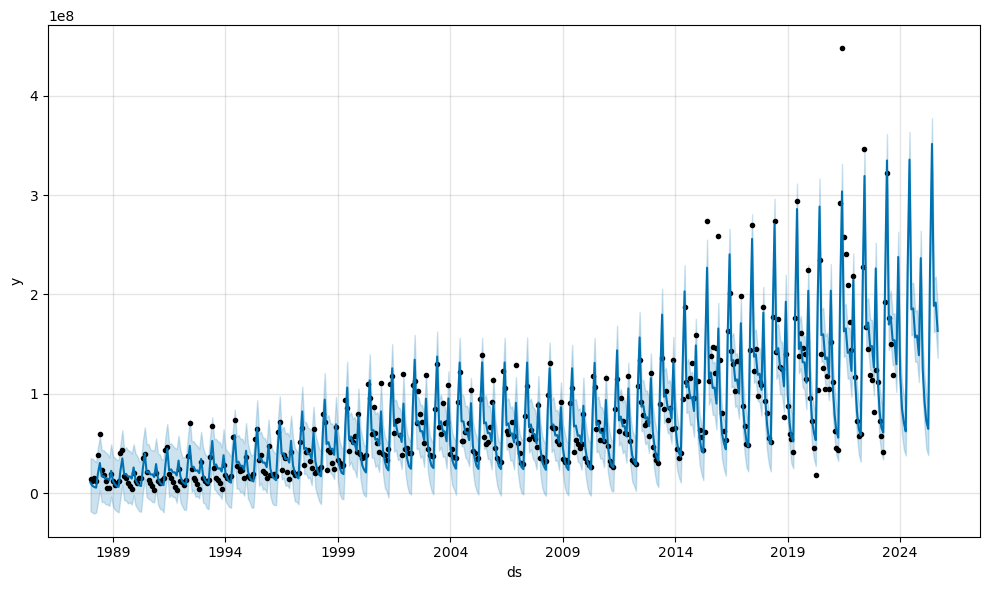

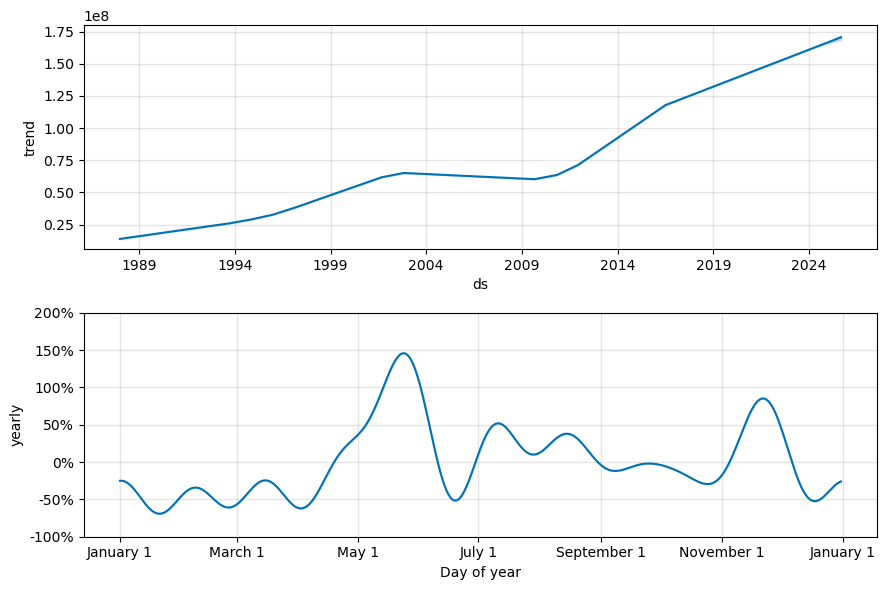

In [176]:
# predict 2018, 2019

prediction_range = 24
prediction_frequency = "MS"
future = m.make_future_dataframe(periods = 24, freq=prediction_frequency)
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

# dd/mm/YY H:M:S
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d %H:%M")
documentation["model_prediction_date:"] =  dt_string
documentation["Prediction range(num periods):"] = prediction_range
documentation["Prediction frequency:"]= prediction_frequency
documentation

In [177]:
forecast = m.predict(future)
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predictions

,ds,yhat,yhat_lower,yhat_upper
0,1988-01-01,"10,356,626.90","-16,431,560.92","37,477,335.03"
1,1988-02-01,"7,373,835.69","-19,933,835.49","32,941,384.86"
2,1988-03-01,"6,248,409.96","-19,189,531.40","31,810,774.07"
3,1988-04-01,"5,525,417.17","-21,291,672.90","31,804,745.55"
4,1988-05-01,"19,979,874.14","-6,971,381.17","45,905,923.02"
...,...,...,...,...
448,2025-05-01,"229,671,604.40","202,775,997.04","257,270,424.56"
449,2025-06-01,"351,529,731.10","325,838,238.49","376,685,077.66"
450,2025-07-01,"188,421,374.99","161,373,313.03","215,975,869.10"
451,2025-08-01,"191,784,705.50","167,431,805.85","219,323,898.83"


#### Next steps:
* run on non log values
    * calc test / train metrics mannually
* run on noninflation adjusted vals
* Keep agg on months 

In [178]:
mape_idx = mapes.index(min(mapes))
print(mape_idx)
rmse_idx = rmses.index(min(rmses))
print(rmse_idx)

30
30


In [179]:
pd.DataFrame.from_dict(best_params, orient = 'index', columns = ['model_grouped_data'] )

,model_grouped_data
changepoint_prior_scale,0.10
seasonality_prior_scale,1.01
seasonality_mode,multiplicative
yearly_seasonality,True
rmse,"26,305,292.84"
mape,0.18


In [180]:
documentation

{'description': 'Predictions using best params and cv on us data not adjusted for inflation or log',
 'train_data_source': 'us data: unindexed no log',
 'train_start_year': 1988,
 'train_end_year': 2017,
 'test_data_source': 'us data: unindexed no log',
 'test_start_year': 2018,
 'test_end_year': 2019,
 'model_params': {'changepoint_prior_scale': 0.101,
  'seasonality_prior_scale': 1.01,
  'seasonality_mode': 'multiplicative',
  'yearly_seasonality': True,
  'rmse': 26305292.84164052,
  'mape': 0.17541140467660435},
 'model_fit_date': '2023-12-22 14:37',
 '.fit()': 'us_data',
 'cv_param_cutoffs': DatetimeIndex(['2018-01-01', '2019-01-01'], dtype='datetime64[ns]', freq=None),
 'cv_param_initial': '10593 days',
 'cv_param_period': '365 days',
 'cv_param_horizon': '365 days',
 'cv_param_parallel': 'processes',
 'model_prediction_date:': '2023-12-22 14:37',
 'Prediction range(num periods):': 24,
 'Prediction frequency:': 'MS'}

In [181]:
# Model Eval Metrics
# split y actuals and predictions for train range
y_actual_train = df_year_filter(model_data_grouped, 1988, 2017)['y']
y_pred_train = df_year_filter(predictions, 1988, 2017)['yhat']

# RMSE - PROPHET - 1988 to 2017 TRAIN RANGE

mse_train = mean_squared_error(y_actual_train, y_pred_train, squared=True)
rmse_train =  mean_squared_error(y_actual_train, y_pred_train, squared=False)
mape_train = mean_absolute_percentage_error(y_actual_train, y_pred_train)
# print(f'Train Prophet MSE value is {mse_train: ,.2f}, years 1988 to 2017')
# print(f'Train Prophet RMSE value is {rmse_train : ,.2f}, years 1988 to 2017')
# print(f'Train Prophet MAPE value is {mape_train: ,.5f}, years 1988 to 2017')

# RMSE - PROPHET - 2018 to 2019 TEST RANGE
# split y actuals and predictions for TEST range
y_actual_test = df_year_filter(model_data_grouped, 2018, 2019)['y']
y_pred_test = df_year_filter(predictions, 2018, 2019)['yhat']


mse_test = mean_squared_error(y_actual_test, y_pred_test, squared=True)
rmse_test =  mean_squared_error(y_actual_test, y_pred_test, squared=False)
mape_test = mean_absolute_percentage_error(y_actual_test, y_pred_test)
# print(f'TEST Prophet MSE value is {mse_test: ,.2f}, years 2018 to 2019')
# print(f'TEST Prophet RMSE value is {rmse_test : ,.2f}, years 2018 to 2019')
# print(f'TEST Prophet MAPE value is {mape_test: ,.5f}, years 2018 to 2019')
best_prophet_vals = [mse_train, mse_test, rmse_train, rmse_test, mape_train, mape_test]

In [182]:
results = pd.DataFrame(data={'Prophet-Best':best_prophet_vals}, index = ['mse_train', 'mse_test', 'rmse_train', 'rmse_test', 'mape_train', 'mape_test'])

In [183]:
results

,Prophet-Best
mse_train,"1,415,017,803,445,176.25"
mse_test,"1,182,226,568,181,031.25"
rmse_train,"37,616,722.39"
rmse_test,"34,383,521.75"
mape_train,0.37
mape_test,0.17


In [184]:
documentation['results'] = results.to_dict()

In [185]:
documentation

{'description': 'Predictions using best params and cv on us data not adjusted for inflation or log',
 'train_data_source': 'us data: unindexed no log',
 'train_start_year': 1988,
 'train_end_year': 2017,
 'test_data_source': 'us data: unindexed no log',
 'test_start_year': 2018,
 'test_end_year': 2019,
 'model_params': {'changepoint_prior_scale': 0.101,
  'seasonality_prior_scale': 1.01,
  'seasonality_mode': 'multiplicative',
  'yearly_seasonality': True,
  'rmse': 26305292.84164052,
  'mape': 0.17541140467660435},
 'model_fit_date': '2023-12-22 14:37',
 '.fit()': 'us_data',
 'cv_param_cutoffs': DatetimeIndex(['2018-01-01', '2019-01-01'], dtype='datetime64[ns]', freq=None),
 'cv_param_initial': '10593 days',
 'cv_param_period': '365 days',
 'cv_param_horizon': '365 days',
 'cv_param_parallel': 'processes',
 'model_prediction_date:': '2023-12-22 14:37',
 'Prediction range(num periods):': 24,
 'Prediction frequency:': 'MS',
 'results': {'Prophet-Best': {'mse_train': 1415017803445176.2,


# Results

In [123]:
# def mean_absolute_percentage_error(y_true, y_pred):
#     '''take in true(actual) and predicted values to calculate the MAPE score. 
#     MAPE = mean absolute percentage error'''
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     result = np.mean(np.abs((y_true - y_pred) / y_true))
#     return result

# Bin

In [82]:
tuning_attempts['smaller_CPS'] = best_params
tuning_attempts

,attempt1,initial=10yrs,initial=15yrs,smaller_CPS
changepoint_prior_scale,5,5,5,5
seasonality_prior_scale,25,25,25,15.00
seasonality_mode,multiplicative,multiplicative,multiplicative,multiplicative
yearly_seasonality,True,True,True,True
rmse,"84,155,734.63","84,155,734.63","84,155,734.63","83,961,852.17"


In [81]:
# attempt1_results = pd.DataFrame.from_dict(best_params, orient='index', columns = ['attempt1'])
tuning_attempts

,attempt1,initial=10yrs,initial=15yrs
changepoint_prior_scale,5,5,5
seasonality_prior_scale,25,25,25
seasonality_mode,multiplicative,multiplicative,multiplicative
yearly_seasonality,True,True,True
rmse,"84,155,734.63","84,155,734.63","84,155,734.63"
